In [2]:
#Required Packages

import dlib
import cv2
from imutils import face_utils
from scipy.spatial import distance 
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
#reading the dataset 
import pandas as pd
df_total = pd.read_csv('totalwithmaininfo.csv')
df_total.head()

,EAR,MAR,CIR,Mouth_EYE,label,Respondent,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.284246,0.947518,0.482625,3.333446,10.0,0,0.318166,-1.152166,3.818145,-1.250515
1,0.292527,0.994375,0.483918,3.399259,10.0,0,0.641281,-0.589006,3.883234,-1.071398
2,0.267323,0.996076,0.449280,3.726111,10.0,0,-0.342113,-0.568555,2.139234,-0.181830
3,0.350346,0.967453,0.534985,2.761419,10.0,0,2.897273,-0.912575,6.454395,-2.807358
4,0.328317,0.988977,0.537504,3.012266,10.0,0,2.037727,-0.653878,6.581202,-2.124648


In [4]:
df_total.isna().sum()

EAR              0
MAR              0
CIR              0
Mouth_EYE        0
label            0
Respondent       0
EAR_N            0
MAR_N            0
Circularity_N    0
MOE_N            0
dtype: int64

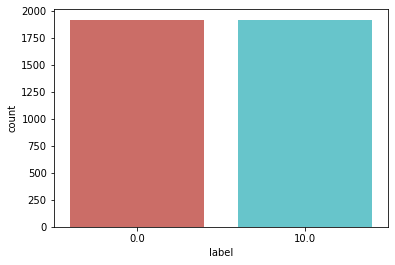

In [5]:
# Visualizing the result column
# Alert is labelled as '0' 
# Drowsyness is labelled as '10'
import seaborn as sns

df_total.label.value_counts()
sns.countplot(x = 'label', data = df_total, palette = 'hls')
plt.show()

In [6]:
from scipy.spatial import distance 
def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear
def mouth_aspect_ratio(mouth):
	A = distance.euclidean(mouth[14], mouth[18])
	C = distance.euclidean(mouth[12], mouth[16])
	mar = (A ) / (C)
	return mar
def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)
def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye

In [7]:
def average(y_pred):
    for i in range(len(y_pred)):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] +  y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred

In [8]:
#Diving the columns into dependent and independent columns
X = df_total[['EAR_N', 'MAR_N', 'Circularity_N', 'MOE_N']]
Y = df_total['label']
#Dividing the data into test and training data 
#Logistic Regression
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=0)
#training the model 
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

/Users/manikishore/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
#Predicting Y for test data
y_pred=logreg.predict(X_test)
#calcluating confusion matrix 
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[346,  59],
       [111, 252]])

In [10]:
#Printing Accuracy, Precesion, Recall
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, pos_label=0.))
print("Recall:",metrics.recall_score(y_test, y_pred, pos_label=0.))


Accuracy: 0.7786458333333334
Precision: 0.7571115973741794
Recall: 0.854320987654321


In [11]:
def model(landmarks):

    features = pd.DataFrame(columns=["EAR","MAR","Circularity","MOE"])

    eye = landmarks[36:68]
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)
    df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
    df["EAR_N"] = (df["EAR"]-mean["EAR"])/ std["EAR"]
    df["MAR_N"] = (df["MAR"]-mean["MAR"])/ std["MAR"]
    df["Circularity_N"] = (df["Circularity"]-mean["Circularity"])/ std["Circularity"]
    df["MOE_N"] = (df["MOE"]-mean["MOE"])/ std["MOE"]
    df = df[['EAR_N', 'MAR_N', 'Circularity_N', 'MOE_N']]
    
    Result = logreg.predict(df)
    if Result == 10:
        Result_String = "Drowsy"
    else:
        Result_String = "Alert"
    

    return Result_String, df.values

In [12]:
import dlib
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [13]:
def calibration():
    data = []
    cap = cv2.VideoCapture(0)

    while True:
        _, image = cap.read()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        rects = detector(image, 0)

        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            data.append(shape)
            cv2.putText(image,"Calibrating...", bottomLeftCornerOfText, font, fontScale, fontColor,lineType)

            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        cv2.imshow("Output", image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    cap.release()
    
    
    features_test = []
    for d in data:
        eye = d[36:68]
        ear = eye_aspect_ratio(eye)
        mar = mouth_aspect_ratio(eye)
        cir = circularity(eye)
        mouth_eye = mouth_over_eye(eye)
        features_test.append([ear, mar, cir, mouth_eye])
    
    features_test = np.array(features_test)
    x = features_test
    y = pd.DataFrame(x,columns=["EAR","MAR","Circularity","MOE"])
    df_means = y.mean(axis=0)
    df_std = y.std(axis=0)
    
    return df_means,df_std

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

In [14]:
#Calibration
mean, std = calibration()

In [15]:
std

EAR            0.040220
MAR            0.100526
Circularity    0.036317
MOE            0.709828
dtype: float64

In [16]:
import cv2
from imutils import face_utils
import dlib
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)
def live():
    cap = cv2.VideoCapture(0)
    data = []
    result = []
    while True:
        _, image = cap.read()
        print(image)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        rects = detector(image, 0)

        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            Result_String, features = model(shape)
            cv2.putText(image,Result_String, bottomLeftCornerOfText, font, fontScale, fontColor,lineType)
            data.append (features)
            result.append(Result_String)

            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        cv2.imshow("Output", image)

        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    cap.release()
    
    return data,result

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

In [17]:
#Run Demonstration
features, result = live()

[[[50 78 89]
  [50 78 89]
  [50 78 89]
  ...
  [40 61 67]
  [40 61 67]
  [40 61 67]]

 [[50 78 89]
  [50 78 89]
  [51 79 90]
  ...
  [40 61 67]
  [40 61 67]
  [40 61 67]]

 [[49 77 88]
  [50 78 89]
  [51 79 90]
  ...
  [38 59 65]
  [39 60 66]
  [40 61 67]]

 ...

 [[37 57 72]
  [37 57 72]
  [37 57 72]
  ...
  [43 62 72]
  [43 63 71]
  [43 63 71]]

 [[39 57 72]
  [39 57 72]
  [37 57 72]
  ...
  [41 62 72]
  [43 63 71]
  [43 63 71]]

 [[39 57 72]
  [39 57 72]
  [37 57 72]
  ...
  [38 60 70]
  [42 62 70]
  [42 62 70]]]
[[[219 238 255]
  [218 237 254]
  [218 237 254]
  ...
  [164 185 190]
  [164 181 190]
  [162 180 188]]

 [[219 238 255]
  [218 237 254]
  [218 237 254]
  ...
  [163 183 189]
  [162 180 188]
  [160 178 186]]

 [[219 238 255]
  [218 237 254]
  [216 237 254]
  ...
  [165 182 191]
  [161 178 189]
  [160 177 188]]

 ...

 [[158 188 213]
  [161 192 216]
  [165 195 220]
  ...
  [175 196 206]
  [175 196 206]
  [175 196 206]]

 [[156 187 209]
  [158 189 211]
  [164 195 217]
  ...
  

[[[183 202 219]
  [182 201 218]
  [180 201 218]
  ...
  [139 154 170]
  [139 154 170]
  [139 154 170]]

 [[182 201 218]
  [182 201 218]
  [180 201 218]
  ...
  [139 154 170]
  [139 154 170]
  [139 154 170]]

 [[182 201 218]
  [182 201 218]
  [182 201 218]
  ...
  [139 154 170]
  [137 155 170]
  [137 155 170]]

 ...

 [[143 158 181]
  [145 160 183]
  [146 161 184]
  ...
  [149 165 183]
  [149 165 183]
  [148 164 182]]

 [[146 158 183]
  [147 159 185]
  [145 160 183]
  ...
  [148 164 182]
  [148 164 182]
  [148 164 182]]

 [[148 160 186]
  [148 160 186]
  [145 160 183]
  ...
  [148 164 182]
  [148 164 182]
  [148 164 182]]]
[[[176 200 219]
  [176 200 219]
  [178 199 219]
  ...
  [147 153 168]
  [147 153 168]
  [147 153 168]]

 [[176 200 219]
  [175 198 217]
  [177 198 217]
  ...
  [147 153 168]
  [147 153 168]
  [147 153 168]]

 [[180 200 220]
  [177 198 217]
  [176 197 216]
  ...
  [147 154 167]
  [147 154 167]
  [147 154 167]]

 ...

 [[145 160 183]
  [144 159 182]
  [144 159 182]
  ..

[[[183 201 221]
  [183 201 221]
  [185 201 221]
  ...
  [136 154 167]
  [134 155 167]
  [135 156 168]]

 [[183 201 221]
  [183 201 221]
  [185 201 221]
  ...
  [137 155 168]
  [134 155 167]
  [134 155 167]]

 [[185 201 221]
  [184 200 220]
  [184 200 220]
  ...
  [137 155 168]
  [135 156 168]
  [135 156 168]]

 ...

 [[140 162 179]
  [141 163 180]
  [141 162 181]
  ...
  [153 165 182]
  [153 165 182]
  [152 164 180]]

 [[141 162 181]
  [141 162 181]
  [144 163 182]
  ...
  [154 164 180]
  [154 164 180]
  [154 164 180]]

 [[142 163 182]
  [142 163 182]
  [144 163 182]
  ...
  [152 163 179]
  [152 163 179]
  [152 163 179]]]
[[[176 200 219]
  [176 200 219]
  [178 199 219]
  ...
  [142 155 171]
  [140 155 171]
  [139 154 170]]

 [[176 200 219]
  [176 200 219]
  [178 199 219]
  ...
  [141 154 170]
  [139 154 170]
  [138 153 169]]

 [[175 198 217]
  [175 198 217]
  [177 199 216]
  ...
  [141 154 170]
  [138 153 169]
  [137 152 168]]

 ...

 [[143 162 181]
  [143 162 181]
  [140 161 180]
  ..

[[[189 196 220]
  [190 198 221]
  [189 199 223]
  ...
  [139 158 171]
  [139 158 171]
  [139 158 171]]

 [[189 196 220]
  [189 196 220]
  [188 198 221]
  ...
  [138 157 170]
  [138 157 170]
  [138 157 170]]

 [[185 196 219]
  [185 196 219]
  [185 196 219]
  ...
  [138 157 170]
  [138 157 170]
  [138 157 170]]

 ...

 [[148 163 185]
  [146 161 184]
  [146 161 184]
  ...
  [149 166 182]
  [149 166 182]
  [148 165 180]]

 [[148 163 184]
  [148 163 184]
  [143 162 181]
  ...
  [149 166 182]
  [148 165 180]
  [148 165 180]]

 [[149 165 185]
  [149 165 185]
  [144 163 182]
  ...
  [148 165 180]
  [148 165 180]
  [148 165 180]]]
[[[178 201 220]
  [176 200 219]
  [176 200 219]
  ...
  [123 141 156]
  [121 141 156]
  [127 147 162]]

 [[178 201 220]
  [176 200 219]
  [176 200 219]
  ...
  [132 150 165]
  [129 149 164]
  [132 152 167]]

 [[178 202 218]
  [176 200 217]
  [173 199 217]
  ...
  [141 158 173]
  [136 156 171]
  [135 155 170]]

 ...

 [[145 160 183]
  [145 160 183]
  [146 162 182]
  ..

[[[176 198 213]
  [177 200 214]
  [178 201 215]
  ...
  [143 154 168]
  [143 154 168]
  [143 154 168]]

 [[177 200 214]
  [177 200 214]
  [178 201 215]
  ...
  [143 154 168]
  [143 154 168]
  [143 154 168]]

 [[178 197 215]
  [179 198 216]
  [180 200 217]
  ...
  [141 155 167]
  [141 155 167]
  [141 155 167]]

 ...

 [[138 164 182]
  [138 164 182]
  [140 164 181]
  ...
  [148 164 178]
  [146 165 178]
  [145 164 177]]

 [[135 164 180]
  [135 164 180]
  [137 164 180]
  ...
  [147 163 177]
  [147 163 177]
  [147 163 177]]

 [[135 164 180]
  [135 164 180]
  [137 164 180]
  ...
  [147 163 177]
  [147 163 177]
  [147 163 177]]]
[[[180 200 220]
  [181 202 221]
  [180 200 220]
  ...
  [143 153 170]
  [143 153 172]
  [143 153 172]]

 [[180 200 220]
  [180 200 220]
  [178 199 219]
  ...
  [143 153 170]
  [143 153 172]
  [143 153 172]]

 [[178 199 219]
  [180 200 220]
  [180 199 219]
  ...
  [140 153 169]
  [141 154 170]
  [141 154 170]]

 ...

 [[141 159 179]
  [143 162 181]
  [144 163 182]
  ..

[[[187 211 227]
  [186 210 226]
  [184 210 226]
  ...
  [153 167 178]
  [151 168 178]
  [151 168 178]]

 [[187 211 227]
  [186 210 226]
  [183 209 225]
  ...
  [153 167 178]
  [151 168 178]
  [150 166 177]]

 [[186 210 226]
  [186 210 226]
  [185 209 225]
  ...
  [151 168 178]
  [151 168 178]
  [150 166 177]]

 ...

 [[156 172 190]
  [157 174 191]
  [157 174 191]
  ...
  [159 176 194]
  [159 176 194]
  [158 175 193]]

 [[158 170 193]
  [158 170 193]
  [156 171 193]
  ...
  [158 175 193]
  [161 176 192]
  [160 175 191]]

 [[158 170 193]
  [157 169 192]
  [154 170 192]
  ...
  [157 174 191]
  [160 175 191]
  [159 174 190]]]
[[[188 209 228]
  [187 207 227]
  [185 208 227]
  ...
  [147 162 178]
  [147 162 178]
  [146 161 177]]

 [[188 209 228]
  [187 207 227]
  [186 209 228]
  ...
  [147 162 178]
  [146 161 177]
  [146 161 177]]

 [[185 208 227]
  [185 208 227]
  [186 209 228]
  ...
  [146 161 177]
  [146 161 177]
  [145 160 176]]

 ...

 [[152 171 195]
  [152 171 195]
  [154 170 195]
  ..

[[[190 205 223]
  [189 204 222]
  [187 200 221]
  ...
  [143 159 172]
  [143 159 172]
  [144 160 173]]

 [[191 206 224]
  [190 205 223]
  [188 202 222]
  ...
  [144 160 173]
  [144 160 173]
  [144 160 173]]

 [[189 207 222]
  [188 206 221]
  [189 204 222]
  ...
  [148 158 175]
  [148 158 175]
  [147 157 173]]

 ...

 [[153 165 183]
  [153 165 183]
  [152 166 184]
  ...
  [149 169 184]
  [152 170 185]
  [152 170 185]]

 [[151 165 183]
  [150 164 182]
  [151 165 183]
  ...
  [151 172 185]
  [154 170 184]
  [154 170 184]]

 [[152 166 184]
  [152 166 184]
  [152 166 184]
  ...
  [151 172 185]
  [154 170 184]
  [154 170 184]]]
[[[187 200 223]
  [187 200 223]
  [188 202 222]
  ...
  [147 160 174]
  [149 161 173]
  [149 161 173]]

 [[188 201 224]
  [187 200 223]
  [187 200 221]
  ...
  [148 162 175]
  [149 161 173]
  [149 161 173]]

 [[187 200 223]
  [187 200 223]
  [187 200 223]
  ...
  [147 160 174]
  [147 161 173]
  [146 160 171]]

 ...

 [[145 168 187]
  [145 168 187]
  [146 169 188]
  ..

[[[186 204 219]
  [187 205 220]
  [186 204 219]
  ...
  [135 160 168]
  [137 160 168]
  [137 160 168]]

 [[187 205 220]
  [187 205 220]
  [187 205 220]
  ...
  [135 160 168]
  [137 160 168]
  [139 161 169]]

 [[186 204 219]
  [187 205 220]
  [187 205 220]
  ...
  [136 159 166]
  [139 159 169]
  [141 160 170]]

 ...

 [[150 166 186]
  [149 165 185]
  [149 165 185]
  ...
  [148 167 184]
  [145 166 183]
  [143 165 182]]

 [[148 162 182]
  [148 162 182]
  [146 162 182]
  ...
  [149 168 186]
  [148 167 184]
  [146 165 182]]

 [[147 161 181]
  [147 161 181]
  [146 162 182]
  ...
  [149 168 186]
  [149 168 186]
  [147 166 183]]]
[[[176 205 220]
  [176 205 220]
  [175 204 218]
  ...
  [144 160 173]
  [146 160 171]
  [145 159 170]]

 [[177 206 222]
  [176 205 220]
  [176 205 219]
  ...
  [144 160 173]
  [146 160 171]
  [146 160 171]]

 [[181 206 220]
  [180 205 219]
  [180 205 219]
  ...
  [141 159 172]
  [146 159 173]
  [146 159 173]]

 ...

 [[154 164 188]
  [155 165 189]
  [154 164 188]
  ..

[[[182 206 223]
  [181 205 222]
  [180 204 220]
  ...
  [148 160 179]
  [147 159 177]
  [147 159 177]]

 [[181 205 222]
  [180 204 220]
  [179 203 219]
  ...
  [148 160 179]
  [148 160 179]
  [147 159 177]]

 [[179 202 221]
  [178 201 220]
  [176 200 219]
  ...
  [145 159 177]
  [145 159 177]
  [145 159 177]]

 ...

 [[145 166 183]
  [145 166 183]
  [145 166 183]
  ...
  [149 168 186]
  [149 168 186]
  [149 168 186]]

 [[149 166 182]
  [149 166 182]
  [147 167 182]
  ...
  [151 168 186]
  [152 169 187]
  [152 169 187]]

 [[149 166 182]
  [150 167 183]
  [148 168 183]
  ...
  [152 169 187]
  [152 169 187]
  [152 169 187]]]
[[[177 203 219]
  [177 203 219]
  [178 204 220]
  ...
  [148 159 173]
  [149 160 174]
  [149 160 174]]

 [[178 204 220]
  [178 204 220]
  [178 204 220]
  ...
  [149 160 174]
  [149 160 174]
  [149 160 174]]

 [[181 205 222]
  [180 204 220]
  [180 205 219]
  ...
  [149 160 174]
  [149 160 174]
  [149 160 174]]

 ...

 [[157 166 187]
  [156 165 186]
  [153 164 185]
  ..

[[[183 205 220]
  [182 204 219]
  [182 204 219]
  ...
  [145 160 169]
  [143 160 169]
  [143 160 169]]

 [[183 205 220]
  [182 204 219]
  [182 204 219]
  ...
  [146 161 170]
  [143 160 169]
  [143 160 169]]

 [[185 205 220]
  [184 204 219]
  [183 203 218]
  ...
  [146 161 170]
  [144 161 170]
  [144 161 170]]

 ...

 [[148 167 184]
  [148 167 184]
  [148 166 186]
  ...
  [154 169 185]
  [157 170 186]
  [156 169 185]]

 [[146 167 184]
  [145 166 183]
  [146 167 186]
  ...
  [156 168 187]
  [161 170 189]
  [159 169 188]]

 [[145 166 183]
  [145 166 183]
  [146 167 186]
  ...
  [155 167 186]
  [158 168 187]
  [158 168 187]]]
[[[180 204 220]
  [178 202 218]
  [178 200 217]
  ...
  [144 160 173]
  [144 160 173]
  [144 160 173]]

 [[180 204 220]
  [178 202 218]
  [178 200 217]
  ...
  [144 160 173]
  [144 160 173]
  [144 160 173]]

 [[179 203 219]
  [176 200 217]
  [175 199 216]
  ...
  [144 160 173]
  [144 160 173]
  [144 160 173]]

 ...

 [[147 167 189]
  [147 167 189]
  [145 167 189]
  ..

[[[185 205 220]
  [185 205 220]
  [185 205 220]
  ...
  [141 154 170]
  [138 153 169]
  [141 157 172]]

 [[187 207 222]
  [186 206 221]
  [185 205 220]
  ...
  [143 156 172]
  [141 157 172]
  [141 157 172]]

 [[186 206 221]
  [185 205 220]
  [185 205 220]
  ...
  [141 157 172]
  [143 158 173]
  [143 158 173]]

 ...

 [[154 168 188]
  [154 168 188]
  [152 168 188]
  ...
  [153 165 182]
  [156 166 183]
  [156 166 183]]

 [[153 167 186]
  [153 167 186]
  [154 168 188]
  ...
  [152 164 180]
  [156 166 183]
  [156 166 183]]

 [[151 165 183]
  [152 166 184]
  [152 165 186]
  ...
  [153 165 182]
  [156 166 183]
  [156 166 183]]]
[[[178 201 215]
  [178 201 215]
  [178 202 217]
  ...
  [147 160 176]
  [148 158 175]
  [149 159 176]]

 [[178 201 215]
  [180 202 217]
  [179 204 218]
  ...
  [147 160 176]
  [148 158 175]
  [148 158 175]]

 [[178 202 217]
  [179 204 218]
  [179 204 218]
  ...
  [146 158 175]
  [148 158 175]
  [148 158 175]]

 ...

 [[146 167 186]
  [146 167 186]
  [146 167 186]
  ..

[[[184 203 220]
  [182 201 218]
  [180 200 217]
  ...
  [143 158 173]
  [145 157 173]
  [146 158 175]]

 [[184 203 220]
  [183 202 219]
  [182 201 218]
  ...
  [144 159 175]
  [145 157 173]
  [145 157 173]]

 [[186 203 220]
  [186 203 220]
  [185 202 219]
  ...
  [144 159 175]
  [145 157 173]
  [145 157 173]]

 ...

 [[149 167 187]
  [149 167 187]
  [148 166 186]
  ...
  [146 171 185]
  [148 171 185]
  [148 171 185]]

 [[146 167 186]
  [146 167 186]
  [148 166 186]
  ...
  [147 169 184]
  [148 171 185]
  [148 171 185]]

 [[146 167 186]
  [146 167 186]
  [148 166 186]
  ...
  [147 169 184]
  [147 169 184]
  [147 169 184]]]
[[[184 204 219]
  [184 204 219]
  [184 204 219]
  ...
  [143 158 169]
  [145 159 170]
  [146 160 171]]

 [[184 204 219]
  [185 205 220]
  [185 205 220]
  ...
  [143 158 169]
  [145 159 170]
  [146 160 171]]

 [[186 204 219]
  [187 205 220]
  [187 205 220]
  ...
  [145 159 170]
  [146 160 171]
  [147 161 173]]

 ...

 [[147 165 185]
  [147 165 185]
  [147 165 185]
  ..

[[[183 205 222]
  [183 205 222]
  [182 203 220]
  ...
  [150 161 175]
  [149 160 174]
  [149 160 174]]

 [[184 206 223]
  [183 205 222]
  [181 202 219]
  ...
  [149 160 174]
  [149 160 174]
  [149 160 174]]

 [[184 206 223]
  [183 205 222]
  [181 202 221]
  ...
  [148 159 173]
  [151 160 174]
  [151 160 174]]

 ...

 [[148 168 183]
  [149 169 184]
  [147 169 186]
  ...
  [152 168 181]
  [150 168 181]
  [150 168 181]]

 [[149 169 184]
  [149 169 184]
  [149 168 186]
  ...
  [152 167 183]
  [152 168 181]
  [152 168 181]]

 [[149 169 184]
  [150 170 185]
  [149 168 186]
  ...
  [152 167 183]
  [152 168 181]
  [152 168 181]]]
[[[187 200 223]
  [187 200 223]
  [187 200 223]
  ...
  [151 156 169]
  [153 157 170]
  [155 160 173]]

 [[187 200 223]
  [187 200 223]
  [187 200 223]
  ...
  [153 157 170]
  [153 157 170]
  [154 159 171]]

 [[184 199 221]
  [185 200 223]
  [185 200 223]
  ...
  [154 158 173]
  [152 159 171]
  [152 159 171]]

 ...

 [[135 167 186]
  [136 168 188]
  [141 168 189]
  ..

[[[181 202 221]
  [181 202 221]
  [183 202 219]
  ...
  [148 155 170]
  [148 155 170]
  [147 153 168]]

 [[182 203 222]
  [182 203 222]
  [183 202 219]
  ...
  [148 155 170]
  [148 155 170]
  [148 155 170]]

 [[186 202 222]
  [185 201 221]
  [183 202 219]
  ...
  [148 155 170]
  [148 155 170]
  [149 156 171]]

 ...

 [[141 165 184]
  [141 165 184]
  [140 163 182]
  ...
  [144 164 179]
  [146 164 179]
  [146 164 179]]

 [[141 164 185]
  [140 163 184]
  [138 164 182]
  ...
  [144 164 179]
  [145 163 178]
  [145 163 178]]

 [[141 164 185]
  [140 163 184]
  [138 164 182]
  ...
  [143 163 178]
  [145 163 178]
  [144 162 177]]]
[[[178 199 219]
  [178 199 219]
  [177 198 217]
  ...
  [145 157 171]
  [142 156 170]
  [142 156 170]]

 [[178 199 219]
  [178 199 219]
  [177 198 217]
  ...
  [145 157 171]
  [142 156 170]
  [142 156 170]]

 [[180 199 219]
  [179 198 217]
  [177 198 217]
  ...
  [144 155 170]
  [142 156 170]
  [142 156 170]]

 ...

 [[141 162 181]
  [140 161 180]
  [142 160 180]
  ..

[[[175 199 216]
  [173 197 214]
  [172 196 212]
  ...
  [145 157 173]
  [145 157 173]
  [145 157 173]]

 [[175 199 216]
  [174 198 215]
  [172 196 212]
  ...
  [146 158 175]
  [145 157 173]
  [145 157 173]]

 [[176 200 217]
  [175 199 216]
  [173 197 214]
  ...
  [150 159 173]
  [147 158 172]
  [145 157 171]]

 ...

 [[141 160 177]
  [141 160 177]
  [140 159 176]
  ...
  [149 166 182]
  [151 166 182]
  [151 166 182]]

 [[144 161 179]
  [144 161 179]
  [142 158 176]
  ...
  [148 169 181]
  [149 166 182]
  [146 164 179]]

 [[145 162 180]
  [145 162 180]
  [144 161 179]
  ...
  [147 167 180]
  [148 165 180]
  [146 164 179]]]
[[[177 198 217]
  [177 198 217]
  [180 200 217]
  ...
  [148 158 175]
  [148 158 175]
  [147 157 173]]

 [[177 198 217]
  [178 199 219]
  [180 200 217]
  ...
  [147 157 173]
  [147 157 173]
  [147 157 173]]

 [[178 200 217]
  [178 200 217]
  [182 202 217]
  ...
  [147 158 172]
  [147 158 172]
  [145 157 171]]

 ...

 [[134 158 177]
  [134 158 177]
  [137 159 181]
  ..

[[[174 199 213]
  [173 198 212]
  [172 197 211]
  ...
  [141 157 172]
  [139 154 170]
  [139 154 170]]

 [[176 201 215]
  [174 199 213]
  [173 198 212]
  ...
  [141 157 172]
  [138 153 169]
  [138 153 169]]

 [[178 201 215]
  [178 201 215]
  [176 198 213]
  ...
  [141 157 172]
  [139 154 170]
  [139 154 170]]

 ...

 [[146 160 180]
  [146 160 180]
  [146 160 180]
  ...
  [148 164 182]
  [146 165 182]
  [146 165 182]]

 [[146 159 182]
  [145 158 181]
  [146 159 182]
  ...
  [146 163 181]
  [146 163 181]
  [146 163 181]]

 [[145 158 181]
  [144 156 179]
  [145 158 181]
  ...
  [146 163 181]
  [146 163 181]
  [146 163 181]]]
[[[183 202 219]
  [182 201 218]
  [181 198 216]
  ...
  [146 157 166]
  [144 157 166]
  [144 157 166]]

 [[183 202 219]
  [180 200 217]
  [181 198 216]
  ...
  [147 158 168]
  [144 157 166]
  [144 157 166]]

 [[184 201 217]
  [182 200 215]
  [181 198 216]
  ...
  [149 159 169]
  [145 159 166]
  [144 158 165]]

 ...

 [[144 161 179]
  [143 160 177]
  [144 161 179]
  ..

[[[179 197 219]
  [178 196 218]
  [176 196 218]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 [[180 198 220]
  [179 197 219]
  [177 197 219]
  ...
  [145 159 170]
  [145 159 170]
  [143 158 169]]

 [[178 198 220]
  [177 197 219]
  [174 196 218]
  ...
  [150 159 171]
  [147 159 170]
  [147 159 170]]

 ...

 [[138 165 181]
  [138 165 181]
  [140 164 181]
  ...
  [149 170 182]
  [149 170 182]
  [148 169 181]]

 [[138 165 181]
  [138 165 181]
  [139 163 180]
  ...
  [148 169 180]
  [147 170 182]
  [146 169 181]]

 [[137 164 180]
  [137 164 180]
  [139 163 180]
  ...
  [147 168 178]
  [146 169 181]
  [146 169 181]]]
[[[185 201 221]
  [185 201 221]
  [184 200 220]
  ...
  [137 151 169]
  [139 151 169]
  [140 152 170]]

 [[186 202 222]
  [186 202 222]
  [185 201 221]
  ...
  [136 150 168]
  [138 150 168]
  [139 151 169]]

 [[186 202 222]
  [186 202 222]
  [182 200 220]
  ...
  [138 151 165]
  [140 151 165]
  [140 151 165]]

 ...

 [[140 165 179]
  [140 165 179]
  [139 164 178]
  ..

[[[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [145 162 173]
  [144 160 173]
  [143 159 172]]

 [[180 200 217]
  [179 198 216]
  [179 198 216]
  ...
  [141 158 169]
  [140 156 170]
  [140 156 170]]

 [[177 199 216]
  [177 199 216]
  [178 197 215]
  ...
  [135 154 164]
  [136 155 166]
  [136 155 166]]

 ...

 [[144 160 180]
  [143 159 179]
  [143 160 177]
  ...
  [146 164 179]
  [146 164 179]
  [146 164 179]]

 [[143 162 181]
  [142 160 180]
  [141 160 177]
  ...
  [145 163 178]
  [145 163 178]
  [145 163 178]]

 [[142 160 180]
  [142 160 180]
  [141 160 177]
  ...
  [144 162 177]
  [144 162 177]
  [144 162 177]]]
[[[177 198 217]
  [177 198 217]
  [176 196 218]
  ...
  [137 154 172]
  [136 153 170]
  [136 153 170]]

 [[177 198 217]
  [177 198 217]
  [176 196 218]
  ...
  [137 154 172]
  [136 153 170]
  [136 153 170]]

 [[177 198 217]
  [177 198 217]
  [177 198 217]
  ...
  [139 153 172]
  [139 153 172]
  [138 152 170]]

 ...

 [[139 160 177]
  [138 159 176]
  [140 159 176]
  ..

[[[182 201 218]
  [179 198 216]
  [179 198 217]
  ...
  [149 157 173]
  [149 157 173]
  [149 157 173]]

 [[184 203 220]
  [182 201 218]
  [180 199 219]
  ...
  [149 157 173]
  [149 157 173]
  [149 157 173]]

 [[183 201 221]
  [182 200 220]
  [180 199 219]
  ...
  [145 156 172]
  [147 157 173]
  [147 157 173]]

 ...

 [[140 162 179]
  [140 162 179]
  [140 162 179]
  ...
  [152 165 179]
  [150 164 178]
  [149 163 177]]

 [[138 162 179]
  [139 163 180]
  [138 162 179]
  ...
  [150 164 178]
  [151 162 177]
  [150 161 175]]

 [[138 162 179]
  [139 163 180]
  [139 163 180]
  ...
  [150 164 178]
  [151 162 177]
  [150 161 175]]]
[[[184 202 215]
  [184 202 215]
  [184 202 215]
  ...
  [144 155 171]
  [145 156 172]
  [145 156 172]]

 [[184 202 215]
  [184 202 215]
  [184 202 215]
  ...
  [144 155 171]
  [145 156 172]
  [145 156 172]]

 [[184 202 215]
  [184 202 215]
  [185 203 216]
  ...
  [142 155 171]
  [142 155 171]
  [143 156 172]]

 ...

 [[147 158 179]
  [147 158 179]
  [147 158 179]
  ..

[[[179 198 217]
  [179 198 217]
  [180 200 217]
  ...
  [144 155 170]
  [144 156 168]
  [144 156 168]]

 [[179 198 217]
  [179 198 217]
  [179 198 216]
  ...
  [144 155 170]
  [144 156 168]
  [145 157 169]]

 [[181 197 217]
  [181 197 217]
  [181 198 216]
  ...
  [142 156 170]
  [142 157 168]
  [142 157 168]]

 ...

 [[144 162 175]
  [143 161 174]
  [145 161 174]
  ...
  [147 162 180]
  [146 163 181]
  [146 163 181]]

 [[144 162 177]
  [143 160 176]
  [143 160 176]
  ...
  [145 163 178]
  [145 163 178]
  [145 163 178]]

 [[144 162 177]
  [143 160 176]
  [143 160 176]
  ...
  [145 163 178]
  [145 163 178]
  [144 162 177]]]
[[[181 202 219]
  [180 201 218]
  [182 201 218]
  ...
  [139 155 168]
  [139 155 168]
  [139 155 168]]

 [[181 202 219]
  [180 201 218]
  [182 201 218]
  ...
  [141 157 171]
  [140 156 170]
  [139 155 168]]

 [[182 201 218]
  [182 201 218]
  [182 201 218]
  ...
  [141 157 171]
  [140 156 170]
  [140 156 170]]

 ...

 [[142 161 179]
  [142 161 179]
  [142 161 179]
  ..

[[[181 196 212]
  [181 196 212]
  [184 200 215]
  ...
  [146 156 168]
  [145 155 167]
  [145 155 167]]

 [[180 195 211]
  [181 196 212]
  [183 198 214]
  ...
  [145 155 167]
  [145 155 167]
  [145 155 167]]

 [[181 193 210]
  [183 196 212]
  [181 196 212]
  ...
  [143 154 168]
  [145 155 167]
  [145 155 167]]

 ...

 [[143 159 179]
  [144 160 180]
  [144 160 180]
  ...
  [148 165 180]
  [146 166 180]
  [144 164 179]]

 [[143 159 179]
  [144 160 180]
  [142 161 179]
  ...
  [143 163 178]
  [143 163 178]
  [143 163 178]]

 [[142 158 178]
  [144 160 180]
  [142 161 179]
  ...
  [142 162 177]
  [143 163 178]
  [143 163 178]]]
[[[178 202 218]
  [176 200 217]
  [177 199 216]
  ...
  [135 153 173]
  [135 153 173]
  [134 152 172]]

 [[176 200 217]
  [175 199 216]
  [177 199 216]
  ...
  [135 153 173]
  [136 155 174]
  [136 155 174]]

 [[175 199 216]
  [175 199 216]
  [174 198 215]
  ...
  [138 155 173]
  [138 155 173]
  [139 156 174]]

 ...

 [[ 71  90 116]
  [ 69  87 114]
  [ 65  85 113]
  ..

[[[221 242 255]
  [221 242 255]
  [221 242 255]
  ...
  [185 195 212]
  [182 192 208]
  [180 191 207]]

 [[221 242 255]
  [221 242 255]
  [221 242 255]
  ...
  [185 195 212]
  [182 192 208]
  [179 190 206]]

 [[221 242 255]
  [221 242 255]
  [224 243 255]
  ...
  [182 195 211]
  [181 193 211]
  [180 191 210]]

 ...

 [[189 196 216]
  [189 196 216]
  [187 197 216]
  ...
  [184 204 219]
  [185 204 222]
  [185 204 222]]

 [[185 196 217]
  [184 195 216]
  [184 195 216]
  ...
  [186 203 220]
  [186 203 220]
  [186 203 220]]

 [[184 195 216]
  [184 195 216]
  [184 195 216]
  ...
  [186 203 220]
  [186 203 220]
  [185 202 219]]]
[[[223 242 255]
  [223 242 255]
  [221 242 255]
  ...
  [173 198 212]
  [173 198 212]
  [174 199 213]]

 [[223 242 255]
  [223 242 255]
  [220 241 253]
  ...
  [174 199 213]
  [175 200 214]
  [176 201 215]]

 [[225 241 255]
  [224 240 253]
  [222 240 253]
  ...
  [175 200 214]
  [176 202 214]
  [178 203 215]]

 ...

 [[181 197 217]
  [182 198 219]
  [182 198 219]
  ..

[[[218 245 254]
  [218 245 254]
  [218 244 255]
  ...
  [183 194 208]
  [184 195 209]
  [184 195 209]]

 [[219 246 255]
  [218 245 254]
  [218 244 255]
  ...
  [184 195 209]
  [184 195 209]
  [185 196 210]]

 [[225 247 255]
  [224 246 254]
  [221 246 255]
  ...
  [185 197 209]
  [185 197 209]
  [185 197 209]]

 ...

 [[177 196 221]
  [177 196 221]
  [175 197 221]
  ...
  [191 208 224]
  [195 210 226]
  [193 208 224]]

 [[177 197 219]
  [177 197 219]
  [175 198 219]
  ...
  [189 207 222]
  [191 208 224]
  [187 205 220]]

 [[177 197 219]
  [177 197 219]
  [175 198 219]
  ...
  [188 206 221]
  [188 206 221]
  [186 204 219]]]
[[[220 244 254]
  [220 244 254]
  [220 244 254]
  ...
  [186 196 215]
  [185 194 215]
  [183 191 213]]

 [[220 244 254]
  [220 244 254]
  [220 244 254]
  ...
  [184 193 212]
  [183 191 213]
  [182 190 212]]

 [[220 244 254]
  [220 244 254]
  [219 242 255]
  ...
  [182 191 210]
  [182 191 210]
  [180 190 209]]

 ...

 [[178 197 215]
  [179 198 216]
  [182 198 219]
  ..

[[[222 243 255]
  [224 244 255]
  [228 245 254]
  ...
  [181 196 219]
  [178 193 216]
  [175 191 213]]

 [[221 242 255]
  [224 244 255]
  [228 245 254]
  ...
  [181 196 219]
  [178 193 216]
  [175 191 213]]

 [[221 242 255]
  [221 242 255]
  [226 245 255]
  ...
  [180 195 218]
  [176 193 216]
  [175 192 214]]

 ...

 [[162 191 214]
  [162 191 214]
  [165 193 216]
  ...
  [188 203 226]
  [188 203 226]
  [187 202 225]]

 [[162 191 214]
  [162 191 214]
  [165 193 216]
  ...
  [187 202 225]
  [187 202 225]
  [186 201 224]]

 [[167 196 218]
  [165 193 216]
  [165 193 216]
  ...
  [186 201 224]
  [186 201 224]
  [186 201 224]]]
[[[221 246 255]
  [220 244 254]
  [219 242 255]
  ...
  [180 198 213]
  [180 198 213]
  [180 198 213]]

 [[220 244 254]
  [220 244 254]
  [219 242 255]
  ...
  [180 198 213]
  [181 199 214]
  [181 199 214]]

 [[217 243 255]
  [216 242 253]
  [216 241 255]
  ...
  [179 197 212]
  [180 198 213]
  [181 199 214]]

 ...

 [[170 198 216]
  [169 197 215]
  [169 197 215]
  ..

[[[222 240 255]
  [222 240 255]
  [223 242 255]
  ...
  [178 195 211]
  [175 192 210]
  [175 192 210]]

 [[222 240 255]
  [222 240 255]
  [222 240 253]
  ...
  [177 194 210]
  [175 192 210]
  [175 192 210]]

 [[222 240 255]
  [221 238 254]
  [221 238 254]
  ...
  [175 193 208]
  [175 193 208]
  [175 193 208]]

 ...

 [[169 195 218]
  [169 195 218]
  [169 195 218]
  ...
  [185 202 219]
  [186 200 218]
  [187 201 219]]

 [[169 195 218]
  [169 195 218]
  [171 195 218]
  ...
  [187 202 218]
  [188 200 217]
  [188 200 217]]

 [[171 198 221]
  [171 198 221]
  [172 196 219]
  ...
  [187 202 218]
  [188 200 217]
  [188 200 217]]]
[[[224 244 254]
  [223 242 253]
  [223 242 255]
  ...
  [181 194 208]
  [180 193 207]
  [181 194 208]]

 [[226 245 255]
  [224 244 254]
  [223 242 255]
  ...
  [182 195 209]
  [181 194 208]
  [182 195 209]]

 [[226 245 255]
  [224 244 254]
  [224 243 255]
  ...
  [182 195 209]
  [182 195 209]
  [182 195 209]]

 ...

 [[180 199 219]
  [179 198 217]
  [178 196 218]
  ..

[[[223 242 255]
  [223 242 255]
  [220 241 253]
  ...
  [180 194 212]
  [181 195 214]
  [181 195 214]]

 [[223 242 255]
  [222 240 253]
  [220 241 253]
  ...
  [180 194 212]
  [181 195 214]
  [181 195 214]]

 [[220 240 255]
  [220 240 255]
  [220 240 255]
  ...
  [181 195 214]
  [181 195 214]
  [181 195 214]]

 ...

 [[177 197 219]
  [177 197 219]
  [176 196 218]
  ...
  [183 205 220]
  [182 208 220]
  [181 207 218]]

 [[175 198 219]
  [175 198 219]
  [173 195 217]
  ...
  [183 205 220]
  [181 206 220]
  [180 205 219]]

 [[176 199 220]
  [175 198 219]
  [174 196 218]
  ...
  [182 204 219]
  [180 205 219]
  [180 205 219]]]
[[[220 240 255]
  [220 240 255]
  [219 239 254]
  ...
  [181 196 212]
  [181 195 214]
  [180 194 212]]

 [[220 240 255]
  [219 239 254]
  [219 239 254]
  ...
  [181 196 212]
  [181 195 214]
  [180 194 212]]

 [[222 240 255]
  [221 238 254]
  [219 239 254]
  ...
  [181 196 212]
  [181 196 212]
  [181 196 212]]

 ...

 [[176 195 219]
  [176 195 219]
  [176 195 219]
  ..

[[[200 212 231]
  [200 212 231]
  [198 210 229]
  ...
  [157 165 182]
  [157 164 183]
  [158 165 184]]

 [[200 212 231]
  [198 210 229]
  [197 209 227]
  ...
  [157 165 182]
  [156 163 182]
  [157 164 183]]

 [[199 211 230]
  [197 209 227]
  [195 207 225]
  ...
  [157 166 180]
  [156 164 180]
  [156 164 180]]

 ...

 [[ 40  46  89]
  [ 46  52  94]
  [ 51  57  99]
  ...
  [ 27  42  71]
  [ 29  44  74]
  [ 36  51  81]]

 [[ 35  41  85]
  [ 39  44  89]
  [ 44  49  94]
  ...
  [ 30  42  74]
  [ 31  43  75]
  [ 36  48  80]]

 [[ 32  37  82]
  [ 34  40  84]
  [ 38  43  88]
  ...
  [ 31  43  75]
  [ 26  38  71]
  [ 31  43  75]]]
[[[194 210 230]
  [194 210 230]
  [193 212 231]
  ...
  [158 169 185]
  [155 165 182]
  [152 163 179]]

 [[194 210 230]
  [194 210 230]
  [193 212 231]
  ...
  [159 170 186]
  [156 166 183]
  [154 164 180]]

 [[192 210 230]
  [192 210 230]
  [192 210 230]
  ...
  [160 168 185]
  [158 166 183]
  [157 165 182]]

 ...

 [[ 38  55  84]
  [ 43  61  90]
  [ 44  64  92]
  ..

[[[185 200 223]
  [185 200 223]
  [185 200 223]
  ...
  [145 157 171]
  [147 156 171]
  [147 156 171]]

 [[185 200 223]
  [185 200 223]
  [185 200 223]
  ...
  [145 157 171]
  [147 156 171]
  [147 156 171]]

 [[183 200 223]
  [183 200 223]
  [185 200 223]
  ...
  [147 158 172]
  [149 157 172]
  [147 156 171]]

 ...

 [[145 165 186]
  [145 165 186]
  [143 164 184]
  ...
  [150 170 178]
  [148 170 178]
  [148 170 178]]

 [[148 165 188]
  [147 164 186]
  [147 165 185]
  ...
  [150 169 180]
  [150 169 180]
  [150 169 180]]

 [[148 165 188]
  [148 165 188]
  [148 166 186]
  ...
  [149 168 178]
  [149 168 178]
  [149 168 178]]]
[[[182 205 217]
  [180 203 215]
  [177 200 213]
  ...
  [140 156 170]
  [140 156 170]
  [140 156 170]]

 [[182 205 217]
  [180 203 215]
  [178 202 214]
  ...
  [140 156 170]
  [140 156 170]
  [140 156 170]]

 [[181 204 216]
  [180 203 215]
  [178 202 214]
  ...
  [140 155 171]
  [140 155 171]
  [141 157 172]]

 ...

 [[155 163 186]
  [155 163 186]
  [154 162 185]
  ..

[[[177 200 214]
  [176 198 213]
  [176 198 213]
  ...
  [153 158 169]
  [151 158 170]
  [151 158 170]]

 [[176 198 213]
  [176 198 213]
  [176 198 213]
  ...
  [153 158 169]
  [151 158 170]
  [149 157 169]]

 [[176 198 215]
  [175 197 214]
  [176 198 213]
  ...
  [151 156 169]
  [153 157 170]
  [153 157 170]]

 ...

 [[148 163 181]
  [148 163 181]
  [150 164 182]
  ...
  [148 167 177]
  [148 164 178]
  [148 164 178]]

 [[147 162 180]
  [147 162 180]
  [148 163 181]
  ...
  [146 165 178]
  [146 165 178]
  [146 165 178]]

 [[146 160 179]
  [146 160 179]
  [147 162 180]
  ...
  [146 165 178]
  [146 165 178]
  [146 165 178]]]
[[[182 202 217]
  [182 202 217]
  [180 200 215]
  ...
  [141 159 168]
  [141 159 168]
  [140 158 166]]

 [[182 202 217]
  [180 200 215]
  [182 202 217]
  ...
  [141 159 168]
  [140 158 166]
  [139 157 165]]

 [[178 201 215]
  [178 201 215]
  [180 202 217]
  ...
  [141 159 168]
  [140 158 166]
  [139 157 165]]

 ...

 [[150 164 182]
  [150 164 182]
  [148 165 180]
  ..

[[[182 199 217]
  [182 199 217]
  [182 199 217]
  ...
  [150 159 173]
  [149 157 172]
  [149 157 172]]

 [[182 199 217]
  [182 199 217]
  [182 199 217]
  ...
  [151 160 174]
  [151 160 174]
  [151 160 174]]

 [[184 200 218]
  [182 199 217]
  [180 200 217]
  ...
  [153 162 177]
  [152 161 175]
  [151 160 174]]

 ...

 [[150 164 182]
  [150 164 182]
  [148 164 179]
  ...
  [146 168 183]
  [149 169 184]
  [149 169 184]]

 [[148 165 180]
  [148 165 180]
  [146 164 179]
  ...
  [150 171 184]
  [150 171 184]
  [149 170 182]]

 [[148 165 180]
  [148 165 180]
  [148 165 180]
  ...
  [151 172 185]
  [150 171 184]
  [149 170 182]]]
[[[184 206 216]
  [183 204 215]
  [180 201 214]
  ...
  [144 160 173]
  [143 159 172]
  [144 160 173]]

 [[185 207 217]
  [184 206 216]
  [180 201 214]
  ...
  [143 159 172]
  [144 160 173]
  [144 160 173]]

 [[183 204 216]
  [183 204 216]
  [179 200 213]
  ...
  [143 159 172]
  [144 160 173]
  [144 160 173]]

 ...

 [[143 165 182]
  [143 165 182]
  [143 164 184]
  ..

[[[176 198 213]
  [176 198 213]
  [179 199 214]
  ...
  [137 156 167]
  [137 155 168]
  [136 154 167]]

 [[177 200 214]
  [177 200 214]
  [180 200 215]
  ...
  [138 157 168]
  [137 155 168]
  [136 154 167]]

 [[177 200 214]
  [178 201 215]
  [180 200 215]
  ...
  [140 157 168]
  [137 155 168]
  [136 154 167]]

 ...

 [[144 164 179]
  [143 163 178]
  [140 162 179]
  ...
  [149 167 180]
  [148 165 180]
  [148 165 180]]

 [[143 163 178]
  [142 162 177]
  [139 160 177]
  ...
  [148 165 180]
  [148 164 182]
  [148 164 182]]

 [[142 162 177]
  [141 161 176]
  [138 159 176]
  ...
  [148 165 180]
  [148 164 182]
  [148 164 182]]]
[[[182 200 215]
  [182 200 215]
  [181 199 214]
  ...
  [142 157 166]
  [142 157 168]
  [142 157 168]]

 [[182 200 215]
  [182 200 215]
  [181 199 214]
  ...
  [141 156 165]
  [141 155 167]
  [141 155 167]]

 [[181 199 214]
  [181 199 214]
  [180 198 213]
  ...
  [143 156 165]
  [140 154 166]
  [141 155 167]]

 ...

 [[145 163 178]
  [146 164 179]
  [146 164 179]
  ..

[[[178 198 213]
  [178 198 213]
  [179 199 214]
  ...
  [147 160 174]
  [148 158 175]
  [148 158 175]]

 [[178 198 213]
  [178 198 213]
  [179 199 214]
  ...
  [147 160 174]
  [148 158 175]
  [147 157 173]]

 [[179 199 214]
  [179 199 214]
  [177 200 214]
  ...
  [149 159 176]
  [150 158 175]
  [149 157 173]]

 ...

 [[146 160 179]
  [146 160 179]
  [144 161 179]
  ...
  [155 169 182]
  [154 167 181]
  [154 167 181]]

 [[142 161 179]
  [142 161 179]
  [140 162 179]
  ...
  [152 171 184]
  [151 169 182]
  [149 167 180]]

 [[142 161 179]
  [142 161 179]
  [140 162 179]
  ...
  [152 171 184]
  [151 169 182]
  [150 168 181]]]
[[[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [145 160 176]
  [144 159 175]
  [144 159 175]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [145 160 176]
  [144 159 175]
  [144 159 175]]

 [[182 199 217]
  [184 200 218]
  [182 199 217]
  ...
  [145 160 176]
  [144 158 176]
  [143 157 175]]

 ...

 [[142 164 181]
  [142 164 181]
  [141 163 180]
  ..

[[[184 202 215]
  [184 202 215]
  [184 202 215]
  ...
  [147 157 173]
  [148 158 175]
  [149 159 176]]

 [[184 202 215]
  [184 202 215]
  [184 202 215]
  ...
  [148 158 175]
  [149 159 176]
  [149 159 176]]

 [[186 202 215]
  [186 202 215]
  [186 202 215]
  ...
  [150 158 175]
  [149 159 176]
  [149 159 176]]

 ...

 [[150 164 182]
  [148 163 181]
  [146 163 181]
  ...
  [153 169 182]
  [153 169 182]
  [154 170 184]]

 [[146 163 181]
  [145 162 180]
  [143 162 180]
  ...
  [153 169 182]
  [155 168 184]
  [156 169 185]]

 [[145 162 180]
  [144 161 179]
  [142 161 179]
  ...
  [152 168 181]
  [154 167 183]
  [155 168 184]]]
[[[182 201 214]
  [184 202 215]
  [186 202 215]
  ...
  [145 158 172]
  [141 158 169]
  [141 158 169]]

 [[184 202 215]
  [184 202 215]
  [184 200 214]
  ...
  [145 158 172]
  [143 159 170]
  [143 159 170]]

 [[184 202 215]
  [182 201 214]
  [181 200 213]
  ...
  [146 159 173]
  [146 160 171]
  [145 159 170]]

 ...

 [[144 164 181]
  [143 162 180]
  [140 162 179]
  ..

[[[178 202 217]
  [178 202 217]
  [178 201 215]
  ...
  [139 157 164]
  [134 154 160]
  [132 153 159]]

 [[178 202 217]
  [178 202 217]
  [180 202 217]
  ...
  [139 157 164]
  [135 156 161]
  [135 156 161]]

 [[181 203 218]
  [180 202 217]
  [180 202 217]
  ...
  [136 157 162]
  [136 157 162]
  [136 157 162]]

 ...

 [[152 165 188]
  [151 163 186]
  [151 163 186]
  ...
  [141 168 182]
  [139 168 182]
  [139 168 182]]

 [[151 163 186]
  [151 163 186]
  [150 163 184]
  ...
  [139 167 183]
  [139 167 183]
  [139 167 183]]

 [[151 163 186]
  [151 163 186]
  [151 164 185]
  ...
  [139 167 183]
  [139 167 183]
  [139 167 183]]]
[[[181 197 217]
  [181 197 217]
  [182 198 219]
  ...
  [140 161 171]
  [142 160 173]
  [141 159 172]]

 [[182 198 219]
  [182 198 219]
  [184 200 220]
  ...
  [140 161 171]
  [142 160 173]
  [141 159 172]]

 [[185 201 221]
  [185 201 221]
  [185 201 221]
  ...
  [140 160 173]
  [141 159 172]
  [139 158 171]]

 ...

 [[150 169 187]
  [149 168 186]
  [149 168 186]
  ..

[[[181 203 218]
  [180 202 217]
  [178 200 217]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[180 202 217]
  [178 201 215]
  [178 200 217]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[180 200 215]
  [180 200 215]
  [179 199 214]
  ...
  [143 156 172]
  [145 156 172]
  [144 155 171]]

 ...

 [[150 166 186]
  [149 165 185]
  [151 165 183]
  ...
  [146 165 178]
  [143 165 175]
  [143 165 175]]

 [[150 166 186]
  [149 165 185]
  [150 164 182]
  ...
  [146 165 178]
  [146 165 178]
  [145 164 177]]

 [[149 165 185]
  [149 165 185]
  [150 164 182]
  ...
  [148 166 179]
  [146 165 178]
  [146 165 178]]]
[[[181 198 216]
  [182 199 217]
  [184 200 218]
  ...
  [152 158 173]
  [151 156 173]
  [151 156 173]]

 [[182 199 217]
  [182 199 217]
  [182 199 217]
  ...
  [151 157 172]
  [151 156 173]
  [151 156 173]]

 [[182 201 218]
  [180 200 217]
  [182 201 218]
  ...
  [149 156 171]
  [149 157 172]
  [147 156 171]]

 ...

 [[148 166 186]
  [148 166 186]
  [148 166 186]
  ..

[[[185 205 220]
  [185 205 220]
  [184 203 220]
  ...
  [143 154 168]
  [141 154 170]
  [142 155 171]]

 [[186 206 221]
  [184 204 219]
  [183 202 219]
  ...
  [145 157 171]
  [142 155 171]
  [143 156 172]]

 [[186 203 220]
  [185 202 219]
  [182 201 218]
  ...
  [145 158 172]
  [143 156 172]
  [143 156 172]]

 ...

 [[146 165 182]
  [144 164 181]
  [144 164 181]
  ...
  [149 168 178]
  [150 169 180]
  [151 170 181]]

 [[143 165 182]
  [142 164 181]
  [142 164 181]
  ...
  [151 171 179]
  [152 172 180]
  [152 172 180]]

 [[143 165 182]
  [142 164 181]
  [142 164 181]
  ...
  [153 173 181]
  [154 175 183]
  [153 173 181]]]
[[[180 201 214]
  [180 201 214]
  [182 200 215]
  ...
  [148 159 173]
  [145 158 172]
  [145 158 172]]

 [[180 201 214]
  [180 201 214]
  [182 200 215]
  ...
  [148 159 173]
  [145 158 172]
  [145 158 172]]

 [[182 202 215]
  [182 202 215]
  [182 202 217]
  ...
  [147 159 170]
  [145 159 170]
  [146 160 171]]

 ...

 [[150 165 180]
  [150 165 180]
  [150 165 180]
  ..

[[[178 202 218]
  [176 200 217]
  [178 200 217]
  ...
  [149 158 170]
  [151 157 172]
  [151 157 172]]

 [[176 200 217]
  [176 200 217]
  [177 199 216]
  ...
  [147 157 169]
  [149 156 171]
  [151 157 172]]

 [[176 200 217]
  [176 200 217]
  [177 199 216]
  ...
  [147 157 169]
  [149 156 171]
  [149 156 171]]

 ...

 [[148 164 179]
  [150 165 180]
  [150 165 180]
  ...
  [150 169 180]
  [146 170 180]
  [145 169 178]]

 [[150 164 178]
  [152 165 179]
  [152 165 179]
  ...
  [150 169 180]
  [145 169 178]
  [145 169 178]]

 [[150 164 178]
  [152 165 179]
  [152 165 179]
  ...
  [150 169 180]
  [146 170 180]
  [145 169 178]]]
[[[183 203 218]
  [183 203 218]
  [182 202 217]
  ...
  [141 157 171]
  [138 157 170]
  [138 157 170]]

 [[183 203 218]
  [183 203 218]
  [180 200 215]
  ...
  [143 159 172]
  [139 158 171]
  [138 157 170]]

 [[182 202 217]
  [182 202 217]
  [180 200 215]
  ...
  [143 159 172]
  [139 158 171]
  [139 158 171]]

 ...

 [[154 167 181]
  [154 167 181]
  [152 168 181]
  ..

[[[178 200 217]
  [178 200 217]
  [178 201 215]
  ...
  [149 161 173]
  [149 161 173]
  [148 160 171]]

 [[180 201 218]
  [180 201 218]
  [180 202 217]
  ...
  [150 162 174]
  [149 161 173]
  [148 160 171]]

 [[182 201 218]
  [182 201 218]
  [182 202 217]
  ...
  [148 160 171]
  [148 160 171]
  [147 159 170]]

 ...

 [[148 164 179]
  [148 164 179]
  [150 163 179]
  ...
  [150 167 183]
  [153 168 184]
  [153 168 184]]

 [[147 162 180]
  [147 162 180]
  [149 161 180]
  ...
  [149 166 182]
  [152 167 183]
  [153 168 184]]

 [[147 162 180]
  [147 162 180]
  [148 160 179]
  ...
  [149 166 182]
  [151 166 182]
  [153 168 184]]]
[[[178 202 214]
  [177 200 213]
  [177 200 213]
  ...
  [149 157 173]
  [147 156 171]
  [147 156 171]]

 [[180 203 215]
  [178 202 214]
  [177 200 213]
  ...
  [149 157 173]
  [147 156 171]
  [147 156 171]]

 [[182 202 215]
  [180 201 214]
  [182 201 214]
  ...
  [149 155 172]
  [149 156 171]
  [149 156 171]]

 ...

 [[147 162 180]
  [147 162 180]
  [147 162 178]
  ..

[[[180 200 217]
  [180 200 217]
  [184 200 218]
  ...
  [147 157 169]
  [145 157 169]
  [145 157 169]]

 [[180 200 217]
  [182 201 218]
  [184 200 218]
  ...
  [149 158 170]
  [145 157 169]
  [145 157 169]]

 [[180 200 215]
  [182 202 217]
  [184 200 218]
  ...
  [149 159 169]
  [147 159 169]
  [145 158 168]]

 ...

 [[152 164 182]
  [152 164 182]
  [152 164 182]
  ...
  [154 169 178]
  [154 169 178]
  [154 169 178]]

 [[154 163 182]
  [151 161 180]
  [149 161 180]
  ...
  [152 169 178]
  [152 169 180]
  [152 169 180]]

 [[154 163 182]
  [150 160 179]
  [147 159 177]
  ...
  [152 169 178]
  [152 169 180]
  [152 169 180]]]
[[[180 198 213]
  [179 197 212]
  [175 195 210]
  ...
  [143 154 168]
  [141 155 168]
  [142 156 170]]

 [[180 198 213]
  [179 197 212]
  [175 195 210]
  ...
  [144 155 170]
  [142 156 170]
  [143 157 171]]

 [[180 198 213]
  [179 197 212]
  [176 196 211]
  ...
  [145 157 171]
  [147 158 172]
  [147 158 172]]

 ...

 [[143 163 178]
  [143 163 178]
  [144 164 179]
  ..

[[[182 202 215]
  [182 202 215]
  [182 202 215]
  ...
  [144 161 170]
  [143 160 169]
  [141 159 168]]

 [[180 201 214]
  [180 201 214]
  [180 201 214]
  ...
  [145 163 171]
  [143 160 169]
  [141 159 168]]

 [[181 200 213]
  [181 200 213]
  [181 200 213]
  ...
  [146 161 170]
  [143 159 170]
  [141 158 169]]

 ...

 [[149 165 183]
  [148 164 182]
  [150 164 182]
  ...
  [154 169 185]
  [153 168 184]
  [153 168 184]]

 [[149 165 183]
  [149 165 183]
  [150 164 182]
  ...
  [154 170 184]
  [153 169 182]
  [153 169 182]]

 [[149 165 183]
  [149 165 183]
  [151 165 183]
  ...
  [154 170 184]
  [153 169 182]
  [153 169 182]]]
[[[183 204 216]
  [183 204 216]
  [182 202 217]
  ...
  [139 159 168]
  [136 159 166]
  [136 159 166]]

 [[182 202 215]
  [182 202 215]
  [182 202 217]
  ...
  [141 161 169]
  [137 160 168]
  [136 159 166]]

 [[182 202 215]
  [182 202 215]
  [182 202 217]
  ...
  [140 161 171]
  [139 161 169]
  [137 160 168]]

 ...

 [[148 165 180]
  [146 164 179]
  [144 164 181]
  ..

[[[186 203 220]
  [186 203 220]
  [185 202 219]
  ...
  [143 159 170]
  [143 159 170]
  [141 158 169]]

 [[186 203 220]
  [186 203 220]
  [185 202 219]
  ...
  [143 159 170]
  [141 158 169]
  [141 158 169]]

 [[187 204 222]
  [186 203 220]
  [185 202 219]
  ...
  [143 159 170]
  [143 158 169]
  [143 158 169]]

 ...

 [[144 166 188]
  [145 167 189]
  [145 167 189]
  ...
  [147 167 180]
  [148 169 181]
  [147 167 180]]

 [[141 165 186]
  [142 167 188]
  [143 168 189]
  ...
  [147 167 180]
  [147 167 180]
  [146 166 179]]

 [[141 165 186]
  [142 167 188]
  [143 168 189]
  ...
  [147 167 180]
  [146 166 179]
  [146 166 179]]]
[[[183 202 219]
  [182 201 218]
  [183 202 219]
  ...
  [142 155 171]
  [142 155 171]
  [141 154 170]]

 [[183 202 219]
  [182 201 218]
  [182 201 218]
  ...
  [143 156 172]
  [142 155 171]
  [142 155 171]]

 [[183 202 219]
  [182 201 218]
  [182 201 218]
  ...
  [145 156 172]
  [143 156 172]
  [142 155 171]]

 ...

 [[144 167 186]
  [144 167 186]
  [145 165 185]
  ..

[[[186 202 222]
  [184 200 220]
  [180 200 217]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[186 202 222]
  [184 200 220]
  [180 200 217]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[184 202 222]
  [182 200 220]
  [178 200 217]
  ...
  [141 157 172]
  [141 157 172]
  [143 158 173]]

 ...

 [[151 163 186]
  [151 163 186]
  [152 165 186]
  ...
  [150 168 181]
  [150 168 181]
  [149 167 180]]

 [[145 165 186]
  [145 165 186]
  [148 165 188]
  ...
  [148 169 181]
  [150 168 181]
  [149 167 180]]

 [[147 167 189]
  [147 167 189]
  [149 167 189]
  ...
  [149 170 182]
  [150 168 181]
  [149 167 180]]]
[[[184 201 217]
  [184 201 217]
  [187 202 218]
  ...
  [141 157 171]
  [143 157 171]
  [145 158 172]]

 [[184 201 217]
  [184 201 217]
  [187 202 218]
  ...
  [143 159 172]
  [145 158 172]
  [145 158 172]]

 [[184 201 217]
  [185 202 218]
  [184 201 217]
  ...
  [146 159 173]
  [145 158 172]
  [145 158 172]]

 ...

 [[142 164 181]
  [142 164 181]
  [141 163 180]
  ..

[[[187 201 219]
  [186 200 218]
  [183 198 216]
  ...
  [143 156 172]
  [143 156 172]
  [143 156 172]]

 [[186 200 218]
  [184 199 217]
  [183 198 216]
  ...
  [145 157 173]
  [143 156 172]
  [143 156 172]]

 [[184 200 220]
  [181 197 217]
  [181 197 217]
  ...
  [145 157 173]
  [147 157 173]
  [145 156 172]]

 ...

 [[139 163 180]
  [140 164 181]
  [141 165 182]
  ...
  [149 167 180]
  [149 166 182]
  [148 165 180]]

 [[132 160 176]
  [134 163 179]
  [138 165 181]
  ...
  [148 165 180]
  [144 164 179]
  [146 166 180]]

 [[132 160 176]
  [134 163 179]
  [138 165 181]
  ...
  [146 164 179]
  [143 163 178]
  [144 164 179]]]
[[[183 203 218]
  [183 203 218]
  [183 203 218]
  ...
  [156 157 173]
  [154 158 173]
  [153 157 172]]

 [[183 203 218]
  [184 204 219]
  [184 204 219]
  ...
  [156 157 173]
  [154 158 173]
  [153 157 172]]

 [[185 202 218]
  [186 204 219]
  [187 205 220]
  ...
  [154 157 175]
  [151 156 173]
  [151 156 173]]

 ...

 [[139 162 183]
  [139 162 183]
  [141 161 183]
  ..

[[[188 202 220]
  [188 202 220]
  [188 202 220]
  ...
  [143 157 171]
  [142 155 171]
  [142 155 171]]

 [[188 202 220]
  [189 204 222]
  [189 204 222]
  ...
  [145 158 172]
  [145 157 173]
  [143 156 172]]

 [[189 204 222]
  [190 205 223]
  [188 206 221]
  ...
  [146 160 171]
  [145 158 172]
  [145 158 172]]

 ...

 [[148 161 184]
  [151 163 186]
  [155 165 189]
  ...
  [139 167 179]
  [137 168 179]
  [136 167 178]]

 [[149 160 183]
  [152 162 185]
  [153 163 186]
  ...
  [142 165 179]
  [140 165 179]
  [139 164 178]]

 [[149 160 183]
  [152 162 185]
  [154 164 188]
  ...
  [142 165 179]
  [139 164 178]
  [138 163 177]]]
[[[187 202 218]
  [186 201 217]
  [184 201 217]
  ...
  [142 156 170]
  [142 156 170]
  [142 156 170]]

 [[187 202 218]
  [186 201 217]
  [182 200 215]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[187 201 219]
  [184 199 217]
  [182 200 215]
  ...
  [143 156 172]
  [145 158 172]
  [145 158 172]]

 ...

 [[138 162 179]
  [137 161 177]
  [137 161 177]
  ..

[[[180 200 215]
  [179 199 214]
  [177 200 214]
  ...
  [147 160 174]
  [145 157 173]
  [143 156 172]]

 [[179 199 214]
  [178 198 213]
  [176 198 213]
  ...
  [146 159 173]
  [145 157 173]
  [143 156 172]]

 [[182 197 215]
  [182 197 215]
  [180 197 215]
  ...
  [146 159 173]
  [145 157 173]
  [143 156 172]]

 ...

 [[151 163 186]
  [151 163 186]
  [150 162 185]
  ...
  [148 167 177]
  [148 167 177]
  [149 168 178]]

 [[151 163 186]
  [151 163 186]
  [152 162 185]
  ...
  [143 164 177]
  [145 164 177]
  [146 165 178]]

 [[150 162 185]
  [151 163 186]
  [153 163 186]
  ...
  [143 164 177]
  [145 164 177]
  [146 165 178]]]
[[[182 201 218]
  [180 200 217]
  [179 198 216]
  ...
  [145 156 172]
  [145 155 174]
  [147 156 175]]

 [[182 201 218]
  [180 200 217]
  [180 200 217]
  ...
  [147 157 173]
  [145 155 174]
  [145 155 174]]

 [[180 200 215]
  [182 202 217]
  [180 200 215]
  ...
  [145 157 173]
  [145 157 173]
  [145 157 173]]

 ...

 [[150 162 181]
  [150 162 181]
  [150 162 181]
  ..

[[[183 202 219]
  [183 202 219]
  [180 201 218]
  ...
  [143 159 172]
  [143 159 172]
  [143 159 172]]

 [[183 202 219]
  [183 202 219]
  [181 202 219]
  ...
  [143 159 172]
  [144 160 173]
  [144 160 173]]

 [[182 201 218]
  [182 201 218]
  [183 202 219]
  ...
  [143 159 172]
  [142 160 173]
  [143 161 174]]

 ...

 [[141 163 180]
  [141 163 180]
  [141 163 180]
  ...
  [150 165 180]
  [152 164 180]
  [153 165 182]]

 [[141 163 180]
  [141 163 180]
  [141 163 180]
  ...
  [150 165 180]
  [152 164 180]
  [152 164 180]]

 [[141 163 180]
  [141 163 180]
  [140 162 179]
  ...
  [150 165 180]
  [152 164 180]
  [152 164 180]]]
[[[189 202 216]
  [188 201 215]
  [184 200 215]
  ...
  [143 157 171]
  [143 157 171]
  [145 158 172]]

 [[189 202 216]
  [188 201 215]
  [186 201 217]
  ...
  [145 158 172]
  [145 158 172]
  [145 158 172]]

 [[188 200 217]
  [189 202 218]
  [186 201 217]
  ...
  [148 159 173]
  [148 160 171]
  [148 160 171]]

 ...

 [[147 161 181]
  [147 161 181]
  [145 161 181]
  ..

[[[177 197 212]
  [176 196 211]
  [177 197 212]
  ...
  [149 153 168]
  [147 153 168]
  [146 152 167]]

 [[178 198 213]
  [178 198 213]
  [178 198 213]
  ...
  [151 155 171]
  [148 155 170]
  [147 153 168]]

 [[176 199 211]
  [176 199 211]
  [177 200 213]
  ...
  [151 155 171]
  [148 155 170]
  [148 155 170]]

 ...

 [[147 164 186]
  [148 165 188]
  [150 165 188]
  ...
  [151 167 180]
  [150 166 179]
  [150 166 179]]

 [[147 164 186]
  [148 165 188]
  [149 164 186]
  ...
  [150 166 179]
  [150 166 179]
  [150 166 179]]

 [[148 165 188]
  [148 165 188]
  [150 165 188]
  ...
  [148 164 178]
  [148 164 178]
  [148 164 178]]]
[[[176 201 215]
  [175 200 214]
  [175 200 214]
  ...
  [141 155 167]
  [140 154 166]
  [140 154 166]]

 [[178 202 217]
  [176 201 215]
  [175 200 214]
  ...
  [141 155 167]
  [141 155 167]
  [140 154 166]]

 [[180 201 218]
  [178 200 217]
  [178 201 215]
  ...
  [142 156 170]
  [142 157 168]
  [141 155 167]]

 ...

 [[145 160 176]
  [146 161 177]
  [145 163 178]
  ..

[[[184 200 218]
  [182 199 217]
  [181 199 214]
  ...
  [147 156 171]
  [147 156 171]
  [147 156 171]]

 [[182 199 217]
  [182 199 217]
  [181 199 214]
  ...
  [147 156 171]
  [147 156 171]
  [147 156 171]]

 [[181 199 214]
  [182 200 215]
  [179 199 214]
  ...
  [144 155 170]
  [145 157 171]
  [145 157 171]]

 ...

 [[151 164 185]
  [150 163 184]
  [148 163 181]
  ...
  [148 165 180]
  [148 165 180]
  [146 164 179]]

 [[150 164 182]
  [150 164 182]
  [146 163 181]
  ...
  [148 165 180]
  [148 165 180]
  [146 164 179]]

 [[148 163 181]
  [148 163 181]
  [146 163 181]
  ...
  [148 165 180]
  [148 165 180]
  [146 164 179]]]
[[[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [146 154 171]
  [144 154 173]
  [144 154 173]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [146 154 171]
  [144 154 173]
  [145 155 174]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [145 156 172]
  [143 155 174]
  [143 155 174]]

 ...

 [[140 164 181]
  [141 165 182]
  [143 167 183]
  ..

[[[185 198 214]
  [184 197 213]
  [184 197 213]
  ...
  [149 157 173]
  [149 156 175]
  [149 156 175]]

 [[185 198 214]
  [185 198 214]
  [185 198 214]
  ...
  [147 155 172]
  [147 155 174]
  [147 155 174]]

 [[189 200 214]
  [189 200 214]
  [187 199 213]
  ...
  [144 155 170]
  [144 155 171]
  [144 155 171]]

 ...

 [[149 165 183]
  [150 167 184]
  [151 168 186]
  ...
  [154 166 177]
  [154 166 177]
  [154 166 177]]

 [[149 165 183]
  [150 167 184]
  [151 168 186]
  ...
  [152 166 177]
  [152 165 179]
  [152 165 179]]

 [[149 165 183]
  [150 167 184]
  [150 167 184]
  ...
  [153 167 178]
  [153 166 180]
  [153 166 180]]]
[[[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [149 159 169]
  [144 157 166]
  [141 154 163]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [146 157 166]
  [143 156 165]
  [141 154 163]]

 [[180 200 217]
  [180 200 217]
  [182 201 218]
  ...
  [141 156 165]
  [140 156 162]
  [140 156 162]]

 ...

 [[155 163 185]
  [154 162 184]
  [152 161 182]
  ..

[[[181 203 218]
  [181 203 218]
  [180 202 217]
  ...
  [142 157 166]
  [142 157 168]
  [143 158 169]]

 [[180 202 217]
  [180 202 217]
  [181 203 218]
  ...
  [143 159 168]
  [143 158 169]
  [143 158 169]]

 [[176 201 215]
  [178 202 217]
  [180 205 219]
  ...
  [143 160 169]
  [143 159 170]
  [143 159 170]]

 ...

 [[153 165 183]
  [152 164 182]
  [150 162 181]
  ...
  [148 165 176]
  [150 165 176]
  [150 165 176]]

 [[153 165 183]
  [153 165 183]
  [152 164 182]
  ...
  [150 164 178]
  [150 164 178]
  [150 164 178]]

 [[153 165 183]
  [153 165 183]
  [153 165 183]
  ...
  [152 165 179]
  [150 164 178]
  [152 165 179]]]
[[[184 200 218]
  [184 200 218]
  [184 200 218]
  ...
  [145 158 172]
  [147 158 172]
  [147 158 172]]

 [[182 199 217]
  [182 199 217]
  [182 199 217]
  ...
  [145 158 172]
  [148 159 173]
  [147 158 172]]

 [[179 198 216]
  [178 197 215]
  [179 198 216]
  ...
  [145 158 172]
  [147 158 172]
  [147 158 172]]

 ...

 [[151 163 188]
  [151 163 188]
  [152 165 188]
  ..

[[[176 200 217]
  [175 199 216]
  [173 197 214]
  ...
  [151 156 173]
  [151 156 173]
  [151 156 173]]

 [[176 200 217]
  [175 199 216]
  [174 198 215]
  ...
  [152 157 175]
  [151 156 173]
  [151 156 173]]

 [[176 200 217]
  [175 199 216]
  [177 200 214]
  ...
  [154 157 175]
  [151 156 173]
  [151 156 173]]

 ...

 [[138 163 177]
  [138 163 177]
  [137 164 178]
  ...
  [148 169 181]
  [148 169 180]
  [147 168 178]]

 [[136 163 177]
  [136 163 177]
  [137 164 180]
  ...
  [145 167 182]
  [143 168 180]
  [140 166 178]]

 [[137 164 178]
  [137 164 178]
  [136 162 179]
  ...
  [143 166 180]
  [141 167 179]
  [141 167 179]]]
[[[182 202 215]
  [182 202 215]
  [182 202 215]
  ...
  [151 156 173]
  [151 156 173]
  [151 156 173]]

 [[182 202 215]
  [182 202 215]
  [182 202 215]
  ...
  [151 156 173]
  [151 156 173]
  [149 155 172]]

 [[180 201 214]
  [182 202 215]
  [182 202 215]
  ...
  [151 157 172]
  [149 155 172]
  [149 155 172]]

 ...

 [[146 164 179]
  [146 164 179]
  [146 164 179]
  ..

[[[188 209 228]
  [188 209 228]
  [189 210 227]
  ...
  [157 165 182]
  [157 164 183]
  [157 164 183]]

 [[187 207 227]
  [188 209 228]
  [188 209 226]
  ...
  [158 166 183]
  [158 165 184]
  [159 166 186]]

 [[189 208 225]
  [189 208 225]
  [189 209 224]
  ...
  [160 165 184]
  [161 166 186]
  [163 168 188]]

 ...

 [[155 178 192]
  [155 178 192]
  [153 178 192]
  ...
  [ 41  50  78]
  [ 41  50  78]
  [ 35  44  72]]

 [[155 178 192]
  [155 178 192]
  [153 178 192]
  ...
  [ 40  45  72]
  [ 40  45  72]
  [ 34  39  66]]

 [[155 178 192]
  [155 178 192]
  [153 178 192]
  ...
  [ 32  37  63]
  [ 33  38  65]
  [ 33  38  65]]]
[[[188 205 223]
  [189 206 224]
  [192 209 226]
  ...
  [159 171 185]
  [161 171 187]
  [161 171 187]]

 [[188 205 223]
  [189 206 224]
  [192 209 226]
  ...
  [158 169 184]
  [161 171 187]
  [161 171 187]]

 [[190 205 223]
  [191 206 224]
  [194 209 225]
  ...
  [155 168 184]
  [156 168 187]
  [156 168 187]]

 ...

 [[161 176 194]
  [161 176 194]
  [160 177 195]
  ..

[[[205 220 238]
  [205 220 238]
  [202 218 238]
  ...
  [160 172 189]
  [162 172 189]
  [163 173 190]]

 [[207 221 239]
  [205 220 238]
  [202 218 238]
  ...
  [160 172 189]
  [161 171 187]
  [162 172 189]]

 [[207 221 239]
  [207 221 239]
  [203 220 238]
  ...
  [160 172 189]
  [159 171 187]
  [159 171 187]]

 ...

 [[167 184 202]
  [167 184 202]
  [164 183 202]
  ...
  [179 196 205]
  [176 194 202]
  [174 192 200]]

 [[164 185 205]
  [163 184 203]
  [163 184 203]
  ...
  [177 192 203]
  [177 192 203]
  [176 190 202]]

 [[166 186 206]
  [164 185 205]
  [163 184 203]
  ...
  [176 190 202]
  [175 189 201]
  [175 189 201]]]
[[[201 219 234]
  [200 217 233]
  [201 219 234]
  ...
  [164 174 191]
  [165 175 194]
  [165 175 194]]

 [[201 219 234]
  [201 219 234]
  [202 220 235]
  ...
  [165 176 192]
  [165 175 194]
  [166 176 195]]

 [[202 220 235]
  [202 220 235]
  [202 220 235]
  ...
  [167 175 192]
  [168 176 195]
  [168 176 195]]

 ...

 [[162 180 200]
  [161 179 199]
  [159 179 199]
  ..

[[[203 220 238]
  [202 219 237]
  [203 220 238]
  ...
  [164 179 194]
  [165 180 196]
  [165 180 196]]

 [[203 220 238]
  [203 220 238]
  [203 220 238]
  ...
  [165 180 196]
  [166 181 197]
  [166 181 197]]

 [[202 219 237]
  [203 220 238]
  [203 220 238]
  ...
  [163 180 196]
  [163 180 196]
  [164 181 197]]

 ...

 [[166 182 202]
  [165 181 201]
  [165 181 201]
  ...
  [167 190 202]
  [168 191 203]
  [168 191 203]]

 [[166 182 202]
  [165 181 201]
  [164 181 198]
  ...
  [168 191 203]
  [167 189 204]
  [167 189 204]]

 [[166 182 202]
  [165 181 201]
  [164 181 198]
  ...
  [168 191 203]
  [167 189 204]
  [166 188 203]]]
[[[199 218 236]
  [200 219 237]
  [201 221 238]
  ...
  [168 179 193]
  [168 179 193]
  [166 178 192]]

 [[200 219 237]
  [201 221 238]
  [201 221 238]
  ...
  [168 179 193]
  [168 179 193]
  [168 179 193]]

 [[199 221 238]
  [201 222 239]
  [203 222 239]
  ...
  [166 178 192]
  [168 179 193]
  [168 179 193]]

 ...

 [[164 183 201]
  [165 184 202]
  [167 184 202]
  ..

[[[199 221 238]
  [197 219 236]
  [194 218 234]
  ...
  [157 174 190]
  [158 176 191]
  [159 177 192]]

 [[198 220 237]
  [198 220 237]
  [195 219 236]
  ...
  [157 174 190]
  [157 174 190]
  [157 174 190]]

 [[199 221 238]
  [198 220 237]
  [197 219 236]
  ...
  [157 174 190]
  [157 174 190]
  [157 174 190]]

 ...

 [[165 184 203]
  [165 184 203]
  [165 184 203]
  ...
  [166 186 201]
  [168 188 203]
  [168 188 203]]

 [[163 184 203]
  [162 183 202]
  [162 183 202]
  ...
  [167 185 200]
  [166 186 201]
  [166 186 201]]

 [[163 184 203]
  [162 183 202]
  [162 183 202]
  ...
  [167 185 200]
  [165 185 200]
  [165 185 200]]]
[[[195 221 240]
  [197 222 241]
  [195 221 240]
  ...
  [159 175 188]
  [158 176 189]
  [158 176 189]]

 [[195 221 240]
  [195 221 240]
  [195 221 240]
  ...
  [158 174 187]
  [157 175 188]
  [157 175 188]]

 [[196 219 238]
  [197 221 240]
  [197 221 240]
  ...
  [154 173 186]
  [154 174 187]
  [155 176 188]]

 ...

 [[162 183 202]
  [163 184 203]
  [164 185 205]
  ..

[[[207 221 239]
  [205 220 238]
  [203 220 238]
  ...
  [164 173 187]
  [164 173 187]
  [165 174 188]]

 [[207 221 239]
  [205 220 238]
  [203 220 238]
  ...
  [165 174 188]
  [165 174 188]
  [165 174 188]]

 [[205 220 238]
  [205 220 238]
  [203 220 238]
  ...
  [163 175 187]
  [163 175 187]
  [163 175 187]]

 ...

 [[158 182 198]
  [159 183 200]
  [159 182 201]
  ...
  [164 184 199]
  [165 185 200]
  [165 185 200]]

 [[157 180 199]
  [158 181 200]
  [158 181 200]
  ...
  [164 184 199]
  [164 184 199]
  [164 184 199]]

 [[158 181 200]
  [158 181 200]
  [158 181 200]
  ...
  [163 183 198]
  [164 184 199]
  [164 184 199]]]
[[[205 220 238]
  [207 221 239]
  [207 221 239]
  ...
  [162 174 193]
  [163 175 194]
  [164 176 195]]

 [[205 220 238]
  [205 220 238]
  [205 220 238]
  ...
  [162 174 193]
  [162 174 193]
  [163 175 194]]

 [[207 221 239]
  [205 220 238]
  [204 218 238]
  ...
  [161 174 190]
  [162 175 191]
  [163 176 192]]

 ...

 [[158 181 200]
  [158 181 200]
  [160 181 198]
  ..

[[[201 221 236]
  [200 220 235]
  [199 219 234]
  ...
  [164 180 193]
  [164 180 193]
  [164 180 193]]

 [[201 221 236]
  [200 220 235]
  [199 219 234]
  ...
  [164 180 193]
  [164 180 193]
  [164 180 193]]

 [[203 221 236]
  [202 220 235]
  [199 218 236]
  ...
  [164 180 193]
  [162 178 192]
  [162 178 192]]

 ...

 [[164 184 199]
  [164 184 199]
  [164 184 199]
  ...
  [164 181 197]
  [161 181 196]
  [159 179 194]]

 [[163 183 198]
  [163 183 198]
  [165 182 200]
  ...
  [162 181 198]
  [159 179 196]
  [159 179 196]]

 [[163 183 198]
  [163 183 198]
  [164 181 198]
  ...
  [162 181 198]
  [161 180 197]
  [161 180 197]]]
[[[207 224 241]
  [205 221 239]
  [199 218 236]
  ...
  [156 173 189]
  [157 174 190]
  [157 174 190]]

 [[206 223 240]
  [203 220 238]
  [199 218 236]
  ...
  [156 173 189]
  [156 173 189]
  [154 172 187]]

 [[203 222 239]
  [201 221 238]
  [198 220 237]
  ...
  [154 172 187]
  [154 172 187]
  [154 172 187]]

 ...

 [[161 182 201]
  [161 182 201]
  [161 182 201]
  ..

[[[198 225 239]
  [197 224 238]
  [199 223 238]
  ...
  [161 177 191]
  [161 176 192]
  [161 176 192]]

 [[198 225 239]
  [197 224 238]
  [197 222 236]
  ...
  [160 176 189]
  [161 176 192]
  [161 176 192]]

 [[197 224 238]
  [195 223 236]
  [195 223 236]
  ...
  [160 175 191]
  [160 175 191]
  [162 178 193]]

 ...

 [[153 178 199]
  [156 181 202]
  [160 183 202]
  ...
  [164 186 196]
  [164 186 196]
  [164 186 196]]

 [[153 178 199]
  [157 182 203]
  [158 183 204]
  ...
  [165 184 195]
  [166 185 196]
  [166 185 196]]

 [[156 181 202]
  [158 183 204]
  [159 184 205]
  ...
  [165 184 195]
  [165 184 195]
  [166 185 196]]]
[[[203 220 238]
  [203 220 238]
  [203 220 238]
  ...
  [162 175 191]
  [162 175 191]
  [162 175 191]]

 [[203 220 238]
  [203 220 238]
  [203 220 238]
  ...
  [162 175 191]
  [162 175 191]
  [162 175 191]]

 [[201 221 238]
  [201 221 238]
  [203 220 238]
  ...
  [160 176 189]
  [161 177 191]
  [161 177 191]]

 ...

 [[159 179 196]
  [159 179 196]
  [156 178 195]
  ..

[[[196 221 235]
  [196 221 235]
  [199 222 236]
  ...
  [165 177 189]
  [164 176 188]
  [162 174 185]]

 [[195 220 234]
  [195 220 234]
  [198 221 235]
  ...
  [165 177 189]
  [164 176 188]
  [163 175 187]]

 [[197 219 236]
  [197 219 236]
  [198 221 235]
  ...
  [164 179 190]
  [162 176 189]
  [161 174 188]]

 ...

 [[159 185 203]
  [158 184 202]
  [156 181 200]
  ...
  [168 189 199]
  [169 190 201]
  [169 190 201]]

 [[159 186 202]
  [158 184 201]
  [157 183 200]
  ...
  [171 189 202]
  [171 189 202]
  [170 188 201]]

 [[159 186 202]
  [158 184 201]
  [158 184 201]
  ...
  [170 188 201]
  [168 187 200]
  [168 187 200]]]
[[[201 221 238]
  [200 219 237]
  [197 219 236]
  ...
  [159 177 192]
  [160 179 192]
  [159 178 191]]

 [[201 221 238]
  [200 219 237]
  [197 219 236]
  ...
  [158 176 191]
  [159 178 191]
  [160 179 192]]

 [[201 221 238]
  [200 219 237]
  [200 219 237]
  ...
  [156 173 189]
  [156 176 191]
  [157 177 192]]

 ...

 [[162 182 204]
  [162 182 204]
  [162 182 204]
  ..

[[[200 219 237]
  [200 219 237]
  [200 219 237]
  ...
  [162 176 189]
  [161 174 188]
  [161 174 188]]

 [[200 219 237]
  [200 219 237]
  [200 219 237]
  ...
  [162 176 189]
  [162 176 189]
  [161 174 188]]

 [[200 220 235]
  [200 220 235]
  [200 219 237]
  ...
  [161 174 188]
  [161 174 188]
  [161 174 188]]

 ...

 [[158 182 198]
  [157 181 197]
  [157 181 197]
  ...
  [175 186 200]
  [173 185 199]
  [171 182 196]]

 [[161 182 201]
  [160 181 200]
  [160 181 198]
  ...
  [169 185 199]
  [168 184 198]
  [167 183 196]]

 [[162 183 202]
  [161 182 201]
  [161 183 200]
  ...
  [169 185 199]
  [168 184 198]
  [167 183 196]]]
[[[199 221 238]
  [198 220 237]
  [195 219 236]
  ...
  [163 172 191]
  [161 174 190]
  [161 174 190]]

 [[198 220 237]
  [197 219 236]
  [195 219 236]
  ...
  [163 172 191]
  [161 174 190]
  [161 174 190]]

 [[195 219 236]
  [194 218 234]
  [195 219 236]
  ...
  [161 173 191]
  [159 174 190]
  [159 174 190]]

 ...

 [[169 179 204]
  [166 175 201]
  [163 173 198]
  ..

[[[199 222 236]
  [198 221 235]
  [198 221 235]
  ...
  [167 175 192]
  [167 175 192]
  [167 175 192]]

 [[199 222 236]
  [199 222 236]
  [198 221 235]
  ...
  [167 175 192]
  [167 175 192]
  [167 175 192]]

 [[197 222 236]
  [196 221 235]
  [196 220 237]
  ...
  [164 174 191]
  [164 174 191]
  [164 174 191]]

 ...

 [[159 183 207]
  [158 182 205]
  [157 182 203]
  ...
  [170 187 203]
  [168 186 201]
  [167 185 200]]

 [[160 185 206]
  [159 184 205]
  [157 182 203]
  ...
  [169 188 205]
  [166 186 203]
  [165 184 202]]

 [[158 183 204]
  [157 182 203]
  [156 181 202]
  ...
  [168 187 204]
  [165 184 202]
  [164 183 201]]]
[[[203 223 238]
  [201 221 236]
  [200 220 235]
  ...
  [164 175 189]
  [161 174 188]
  [161 174 188]]

 [[201 221 236]
  [201 221 236]
  [200 220 235]
  ...
  [163 174 188]
  [161 174 188]
  [161 174 188]]

 [[201 221 236]
  [201 221 236]
  [198 221 235]
  ...
  [161 174 188]
  [160 172 189]
  [160 172 189]]

 ...

 [[155 180 199]
  [156 181 200]
  [156 181 200]
  ..

[[[199 220 240]
  [199 220 240]
  [199 220 240]
  ...
  [161 179 194]
  [158 175 193]
  [156 172 190]]

 [[199 220 240]
  [199 220 240]
  [198 219 238]
  ...
  [160 178 193]
  [158 175 193]
  [156 172 190]]

 [[199 220 240]
  [198 219 238]
  [197 218 237]
  ...
  [157 177 192]
  [155 174 191]
  [154 173 190]]

 ...

 [[157 181 197]
  [158 182 198]
  [160 184 201]
  ...
  [160 183 195]
  [158 183 195]
  [158 183 195]]

 [[153 179 198]
  [153 179 198]
  [158 181 200]
  ...
  [157 182 194]
  [158 183 195]
  [157 182 194]]

 [[153 179 198]
  [156 181 200]
  [160 183 202]
  ...
  [158 183 195]
  [157 182 194]
  [157 182 194]]]
[[[196 221 235]
  [195 220 234]
  [195 220 234]
  ...
  [159 179 187]
  [159 179 187]
  [157 177 185]]

 [[195 220 234]
  [195 220 234]
  [194 219 233]
  ...
  [159 179 187]
  [159 179 187]
  [158 178 186]]

 [[197 219 234]
  [197 219 234]
  [196 218 233]
  ...
  [159 179 187]
  [159 179 187]
  [159 179 187]]

 ...

 [[158 179 203]
  [158 179 203]
  [158 179 203]
  ..

[[[197 219 236]
  [197 219 236]
  [194 218 234]
  ...
  [161 177 191]
  [160 176 189]
  [160 176 189]]

 [[197 219 236]
  [197 219 236]
  [194 218 234]
  ...
  [161 177 191]
  [162 178 192]
  [162 178 192]]

 [[197 219 236]
  [197 219 236]
  [194 218 234]
  ...
  [162 178 192]
  [162 178 192]
  [164 180 193]]

 ...

 [[158 182 198]
  [157 181 197]
  [157 181 197]
  ...
  [165 186 199]
  [165 186 199]
  [165 186 199]]

 [[157 181 197]
  [155 179 196]
  [154 178 195]
  ...
  [165 185 200]
  [165 185 200]
  [165 185 200]]

 [[157 181 197]
  [157 181 197]
  [155 179 196]
  ...
  [165 185 200]
  [165 185 200]
  [164 184 199]]]
[[[200 219 237]
  [199 218 236]
  [197 219 236]
  ...
  [163 174 188]
  [163 174 188]
  [163 174 188]]

 [[200 219 237]
  [200 219 237]
  [197 219 236]
  ...
  [163 174 188]
  [163 174 188]
  [163 174 188]]

 [[203 219 240]
  [203 219 240]
  [200 219 237]
  ...
  [164 175 189]
  [164 175 189]
  [163 174 188]]

 ...

 [[159 182 201]
  [158 181 200]
  [159 182 201]
  ..

[[[196 219 238]
  [197 221 240]
  [197 221 240]
  ...
  [160 174 193]
  [161 176 194]
  [162 177 195]]

 [[195 218 237]
  [195 218 237]
  [195 218 237]
  ...
  [160 174 193]
  [162 177 195]
  [164 178 196]]

 [[196 217 236]
  [195 215 235]
  [193 216 235]
  ...
  [161 176 194]
  [160 177 195]
  [161 178 196]]

 ...

 [[164 182 204]
  [163 181 203]
  [163 181 203]
  ...
  [167 187 197]
  [167 187 197]
  [167 187 197]]

 [[164 182 204]
  [164 182 204]
  [163 181 203]
  ...
  [167 187 195]
  [166 186 194]
  [166 186 194]]

 [[165 183 205]
  [165 183 205]
  [164 182 204]
  ...
  [166 186 194]
  [166 186 194]
  [165 185 193]]]
[[[203 219 240]
  [203 219 240]
  [203 219 240]
  ...
  [161 176 192]
  [161 177 191]
  [162 178 192]]

 [[205 221 241]
  [203 219 240]
  [203 219 240]
  ...
  [160 175 191]
  [162 178 192]
  [164 180 193]]

 [[201 220 240]
  [201 220 240]
  [200 219 238]
  ...
  [164 174 191]
  [165 176 192]
  [168 178 194]]

 ...

 [[159 182 201]
  [158 181 200]
  [158 181 200]
  ..

[[[182 199 217]
  [182 199 217]
  [181 198 216]
  ...
  [141 158 169]
  [139 159 169]
  [138 157 168]]

 [[181 198 216]
  [180 197 215]
  [179 196 214]
  ...
  [141 158 169]
  [139 159 169]
  [138 157 168]]

 [[181 199 214]
  [180 198 213]
  [179 196 214]
  ...
  [139 159 169]
  [137 160 168]
  [137 160 168]]

 ...

 [[152 160 186]
  [152 160 186]
  [152 160 184]
  ...
  [151 165 183]
  [151 165 183]
  [150 164 182]]

 [[152 160 186]
  [152 160 186]
  [153 158 185]
  ...
  [150 164 182]
  [145 161 181]
  [145 161 181]]

 [[154 161 187]
  [152 160 186]
  [152 157 183]
  ...
  [148 163 181]
  [145 161 181]
  [148 163 184]]]
[[[185 204 222]
  [184 203 220]
  [184 203 220]
  ...
  [149 155 172]
  [151 155 172]
  [151 155 172]]

 [[184 203 220]
  [184 203 220]
  [184 203 220]
  ...
  [149 155 172]
  [151 155 172]
  [153 156 173]]

 [[182 203 220]
  [182 203 220]
  [182 203 220]
  ...
  [149 155 172]
  [153 155 175]
  [154 156 176]]

 ...

 [[148 164 182]
  [148 164 182]
  [144 164 181]
  ..

[[[184 202 222]
  [184 202 222]
  [184 203 220]
  ...
  [142 155 171]
  [142 155 171]
  [141 154 170]]

 [[183 201 221]
  [183 201 221]
  [183 202 219]
  ...
  [143 156 172]
  [142 155 171]
  [141 154 170]]

 [[183 202 219]
  [182 201 218]
  [178 200 217]
  ...
  [145 157 173]
  [143 156 172]
  [142 155 171]]

 ...

 [[147 168 187]
  [147 168 187]
  [149 167 187]
  ...
  [151 169 182]
  [151 169 184]
  [150 167 183]]

 [[149 168 186]
  [149 168 186]
  [150 169 187]
  ...
  [150 168 181]
  [148 168 183]
  [148 168 183]]

 [[149 168 186]
  [149 168 186]
  [149 168 186]
  ...
  [150 168 181]
  [148 168 183]
  [148 168 183]]]
[[[184 204 219]
  [184 204 219]
  [184 204 219]
  ...
  [143 156 172]
  [143 156 172]
  [145 157 173]]

 [[184 204 219]
  [184 204 219]
  [184 204 219]
  ...
  [143 156 172]
  [145 157 173]
  [145 157 173]]

 [[184 203 220]
  [183 202 219]
  [184 203 220]
  ...
  [143 159 172]
  [143 159 172]
  [143 159 172]]

 ...

 [[153 167 187]
  [153 167 187]
  [151 168 186]
  ..

[[[186 203 220]
  [185 202 219]
  [185 202 219]
  ...
  [147 160 174]
  [146 159 173]
  [146 159 173]]

 [[186 203 220]
  [186 203 220]
  [185 202 219]
  ...
  [146 159 173]
  [146 159 173]
  [146 159 173]]

 [[186 203 220]
  [186 203 220]
  [186 203 220]
  ...
  [145 158 172]
  [145 157 173]
  [145 157 173]]

 ...

 [[152 167 183]
  [151 166 182]
  [153 165 182]
  ...
  [156 170 184]
  [154 170 184]
  [154 170 184]]

 [[149 165 183]
  [149 165 183]
  [151 165 183]
  ...
  [154 170 184]
  [154 169 185]
  [154 169 185]]

 [[149 165 183]
  [149 165 183]
  [150 164 182]
  ...
  [154 170 184]
  [154 169 185]
  [153 168 184]]]
[[[182 201 218]
  [182 201 218]
  [182 201 218]
  ...
  [148 159 173]
  [148 159 173]
  [148 159 173]]

 [[183 202 219]
  [183 202 219]
  [183 202 219]
  ...
  [148 159 173]
  [148 159 173]
  [147 158 172]]

 [[184 203 220]
  [183 202 219]
  [184 203 220]
  ...
  [146 159 173]
  [145 158 172]
  [145 158 172]]

 ...

 [[148 166 186]
  [147 165 185]
  [149 165 183]
  ..

[[[178 203 215]
  [176 202 214]
  [176 202 214]
  ...
  [141 158 173]
  [142 159 175]
  [143 160 176]]

 [[179 204 216]
  [178 203 215]
  [178 203 215]
  ...
  [142 159 175]
  [142 159 175]
  [142 159 175]]

 [[179 204 218]
  [179 204 218]
  [178 202 217]
  ...
  [142 159 175]
  [142 159 175]
  [142 159 175]]

 ...

 [[143 167 183]
  [143 167 183]
  [145 166 183]
  ...
  [152 171 184]
  [152 171 184]
  [152 171 184]]

 [[143 167 183]
  [143 167 183]
  [145 166 183]
  ...
  [151 170 181]
  [152 171 184]
  [152 171 184]]

 [[143 167 183]
  [143 167 183]
  [145 166 183]
  ...
  [151 170 181]
  [151 169 182]
  [151 169 182]]]
[[[186 202 222]
  [185 201 221]
  [184 200 220]
  ...
  [154 156 176]
  [155 155 175]
  [156 156 176]]

 [[186 202 222]
  [185 201 221]
  [184 200 220]
  ...
  [155 157 177]
  [156 156 176]
  [156 156 176]]

 [[186 203 220]
  [184 200 218]
  [182 199 217]
  ...
  [152 159 179]
  [151 157 179]
  [150 156 178]]

 ...

 [[147 167 182]
  [148 168 183]
  [150 167 183]
  ..

[[[188 206 221]
  [187 205 220]
  [186 204 219]
  ...
  [147 158 172]
  [147 158 172]
  [147 158 172]]

 [[188 206 221]
  [187 205 220]
  [186 204 219]
  ...
  [147 158 172]
  [147 158 172]
  [147 158 172]]

 [[188 203 219]
  [187 202 218]
  [185 202 218]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 ...

 [[151 165 183]
  [151 165 183]
  [152 166 184]
  ...
  [147 167 180]
  [150 168 181]
  [151 169 182]]

 [[152 166 184]
  [151 165 183]
  [152 166 184]
  ...
  [147 167 180]
  [150 168 181]
  [151 169 182]]

 [[153 167 186]
  [152 166 184]
  [152 166 184]
  ...
  [148 169 181]
  [150 168 181]
  [151 169 182]]]
[[[184 205 217]
  [183 204 216]
  [185 202 218]
  ...
  [144 161 171]
  [142 160 173]
  [142 160 173]]

 [[184 205 217]
  [183 204 216]
  [184 201 217]
  ...
  [143 159 170]
  [141 159 172]
  [141 159 172]]

 [[183 203 218]
  [182 202 217]
  [180 200 215]
  ...
  [143 159 172]
  [141 159 172]
  [141 159 172]]

 ...

 [[149 166 182]
  [148 165 180]
  [146 164 179]
  ..

[[[185 202 218]
  [184 201 217]
  [182 202 217]
  ...
  [144 161 171]
  [143 159 170]
  [143 159 170]]

 [[185 202 218]
  [185 202 218]
  [182 202 217]
  ...
  [143 159 170]
  [143 159 170]
  [141 158 169]]

 [[185 203 216]
  [185 203 216]
  [185 203 216]
  ...
  [139 158 171]
  [139 159 169]
  [138 157 168]]

 ...

 [[147 166 183]
  [147 166 183]
  [146 165 182]
  ...
  [150 170 178]
  [151 171 179]
  [151 171 179]]

 [[149 165 185]
  [149 165 185]
  [148 163 184]
  ...
  [152 169 178]
  [151 171 179]
  [151 171 179]]

 [[150 166 186]
  [149 165 185]
  [148 163 184]
  ...
  [152 169 178]
  [151 171 179]
  [151 171 179]]]
[[[185 205 220]
  [185 205 220]
  [186 204 219]
  ...
  [141 159 172]
  [137 158 171]
  [137 158 171]]

 [[185 205 220]
  [184 204 219]
  [186 204 219]
  ...
  [141 159 172]
  [137 158 171]
  [137 158 171]]

 [[184 204 219]
  [184 204 219]
  [186 204 219]
  ...
  [141 159 172]
  [137 158 171]
  [137 158 171]]

 ...

 [[145 166 183]
  [145 166 183]
  [147 167 182]
  ..

[[[181 204 216]
  [180 203 215]
  [178 203 215]
  ...
  [148 161 177]
  [150 160 177]
  [150 160 177]]

 [[181 204 216]
  [180 203 215]
  [176 202 214]
  ...
  [148 161 177]
  [150 160 177]
  [150 160 177]]

 [[183 204 216]
  [182 202 215]
  [180 203 215]
  ...
  [148 162 175]
  [150 160 177]
  [150 160 177]]

 ...

 [[154 167 183]
  [154 167 183]
  [154 167 183]
  ...
  [156 169 185]
  [156 169 185]
  [156 169 185]]

 [[154 167 183]
  [154 167 183]
  [154 167 183]
  ...
  [158 169 185]
  [156 168 187]
  [156 168 187]]

 [[154 167 183]
  [154 167 183]
  [154 167 183]
  ...
  [157 167 184]
  [155 167 186]
  [156 168 187]]]
[[[181 204 223]
  [180 203 222]
  [180 204 220]
  ...
  [146 158 175]
  [147 160 176]
  [147 160 176]]

 [[181 204 223]
  [180 203 222]
  [180 204 220]
  ...
  [147 160 176]
  [147 160 176]
  [146 158 175]]

 [[180 204 220]
  [180 204 220]
  [179 203 219]
  ...
  [149 159 176]
  [149 159 176]
  [148 158 175]]

 ...

 [[148 169 181]
  [147 167 180]
  [149 166 182]
  ..

[[[186 204 219]
  [185 202 218]
  [185 202 218]
  ...
  [152 159 171]
  [151 158 170]
  [151 158 170]]

 [[186 204 219]
  [186 204 219]
  [186 204 219]
  ...
  [151 158 170]
  [149 157 169]
  [149 157 169]]

 [[186 204 219]
  [186 204 219]
  [186 204 219]
  ...
  [148 155 168]
  [150 155 168]
  [151 156 169]]

 ...

 [[149 167 187]
  [149 167 187]
  [147 168 187]
  ...
  [157 174 190]
  [154 172 187]
  [152 170 185]]

 [[150 169 188]
  [150 169 188]
  [148 169 188]
  ...
  [154 174 189]
  [156 173 189]
  [153 171 186]]

 [[150 169 188]
  [151 170 189]
  [149 170 189]
  ...
  [151 171 186]
  [154 172 187]
  [153 171 186]]]
[[[189 205 218]
  [188 204 217]
  [188 204 217]
  ...
  [146 163 174]
  [143 162 173]
  [144 163 174]]

 [[188 204 217]
  [187 203 216]
  [187 203 216]
  ...
  [145 162 173]
  [143 162 173]
  [143 162 173]]

 [[187 202 218]
  [186 201 217]
  [186 201 217]
  ...
  [145 161 174]
  [143 161 174]
  [143 161 174]]

 ...

 [[152 172 189]
  [152 172 189]
  [148 170 187]
  ..

[[[182 204 219]
  [181 203 218]
  [180 201 218]
  ...
  [149 160 174]
  [148 159 173]
  [148 159 173]]

 [[181 203 218]
  [178 201 215]
  [177 199 216]
  ...
  [149 160 174]
  [149 160 174]
  [148 159 173]]

 [[180 201 218]
  [177 199 216]
  [176 198 215]
  ...
  [151 160 174]
  [151 160 174]
  [151 160 174]]

 ...

 [[150 169 188]
  [150 169 188]
  [148 169 188]
  ...
  [147 167 180]
  [151 169 182]
  [152 171 184]]

 [[148 169 188]
  [148 169 188]
  [146 169 188]
  ...
  [146 166 179]
  [150 168 181]
  [151 169 182]]

 [[148 169 188]
  [148 169 188]
  [146 169 188]
  ...
  [147 167 180]
  [149 167 180]
  [150 168 181]]]
[[[186 204 219]
  [185 202 218]
  [185 202 218]
  ...
  [149 164 175]
  [148 162 174]
  [147 161 173]]

 [[185 202 218]
  [185 202 218]
  [185 202 218]
  ...
  [148 162 174]
  [148 162 174]
  [148 162 174]]

 [[185 202 218]
  [185 202 218]
  [185 202 218]
  ...
  [150 162 174]
  [150 162 174]
  [150 162 174]]

 ...

 [[147 165 185]
  [146 164 184]
  [146 164 184]
  ..

[[[190 205 221]
  [191 207 222]
  [191 207 222]
  ...
  [143 158 169]
  [143 158 169]
  [142 157 168]]

 [[191 207 222]
  [190 205 221]
  [189 204 220]
  ...
  [143 158 169]
  [143 158 169]
  [142 157 168]]

 [[189 204 220]
  [188 203 219]
  [187 202 218]
  ...
  [143 157 171]
  [140 156 170]
  [141 157 171]]

 ...

 [[150 171 184]
  [150 171 184]
  [149 169 184]
  ...
  [149 170 182]
  [149 170 182]
  [149 170 182]]

 [[151 171 186]
  [151 171 186]
  [151 171 186]
  ...
  [148 169 181]
  [148 169 181]
  [148 169 181]]

 [[151 171 186]
  [154 174 189]
  [152 172 187]
  ...
  [148 169 181]
  [148 169 181]
  [149 170 182]]]
[[[185 202 219]
  [185 202 219]
  [188 202 220]
  ...
  [143 159 172]
  [145 158 172]
  [145 158 172]]

 [[186 203 220]
  [186 203 220]
  [188 202 220]
  ...
  [143 159 172]
  [145 158 172]
  [145 158 172]]

 [[190 202 220]
  [190 202 220]
  [190 202 220]
  ...
  [143 159 172]
  [143 159 172]
  [141 157 171]]

 ...

 [[147 170 182]
  [146 169 181]
  [146 168 183]
  ..

[[[185 204 222]
  [184 203 220]
  [185 204 222]
  ...
  [144 163 174]
  [143 162 173]
  [142 161 171]]

 [[183 202 219]
  [184 203 220]
  [184 203 220]
  ...
  [143 162 173]
  [143 162 173]
  [142 161 171]]

 [[183 202 219]
  [184 203 220]
  [186 203 220]
  ...
  [139 159 169]
  [137 159 169]
  [139 160 170]]

 ...

 [[143 165 182]
  [145 166 183]
  [146 167 184]
  ...
  [154 167 181]
  [151 167 180]
  [151 167 180]]

 [[141 165 184]
  [143 166 185]
  [143 167 183]
  ...
  [152 165 179]
  [150 164 178]
  [152 165 179]]

 [[143 166 185]
  [143 166 185]
  [143 167 183]
  ...
  [154 167 181]
  [150 164 178]
  [152 165 179]]]
[[[184 207 221]
  [182 204 219]
  [177 204 218]
  ...
  [146 159 173]
  [147 160 176]
  [147 160 176]]

 [[184 207 221]
  [182 204 219]
  [177 204 218]
  ...
  [147 160 174]
  [147 160 176]
  [147 160 176]]

 [[181 206 220]
  [180 205 219]
  [177 204 218]
  ...
  [146 159 173]
  [146 158 175]
  [146 158 175]]

 ...

 [[143 162 180]
  [144 164 181]
  [146 165 182]
  ..

[[[181 195 215]
  [183 197 217]
  [187 198 219]
  ...
  [150 160 170]
  [147 159 169]
  [147 159 169]]

 [[181 195 215]
  [183 197 217]
  [187 198 219]
  ...
  [150 160 170]
  [147 159 169]
  [145 158 168]]

 [[182 196 216]
  [184 198 219]
  [186 199 220]
  ...
  [148 161 170]
  [143 159 168]
  [142 157 166]]

 ...

 [[138 159 176]
  [136 158 175]
  [137 156 176]
  ...
  [141 160 177]
  [143 160 177]
  [145 162 180]]

 [[135 157 174]
  [135 157 174]
  [137 157 174]
  ...
  [141 159 179]
  [144 160 180]
  [145 161 181]]

 [[133 155 172]
  [134 156 173]
  [139 158 175]
  ...
  [142 160 180]
  [145 161 181]
  [145 161 181]]]
[[[183 202 219]
  [184 203 220]
  [183 202 219]
  ...
  [146 158 175]
  [148 158 175]
  [147 157 173]]

 [[182 201 218]
  [183 202 219]
  [182 201 218]
  ...
  [147 160 176]
  [148 158 175]
  [147 157 173]]

 [[182 199 217]
  [184 200 218]
  [186 201 217]
  ...
  [146 158 175]
  [145 157 173]
  [145 157 173]]

 ...

 [[152 166 177]
  [149 164 175]
  [150 162 174]
  ..

[[[189 202 216]
  [189 202 216]
  [188 201 215]
  ...
  [146 152 169]
  [146 149 167]
  [146 149 167]]

 [[189 202 216]
  [189 202 216]
  [189 202 216]
  ...
  [147 153 170]
  [148 151 169]
  [147 150 168]]

 [[188 201 215]
  [188 201 215]
  [187 202 218]
  ...
  [145 154 168]
  [146 152 169]
  [146 152 169]]

 ...

 [[143 160 177]
  [143 160 177]
  [141 160 177]
  ...
  [148 169 181]
  [148 168 183]
  [148 168 183]]

 [[145 160 176]
  [145 160 176]
  [143 160 177]
  ...
  [148 168 183]
  [148 168 183]
  [147 167 182]]

 [[146 161 177]
  [145 160 176]
  [142 158 176]
  ...
  [149 169 184]
  [148 168 183]
  [147 167 182]]]
[[[178 202 218]
  [179 203 219]
  [179 203 219]
  ...
  [140 154 166]
  [140 153 167]
  [140 153 167]]

 [[178 202 218]
  [178 202 218]
  [178 202 218]
  ...
  [143 158 169]
  [141 155 168]
  [140 153 167]]

 [[176 200 219]
  [175 198 217]
  [178 200 217]
  ...
  [147 159 170]
  [145 157 169]
  [144 156 168]]

 ...

 [[139 160 179]
  [140 161 180]
  [143 162 180]
  ..

[[[183 202 219]
  [182 201 218]
  [180 200 217]
  ...
  [134 152 165]
  [130 148 161]
  [130 148 161]]

 [[183 202 219]
  [183 202 219]
  [183 202 219]
  ...
  [136 154 167]
  [134 152 165]
  [134 152 165]]

 [[185 202 219]
  [185 202 219]
  [186 203 220]
  ...
  [139 159 169]
  [137 155 168]
  [137 155 168]]

 ...

 [[142 161 179]
  [143 162 180]
  [145 162 180]
  ...
  [148 163 181]
  [148 163 181]
  [148 163 181]]

 [[140 162 179]
  [141 163 180]
  [143 162 181]
  ...
  [150 162 182]
  [150 163 184]
  [150 163 184]]

 [[140 162 179]
  [141 163 180]
  [143 162 181]
  ...
  [152 163 184]
  [150 163 184]
  [151 164 185]]]
[[[176 201 215]
  [175 200 214]
  [174 198 215]
  ...
  [148 154 171]
  [150 154 170]
  [151 155 171]]

 [[178 202 217]
  [175 200 214]
  [174 198 215]
  ...
  [148 154 171]
  [150 154 170]
  [150 154 170]]

 [[176 203 217]
  [174 202 215]
  [172 198 215]
  ...
  [145 154 168]
  [145 154 168]
  [145 154 168]]

 ...

 [[142 160 182]
  [142 160 182]
  [143 161 183]
  ..

[[[176 202 218]
  [174 201 217]
  [174 201 217]
  ...
  [143 155 167]
  [141 156 165]
  [141 156 165]]

 [[176 202 218]
  [174 201 217]
  [174 201 217]
  ...
  [143 155 167]
  [142 157 166]
  [141 156 165]]

 [[176 202 218]
  [176 202 218]
  [174 201 217]
  ...
  [140 158 166]
  [140 158 166]
  [141 159 168]]

 ...

 [[141 164 178]
  [141 164 178]
  [142 162 177]
  ...
  [150 166 179]
  [150 166 179]
  [150 166 179]]

 [[141 164 178]
  [141 164 178]
  [140 162 177]
  ...
  [148 164 179]
  [148 164 178]
  [148 164 178]]

 [[140 162 177]
  [141 164 178]
  [140 162 177]
  ...
  [148 164 179]
  [148 164 178]
  [147 163 177]]]
[[[185 202 219]
  [184 200 218]
  [184 200 218]
  ...
  [146 152 167]
  [146 152 167]
  [145 151 166]]

 [[185 202 219]
  [184 200 218]
  [184 200 218]
  ...
  [145 151 166]
  [145 151 166]
  [144 150 165]]

 [[185 202 219]
  [184 200 218]
  [184 200 218]
  ...
  [145 151 166]
  [143 152 166]
  [142 150 165]]

 ...

 [[146 163 181]
  [146 163 181]
  [145 162 180]
  ..

[[[182 199 217]
  [181 198 216]
  [180 197 215]
  ...
  [150 152 166]
  [151 154 167]
  [151 154 167]]

 [[182 199 217]
  [181 198 216]
  [180 197 215]
  ...
  [150 152 166]
  [151 154 167]
  [151 154 167]]

 [[183 198 216]
  [182 197 215]
  [180 197 215]
  ...
  [150 152 166]
  [150 152 166]
  [151 154 167]]

 ...

 [[ 58  73 111]
  [ 57  72 110]
  [ 58  73 111]
  ...
  [145 163 178]
  [146 164 179]
  [146 164 179]]

 [[ 63  74 115]
  [ 62  73 114]
  [ 57  71 112]
  ...
  [144 162 177]
  [142 162 177]
  [143 163 178]]

 [[ 65  76 118]
  [ 65  76 118]
  [ 58  72 113]
  ...
  [142 159 175]
  [141 161 176]
  [142 162 177]]]
[[[174 201 217]
  [174 201 217]
  [173 200 216]
  ...
  [143 154 168]
  [143 153 170]
  [144 155 171]]

 [[174 201 217]
  [174 201 217]
  [173 200 216]
  ...
  [143 154 168]
  [143 153 170]
  [144 155 171]]

 [[176 200 217]
  [176 200 217]
  [175 199 216]
  ...
  [143 153 170]
  [144 155 171]
  [144 155 171]]

 ...

 [[ 55  78 118]
  [ 54  77 116]
  [ 54  76 118]
  ..

[[[177 204 218]
  [177 204 218]
  [178 204 220]
  ...
  [154 162 179]
  [156 162 179]
  [156 162 179]]

 [[179 206 220]
  [179 206 220]
  [179 205 222]
  ...
  [154 162 179]
  [155 161 178]
  [155 161 178]]

 [[180 207 221]
  [180 207 221]
  [179 206 220]
  ...
  [149 162 178]
  [151 159 176]
  [152 160 177]]

 ...

 [[ 62  76 124]
  [ 63  77 125]
  [ 64  76 122]
  ...
  [151 169 182]
  [151 169 182]
  [153 172 185]]

 [[ 66  69 121]
  [ 67  70 122]
  [ 67  71 120]
  ...
  [152 171 182]
  [152 171 184]
  [153 172 185]]

 [[ 59  62 114]
  [ 63  66 118]
  [ 63  67 117]
  ...
  [152 171 182]
  [152 171 184]
  [152 171 184]]]
[[[185 207 224]
  [184 206 223]
  [184 206 223]
  ...
  [150 160 170]
  [151 159 169]
  [152 160 170]]

 [[185 207 224]
  [184 206 223]
  [184 206 223]
  ...
  [150 160 170]
  [151 159 169]
  [152 160 170]]

 [[189 208 225]
  [186 205 223]
  [186 205 223]
  ...
  [152 161 167]
  [152 161 167]
  [152 161 167]]

 ...

 [[ 55  72 110]
  [ 54  71 109]
  [ 51  71 106]
  ..

[[[189 207 222]
  [188 206 221]
  [187 206 218]
  ...
  [155 167 178]
  [155 168 177]
  [156 169 178]]

 [[188 206 221]
  [187 205 220]
  [186 204 217]
  ...
  [155 167 178]
  [155 168 177]
  [155 168 177]]

 [[185 206 218]
  [184 205 217]
  [184 205 217]
  ...
  [156 164 179]
  [156 165 177]
  [157 166 178]]

 ...

 [[154 176 193]
  [153 174 191]
  [153 174 193]
  ...
  [147 174 183]
  [149 173 183]
  [150 174 184]]

 [[156 174 194]
  [154 172 192]
  [152 171 191]
  ...
  [144 172 184]
  [146 173 182]
  [147 174 183]]

 [[154 172 192]
  [151 170 189]
  [150 169 188]
  ...
  [144 172 184]
  [146 173 182]
  [146 173 182]]]
[[[187 209 224]
  [188 210 225]
  [190 212 227]
  ...
  [152 164 176]
  [150 165 176]
  [150 165 176]]

 [[185 208 222]
  [185 208 222]
  [187 209 224]
  ...
  [152 164 176]
  [149 164 175]
  [149 164 175]]

 [[185 205 220]
  [186 206 221]
  [186 206 221]
  ...
  [152 164 178]
  [151 162 177]
  [151 162 177]]

 ...

 [[146 175 189]
  [146 175 189]
  [147 176 190]
  ..

[[[188 209 228]
  [189 210 229]
  [189 210 227]
  ...
  [154 160 177]
  [155 162 177]
  [158 164 179]]

 [[188 209 228]
  [188 209 228]
  [188 209 226]
  ...
  [155 161 178]
  [156 163 178]
  [158 164 179]]

 [[187 208 225]
  [187 208 225]
  [187 208 225]
  ...
  [158 164 179]
  [160 164 179]
  [161 165 180]]

 ...

 [[154 174 189]
  [154 174 189]
  [150 173 187]
  ...
  [159 178 191]
  [157 178 191]
  [157 178 191]]

 [[152 174 189]
  [150 173 187]
  [149 172 186]
  ...
  [157 178 191]
  [157 178 191]
  [157 178 191]]

 [[150 173 187]
  [150 173 187]
  [149 172 186]
  ...
  [156 177 189]
  [157 178 191]
  [157 178 191]]]
[[[187 207 227]
  [187 207 227]
  [187 208 225]
  ...
  [142 164 174]
  [143 162 173]
  [141 160 170]]

 [[188 209 228]
  [187 207 227]
  [187 208 225]
  ...
  [143 165 175]
  [144 163 174]
  [142 161 171]]

 [[188 209 226]
  [188 209 226]
  [188 209 226]
  ...
  [143 166 173]
  [143 166 173]
  [142 164 172]]

 ...

 [[147 171 188]
  [148 172 189]
  [152 173 190]
  ..

[[[189 207 222]
  [189 207 222]
  [189 207 222]
  ...
  [152 165 179]
  [150 164 178]
  [150 164 178]]

 [[189 207 222]
  [189 207 222]
  [188 206 221]
  ...
  [150 164 178]
  [150 164 178]
  [150 164 178]]

 [[189 207 222]
  [189 207 222]
  [186 206 221]
  ...
  [148 164 178]
  [148 164 178]
  [148 164 178]]

 ...

 [[153 174 193]
  [153 174 193]
  [153 174 193]
  ...
  [152 175 187]
  [153 176 188]
  [154 177 189]]

 [[152 172 192]
  [152 172 192]
  [152 172 192]
  ...
  [153 176 188]
  [153 176 188]
  [154 177 189]]

 [[152 172 192]
  [152 172 192]
  [153 174 193]
  ...
  [153 176 188]
  [153 176 188]
  [153 176 188]]]
[[[191 208 224]
  [189 207 222]
  [189 208 221]
  ...
  [158 163 180]
  [158 163 180]
  [158 163 180]]

 [[189 207 222]
  [189 207 222]
  [189 208 221]
  ...
  [158 163 180]
  [158 163 180]
  [156 162 179]]

 [[189 206 224]
  [188 205 223]
  [188 205 223]
  ...
  [156 164 180]
  [156 164 180]
  [154 162 179]]

 ...

 [[159 178 198]
  [159 178 198]
  [161 177 198]
  ..

[[[203 224 241]
  [203 224 241]
  [202 223 240]
  ...
  [160 174 185]
  [160 174 185]
  [161 175 187]]

 [[203 224 241]
  [203 224 241]
  [203 224 241]
  ...
  [160 174 185]
  [160 174 185]
  [160 174 185]]

 [[203 224 241]
  [202 223 240]
  [202 223 240]
  ...
  [160 174 185]
  [159 173 184]
  [159 173 184]]

 ...

 [[162 186 205]
  [162 186 205]
  [162 186 205]
  ...
  [168 186 201]
  [170 187 203]
  [170 187 203]]

 [[162 183 202]
  [163 184 203]
  [164 185 205]
  ...
  [165 185 200]
  [166 186 201]
  [166 186 201]]

 [[161 182 201]
  [162 183 202]
  [163 184 203]
  ...
  [163 183 198]
  [164 184 199]
  [165 185 200]]]
[[[201 219 232]
  [201 219 232]
  [200 218 231]
  ...
  [157 171 185]
  [159 171 187]
  [160 172 189]]

 [[201 219 232]
  [200 218 231]
  [200 218 231]
  ...
  [157 171 185]
  [159 171 187]
  [160 172 189]]

 [[200 218 231]
  [200 218 231]
  [199 217 230]
  ...
  [161 172 186]
  [160 173 187]
  [160 173 187]]

 ...

 [[167 179 197]
  [168 180 198]
  [168 180 198]
  ..

[[[185 202 219]
  [185 202 219]
  [183 202 219]
  ...
  [147 158 168]
  [144 154 164]
  [143 153 163]]

 [[186 203 220]
  [186 203 220]
  [183 202 219]
  ...
  [149 159 169]
  [146 157 166]
  [144 154 164]]

 [[186 202 222]
  [187 203 223]
  [186 202 222]
  ...
  [151 159 169]
  [149 157 168]
  [147 155 165]]

 ...

 [[149 166 182]
  [149 166 182]
  [150 165 180]
  ...
  [150 166 179]
  [151 166 182]
  [151 166 182]]

 [[149 166 182]
  [148 165 180]
  [146 164 179]
  ...
  [150 166 179]
  [151 166 182]
  [151 166 182]]

 [[149 166 182]
  [148 165 180]
  [145 163 178]
  ...
  [151 167 180]
  [152 167 183]
  [152 167 183]]]
[[[183 203 218]
  [183 203 218]
  [183 202 219]
  ...
  [138 154 167]
  [140 157 168]
  [141 158 169]]

 [[185 205 220]
  [185 205 220]
  [184 203 220]
  ...
  [139 155 168]
  [140 157 168]
  [141 158 169]]

 [[185 204 222]
  [184 203 220]
  [184 203 220]
  ...
  [140 157 168]
  [141 158 169]
  [141 158 169]]

 ...

 [[143 162 180]
  [144 164 181]
  [144 164 181]
  ..

[[[180 199 219]
  [179 198 217]
  [180 199 219]
  ...
  [148 158 175]
  [150 158 175]
  [149 157 173]]

 [[180 199 219]
  [180 199 219]
  [180 199 219]
  ...
  [149 159 176]
  [150 158 175]
  [149 157 173]]

 [[182 201 218]
  [182 201 218]
  [180 200 217]
  ...
  [152 160 177]
  [152 159 179]
  [149 156 175]]

 ...

 [[141 166 185]
  [139 165 184]
  [140 163 182]
  ...
  [153 166 180]
  [151 167 180]
  [151 167 180]]

 [[141 166 185]
  [139 165 184]
  [140 163 182]
  ...
  [156 166 183]
  [155 165 182]
  [155 165 182]]

 [[141 166 185]
  [141 166 185]
  [143 166 185]
  ...
  [157 167 184]
  [156 166 183]
  [155 165 182]]]
[[[179 198 216]
  [179 198 216]
  [180 200 217]
  ...
  [147 164 168]
  [144 163 167]
  [144 163 167]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [146 163 167]
  [144 163 167]
  [144 163 167]]

 [[180 201 218]
  [180 201 218]
  [178 200 217]
  ...
  [148 163 165]
  [148 162 167]
  [149 163 168]]

 ...

 [[140 168 186]
  [139 167 185]
  [141 165 186]
  ..

[[[178 199 219]
  [178 199 219]
  [180 199 219]
  ...
  [145 159 166]
  [145 161 167]
  [145 161 167]]

 [[180 200 220]
  [180 200 220]
  [182 200 220]
  ...
  [145 159 166]
  [145 161 167]
  [145 161 167]]

 [[183 201 221]
  [182 200 220]
  [184 200 220]
  ...
  [147 159 166]
  [147 159 166]
  [146 157 165]]

 ...

 [[149 170 182]
  [148 169 181]
  [148 169 181]
  ...
  [149 169 184]
  [150 170 185]
  [149 169 184]]

 [[148 169 181]
  [148 169 181]
  [148 169 181]
  ...
  [147 169 184]
  [147 169 184]
  [147 169 184]]

 [[148 169 181]
  [148 169 181]
  [148 169 181]
  ...
  [146 168 183]
  [146 168 183]
  [147 169 184]]]
[[[182 202 215]
  [182 202 215]
  [182 201 214]
  ...
  [143 157 171]
  [141 157 172]
  [141 157 172]]

 [[183 204 216]
  [183 204 216]
  [185 203 216]
  ...
  [143 157 171]
  [140 155 171]
  [139 154 170]]

 [[183 204 216]
  [184 205 217]
  [186 204 217]
  ...
  [142 155 171]
  [139 153 172]
  [138 152 170]]

 ...

 [[154 169 187]
  [154 169 187]
  [153 167 186]
  ..

[[[189 208 225]
  [187 207 224]
  [187 207 224]
  ...
  [151 162 177]
  [150 162 174]
  [150 162 174]]

 [[187 207 224]
  [187 207 224]
  [187 207 224]
  ...
  [152 164 178]
  [150 162 174]
  [150 162 174]]

 [[189 206 224]
  [188 205 223]
  [186 205 223]
  ...
  [150 165 176]
  [149 164 175]
  [149 164 175]]

 ...

 [[146 173 189]
  [146 173 189]
  [150 172 189]
  ...
  [161 176 192]
  [160 175 191]
  [160 175 191]]

 [[147 171 188]
  [148 172 189]
  [150 172 189]
  ...
  [158 175 193]
  [158 175 193]
  [158 175 193]]

 [[147 171 188]
  [148 172 189]
  [150 172 189]
  ...
  [158 175 193]
  [158 175 193]
  [158 175 193]]]
[[[187 206 226]
  [187 206 226]
  [186 205 224]
  ...
  [144 165 178]
  [144 165 178]
  [144 165 178]]

 [[187 206 226]
  [185 203 223]
  [186 205 224]
  ...
  [144 165 178]
  [144 165 178]
  [144 165 178]]

 [[188 205 223]
  [187 204 222]
  [187 204 222]
  ...
  [144 165 178]
  [141 164 177]
  [142 166 178]]

 ...

 [[157 170 191]
  [157 170 191]
  [154 170 191]
  ..

[[[192 209 226]
  [192 209 226]
  [191 207 225]
  ...
  [148 167 177]
  [142 164 172]
  [141 163 171]]

 [[193 210 227]
  [192 209 226]
  [191 207 225]
  ...
  [146 166 176]
  [143 166 173]
  [141 163 171]]

 [[196 210 229]
  [195 209 227]
  [192 209 226]
  ...
  [148 166 174]
  [143 166 173]
  [142 164 172]]

 ...

 [[150 170 192]
  [152 172 193]
  [152 172 193]
  ...
  [166 178 190]
  [164 179 190]
  [163 178 189]]

 [[149 168 193]
  [149 168 193]
  [150 170 192]
  ...
  [164 179 190]
  [163 178 189]
  [162 176 188]]

 [[150 170 194]
  [150 170 194]
  [152 172 193]
  ...
  [164 179 190]
  [163 178 189]
  [162 176 188]]]
[[[193 208 224]
  [193 208 224]
  [193 208 224]
  ...
  [141 161 176]
  [139 161 176]
  [139 161 176]]

 [[193 208 224]
  [193 208 224]
  [191 207 222]
  ...
  [142 162 177]
  [139 161 176]
  [139 161 176]]

 [[191 207 225]
  [189 206 224]
  [189 206 224]
  ...
  [142 162 177]
  [142 162 177]
  [142 162 177]]

 ...

 [[161 174 190]
  [161 174 190]
  [162 175 191]
  ..

[[[179 200 213]
  [179 200 213]
  [182 201 214]
  ...
  [146 152 167]
  [146 152 167]
  [148 155 170]]

 [[179 200 213]
  [179 200 213]
  [181 200 213]
  ...
  [145 151 166]
  [145 151 166]
  [147 153 168]]

 [[180 198 213]
  [180 198 213]
  [181 199 214]
  ...
  [142 151 163]
  [142 150 165]
  [142 150 165]]

 ...

 [[149 165 183]
  [149 165 183]
  [149 166 182]
  ...
  [153 166 180]
  [151 167 180]
  [150 166 179]]

 [[149 165 183]
  [148 164 182]
  [148 164 182]
  ...
  [151 166 182]
  [150 165 180]
  [150 165 180]]

 [[148 164 182]
  [148 164 182]
  [149 165 183]
  ...
  [150 165 180]
  [150 165 180]
  [150 165 180]]]
[[[182 202 217]
  [180 200 215]
  [180 200 215]
  ...
  [133 158 172]
  [135 158 172]
  [135 158 172]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [133 158 172]
  [136 159 173]
  [136 159 173]]

 [[180 202 217]
  [180 202 217]
  [180 202 217]
  ...
  [139 159 173]
  [139 159 173]
  [139 159 173]]

 ...

 [[147 162 180]
  [147 162 180]
  [148 163 181]
  ..

[[[179 198 216]
  [179 198 216]
  [176 198 215]
  ...
  [138 155 166]
  [138 155 166]
  [139 156 167]]

 [[180 200 217]
  [179 198 216]
  [176 198 215]
  ...
  [139 156 167]
  [139 156 167]
  [139 156 167]]

 [[180 200 215]
  [179 199 214]
  [176 198 213]
  ...
  [142 157 166]
  [140 158 166]
  [140 158 166]]

 ...

 [[148 163 181]
  [147 162 180]
  [147 162 180]
  ...
  [154 164 180]
  [152 162 181]
  [151 161 180]]

 [[150 164 182]
  [148 163 181]
  [148 163 181]
  ...
  [152 163 179]
  [152 162 181]
  [152 162 181]]

 [[150 164 182]
  [148 163 181]
  [148 163 181]
  ...
  [152 163 179]
  [152 162 181]
  [154 163 182]]]
[[[182 200 215]
  [182 200 215]
  [182 200 215]
  ...
  [144 155 171]
  [144 155 171]
  [144 155 171]]

 [[181 199 214]
  [181 199 214]
  [182 200 215]
  ...
  [145 156 172]
  [144 155 171]
  [144 155 171]]

 [[182 197 213]
  [183 198 214]
  [183 198 214]
  ...
  [147 155 172]
  [147 155 172]
  [146 154 171]]

 ...

 [[143 162 181]
  [142 160 180]
  [142 161 179]
  ..

[[[196 214 229]
  [195 213 228]
  [193 213 228]
  ...
  [155 164 183]
  [154 163 182]
  [152 162 181]]

 [[198 215 231]
  [196 214 229]
  [193 213 228]
  ...
  [155 164 183]
  [154 163 182]
  [152 162 181]]

 [[198 215 231]
  [196 214 229]
  [196 214 229]
  ...
  [150 163 179]
  [152 162 181]
  [152 162 181]]

 ...

 [[153 170 188]
  [153 170 188]
  [153 171 186]
  ...
  [158 174 187]
  [157 175 188]
  [157 175 188]]

 [[154 171 189]
  [153 170 188]
  [153 170 188]
  ...
  [158 174 187]
  [156 174 187]
  [157 175 188]]

 [[156 172 190]
  [154 171 189]
  [153 170 188]
  ...
  [159 175 188]
  [157 175 188]
  [158 176 189]]]
[[[187 209 224]
  [187 209 224]
  [187 209 224]
  ...
  [156 169 185]
  [153 165 183]
  [148 160 179]]

 [[188 210 225]
  [188 210 225]
  [188 210 225]
  ...
  [159 171 187]
  [154 166 184]
  [149 161 180]]

 [[190 211 223]
  [190 211 223]
  [190 211 223]
  ...
  [157 170 186]
  [154 166 184]
  [150 162 181]]

 ...

 [[154 170 192]
  [156 171 193]
  [156 172 192]
  ..

[[[189 208 221]
  [189 208 221]
  [189 207 222]
  ...
  [149 167 180]
  [149 166 182]
  [149 166 182]]

 [[189 208 221]
  [188 207 220]
  [188 206 221]
  ...
  [149 167 180]
  [150 167 183]
  [150 167 183]]

 [[191 208 224]
  [189 207 222]
  [189 207 222]
  ...
  [147 162 178]
  [151 166 182]
  [151 166 182]]

 ...

 [[154 175 194]
  [154 175 194]
  [153 174 193]
  ...
  [164 182 195]
  [163 181 194]
  [163 181 194]]

 [[150 175 196]
  [150 175 196]
  [149 174 195]
  ...
  [163 181 194]
  [164 182 195]
  [163 181 194]]

 [[150 175 196]
  [150 175 196]
  [149 174 195]
  ...
  [160 179 192]
  [161 180 193]
  [160 179 192]]]
[[[171 196 208]
  [168 194 206]
  [170 193 207]
  ...
  [138 154 167]
  [137 153 166]
  [136 152 165]]

 [[171 196 208]
  [169 195 207]
  [171 194 208]
  ...
  [138 154 167]
  [137 153 166]
  [136 152 165]]

 [[173 195 210]
  [173 195 210]
  [173 195 210]
  ...
  [137 154 164]
  [138 152 163]
  [138 152 163]]

 ...

 [[141 161 176]
  [141 161 176]
  [139 161 176]
  ..

[[[181 202 219]
  [181 202 219]
  [181 202 219]
  ...
  [141 154 170]
  [139 154 170]
  [139 154 170]]

 [[181 202 219]
  [180 201 218]
  [181 202 219]
  ...
  [141 154 170]
  [139 154 170]
  [139 154 170]]

 [[180 200 217]
  [180 200 217]
  [182 201 218]
  ...
  [144 155 171]
  [141 154 170]
  [142 155 171]]

 ...

 [[148 164 182]
  [148 164 182]
  [149 165 183]
  ...
  [154 165 179]
  [153 166 180]
  [153 166 180]]

 [[149 165 183]
  [149 165 183]
  [147 166 183]
  ...
  [152 165 179]
  [153 166 180]
  [153 166 180]]

 [[150 167 184]
  [149 165 183]
  [147 166 183]
  ...
  [152 165 179]
  [153 166 180]
  [154 167 181]]]
[[[179 204 216]
  [178 203 215]
  [178 202 217]
  ...
  [147 156 171]
  [147 156 171]
  [149 157 172]]

 [[178 203 215]
  [178 203 215]
  [178 202 217]
  ...
  [146 155 170]
  [147 156 171]
  [147 156 171]]

 [[180 202 217]
  [180 202 217]
  [178 201 215]
  ...
  [146 154 171]
  [147 155 172]
  [147 155 172]]

 ...

 [[148 161 184]
  [148 161 184]
  [148 163 185]
  ..

[[[180 201 214]
  [180 201 214]
  [179 200 213]
  ...
  [144 161 171]
  [143 159 172]
  [141 157 171]]

 [[180 201 214]
  [180 201 214]
  [180 201 214]
  ...
  [144 161 171]
  [143 159 172]
  [141 157 171]]

 [[182 201 214]
  [182 201 214]
  [181 199 214]
  ...
  [146 160 171]
  [145 158 172]
  [142 156 170]]

 ...

 [[141 168 182]
  [141 168 182]
  [141 168 182]
  ...
  [148 167 177]
  [148 166 179]
  [146 165 178]]

 [[141 168 182]
  [141 168 182]
  [139 167 183]
  ...
  [149 168 178]
  [148 167 177]
  [148 167 177]]

 [[142 169 183]
  [142 169 183]
  [140 169 184]
  ...
  [149 168 178]
  [149 168 178]
  [149 168 178]]]
[[[186 203 220]
  [186 203 220]
  [185 202 219]
  ...
  [146 159 173]
  [143 159 172]
  [141 157 171]]

 [[186 203 220]
  [186 203 220]
  [185 202 219]
  ...
  [147 160 174]
  [144 160 173]
  [143 159 172]]

 [[186 204 219]
  [186 204 219]
  [185 202 219]
  ...
  [145 162 173]
  [145 161 174]
  [143 159 172]]

 ...

 [[142 160 180]
  [143 162 181]
  [145 162 180]
  ..

[[[178 196 216]
  [179 198 217]
  [179 198 216]
  ...
  [142 157 168]
  [141 155 167]
  [140 154 166]]

 [[176 194 214]
  [177 195 215]
  [178 197 215]
  ...
  [143 158 169]
  [142 157 168]
  [141 155 167]]

 [[171 193 210]
  [173 194 211]
  [174 195 212]
  ...
  [143 159 168]
  [143 158 169]
  [141 155 167]]

 ...

 [[146 166 180]
  [146 166 180]
  [148 165 180]
  ...
  [153 167 178]
  [154 166 177]
  [154 166 177]]

 [[142 165 179]
  [142 165 179]
  [146 164 179]
  ...
  [152 166 177]
  [152 164 176]
  [154 166 177]]

 [[141 164 178]
  [141 164 178]
  [145 163 178]
  ...
  [150 165 176]
  [154 166 177]
  [154 166 177]]]
[[[186 203 220]
  [186 203 220]
  [186 203 220]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 [[186 203 220]
  [186 203 220]
  [186 203 220]
  ...
  [142 157 168]
  [142 157 168]
  [142 157 168]]

 [[186 204 219]
  [185 202 218]
  [185 202 218]
  ...
  [142 157 168]
  [141 155 167]
  [141 155 167]]

 ...

 [[144 163 182]
  [144 163 182]
  [146 163 181]
  ..

[[[178 201 215]
  [178 201 215]
  [177 200 214]
  ...
  [139 156 167]
  [140 154 166]
  [140 154 166]]

 [[178 201 215]
  [178 201 215]
  [177 200 214]
  ...
  [140 157 168]
  [140 154 166]
  [140 154 166]]

 [[182 202 217]
  [180 200 215]
  [178 201 215]
  ...
  [141 158 169]
  [142 157 168]
  [140 154 166]]

 ...

 [[147 162 180]
  [147 162 180]
  [148 163 181]
  ...
  [143 165 175]
  [148 167 177]
  [148 167 177]]

 [[147 162 178]
  [146 161 177]
  [146 161 177]
  ...
  [141 164 177]
  [142 166 178]
  [143 167 179]]

 [[146 161 177]
  [146 161 177]
  [146 161 177]
  ...
  [141 164 177]
  [142 166 178]
  [142 166 178]]]
[[[175 199 216]
  [174 198 215]
  [175 199 216]
  ...
  [140 155 171]
  [140 155 171]
  [139 154 170]]

 [[174 198 215]
  [174 198 215]
  [174 198 215]
  ...
  [140 155 171]
  [140 155 171]
  [140 155 171]]

 [[179 198 216]
  [178 197 215]
  [178 197 215]
  ...
  [140 156 170]
  [138 157 170]
  [138 157 170]]

 ...

 [[146 164 179]
  [148 165 180]
  [148 165 180]
  ..

[[[178 200 217]
  [177 199 216]
  [177 199 216]
  ...
  [140 156 170]
  [139 155 168]
  [139 155 168]]

 [[178 200 217]
  [177 199 216]
  [177 199 216]
  ...
  [140 156 170]
  [140 156 170]
  [139 155 168]]

 [[176 200 217]
  [175 199 216]
  [175 199 216]
  ...
  [140 156 170]
  [140 155 171]
  [140 155 171]]

 ...

 [[141 162 181]
  [141 162 181]
  [141 163 180]
  ...
  [144 162 177]
  [143 160 176]
  [144 162 177]]

 [[141 162 181]
  [140 161 180]
  [140 161 180]
  ...
  [144 162 175]
  [146 161 177]
  [145 160 176]]

 [[140 161 180]
  [140 161 180]
  [139 160 179]
  ...
  [145 164 177]
  [146 161 177]
  [146 161 177]]]
[[[182 199 217]
  [181 198 216]
  [181 198 216]
  ...
  [145 157 169]
  [144 156 168]
  [143 155 167]]

 [[182 199 217]
  [181 198 216]
  [181 198 216]
  ...
  [149 161 173]
  [147 159 170]
  [144 156 168]]

 [[182 199 217]
  [181 198 216]
  [179 198 216]
  ...
  [149 161 173]
  [147 159 170]
  [144 156 168]]

 ...

 [[143 162 181]
  [142 160 180]
  [144 160 180]
  ..

[[[179 198 217]
  [179 198 217]
  [177 198 217]
  ...
  [142 153 167]
  [142 153 167]
  [143 154 168]]

 [[178 196 216]
  [178 196 216]
  [176 197 216]
  ...
  [141 152 166]
  [141 152 166]
  [142 153 167]]

 [[176 197 216]
  [176 197 216]
  [176 197 216]
  ...
  [139 153 164]
  [140 151 165]
  [140 151 165]]

 ...

 [[143 160 176]
  [144 162 177]
  [142 163 175]
  ...
  [147 163 177]
  [144 162 175]
  [144 162 175]]

 [[141 161 176]
  [142 162 177]
  [143 163 178]
  ...
  [147 162 178]
  [144 162 177]
  [144 162 177]]

 [[142 162 177]
  [142 162 177]
  [143 163 178]
  ...
  [146 161 177]
  [144 162 177]
  [144 162 177]]]
[[[187 198 217]
  [185 197 216]
  [184 196 215]
  ...
  [139 153 164]
  [136 152 163]
  [137 154 164]]

 [[184 196 215]
  [184 196 215]
  [183 195 214]
  ...
  [139 153 164]
  [137 154 164]
  [137 154 164]]

 [[182 193 214]
  [182 193 214]
  [181 195 215]
  ...
  [140 153 167]
  [138 155 166]
  [138 155 166]]

 ...

 [[137 166 175]
  [137 166 175]
  [139 166 175]
  ..

[[[179 198 216]
  [179 198 216]
  [177 200 214]
  ...
  [138 156 162]
  [141 156 165]
  [141 156 165]]

 [[179 198 216]
  [179 198 216]
  [177 200 214]
  ...
  [138 156 162]
  [140 155 164]
  [141 156 165]]

 [[179 198 216]
  [179 198 216]
  [178 200 217]
  ...
  [140 156 162]
  [141 156 165]
  [141 156 165]]

 ...

 [[139 161 176]
  [140 162 177]
  [140 162 179]
  ...
  [150 165 180]
  [151 166 182]
  [150 165 180]]

 [[142 162 177]
  [142 162 177]
  [142 161 179]
  ...
  [148 165 180]
  [148 164 182]
  [148 164 182]]

 [[143 163 178]
  [143 163 178]
  [143 162 180]
  ...
  [148 165 180]
  [148 164 182]
  [148 164 182]]]
[[[179 198 217]
  [179 198 217]
  [177 198 217]
  ...
  [143 154 168]
  [144 155 170]
  [144 155 170]]

 [[178 196 216]
  [178 196 216]
  [176 197 216]
  ...
  [144 155 170]
  [145 157 171]
  [145 157 171]]

 [[178 196 216]
  [176 194 214]
  [177 195 215]
  ...
  [144 155 170]
  [147 155 172]
  [147 155 172]]

 ...

 [[144 159 175]
  [144 159 175]
  [144 159 175]
  ..

[[[178 201 215]
  [178 201 215]
  [180 202 217]
  ...
  [143 154 168]
  [143 154 168]
  [143 154 168]]

 [[177 200 214]
  [177 200 214]
  [177 200 214]
  ...
  [143 154 168]
  [142 153 167]
  [142 153 167]]

 [[176 198 213]
  [176 198 213]
  [178 198 213]
  ...
  [141 155 168]
  [140 153 167]
  [140 153 167]]

 ...

 [[151 164 185]
  [152 165 186]
  [151 165 183]
  ...
  [151 162 177]
  [149 162 178]
  [150 163 179]]

 [[146 164 184]
  [146 164 184]
  [148 163 184]
  ...
  [149 162 178]
  [146 161 177]
  [147 162 178]]

 [[144 163 182]
  [144 163 182]
  [146 162 182]
  ...
  [149 162 178]
  [146 161 177]
  [146 161 177]]]
[[[178 201 220]
  [175 198 217]
  [175 198 219]
  ...
  [141 157 171]
  [138 157 170]
  [139 158 171]]

 [[178 201 220]
  [176 200 219]
  [175 198 219]
  ...
  [141 157 171]
  [138 157 170]
  [138 157 170]]

 [[180 200 220]
  [178 199 219]
  [178 199 219]
  ...
  [141 157 171]
  [140 156 170]
  [140 156 170]]

 ...

 [[146 163 181]
  [146 163 181]
  [144 164 181]
  ..

[[[181 203 218]
  [181 203 218]
  [183 202 219]
  ...
  [144 155 170]
  [144 155 170]
  [144 155 170]]

 [[181 203 218]
  [180 202 217]
  [182 201 218]
  ...
  [144 155 170]
  [143 154 168]
  [144 155 170]]

 [[182 201 218]
  [180 200 217]
  [180 200 217]
  ...
  [144 155 170]
  [144 155 170]
  [144 155 170]]

 ...

 [[146 164 184]
  [144 163 182]
  [144 164 181]
  ...
  [153 165 182]
  [153 166 180]
  [153 166 180]]

 [[143 164 184]
  [142 163 182]
  [144 163 182]
  ...
  [152 164 180]
  [154 165 179]
  [154 165 179]]

 [[145 165 185]
  [143 164 184]
  [144 163 182]
  ...
  [150 163 179]
  [154 165 179]
  [154 165 179]]]
[[[184 201 217]
  [182 200 215]
  [181 199 214]
  ...
  [144 156 168]
  [144 156 168]
  [144 156 168]]

 [[184 201 217]
  [184 201 217]
  [184 201 217]
  ...
  [143 155 167]
  [144 156 168]
  [144 156 168]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [145 155 167]
  [146 156 168]
  [146 156 168]]

 ...

 [[147 164 186]
  [146 163 185]
  [143 161 183]
  ..

[[[173 193 210]
  [175 194 211]
  [174 195 214]
  ...
  [146 154 171]
  [148 154 171]
  [149 155 172]]

 [[175 194 211]
  [176 195 212]
  [175 196 215]
  ...
  [146 154 171]
  [148 154 171]
  [149 155 172]]

 [[178 195 211]
  [178 195 211]
  [177 195 215]
  ...
  [146 154 171]
  [146 154 171]
  [146 154 171]]

 ...

 [[145 162 180]
  [145 162 180]
  [146 160 179]
  ...
  [150 166 179]
  [152 166 177]
  [150 165 176]]

 [[142 161 179]
  [143 162 180]
  [145 162 180]
  ...
  [146 165 178]
  [148 164 178]
  [148 164 178]]

 [[142 161 179]
  [143 162 180]
  [145 162 180]
  ...
  [146 165 178]
  [148 164 178]
  [148 164 178]]]
[[[178 203 215]
  [178 203 215]
  [178 202 217]
  ...
  [145 158 172]
  [143 157 171]
  [142 156 170]]

 [[178 203 215]
  [178 203 215]
  [178 202 217]
  ...
  [143 157 171]
  [143 157 171]
  [142 156 170]]

 [[178 202 217]
  [178 202 217]
  [178 202 217]
  ...
  [141 157 171]
  [140 156 170]
  [140 156 170]]

 ...

 [[149 165 185]
  [148 163 184]
  [148 163 184]
  ..

[[[187 201 219]
  [187 201 219]
  [187 201 219]
  ...
  [140 153 167]
  [141 155 167]
  [141 155 167]]

 [[187 201 219]
  [187 201 219]
  [186 200 218]
  ...
  [139 152 166]
  [140 154 166]
  [141 155 167]]

 [[188 199 220]
  [188 199 220]
  [186 199 220]
  ...
  [141 155 167]
  [141 155 167]
  [141 155 167]]

 ...

 [[146 163 181]
  [145 162 180]
  [145 161 181]
  ...
  [155 166 180]
  [157 168 182]
  [156 167 181]]

 [[144 164 181]
  [144 164 181]
  [145 161 181]
  ...
  [154 165 179]
  [155 166 180]
  [155 166 180]]

 [[144 164 181]
  [144 164 181]
  [146 162 182]
  ...
  [152 164 178]
  [152 164 178]
  [152 164 178]]]
[[[180 197 215]
  [181 198 216]
  [179 199 214]
  ...
  [144 155 171]
  [145 156 172]
  [145 156 172]]

 [[181 198 216]
  [181 198 216]
  [180 200 215]
  ...
  [145 156 172]
  [145 156 172]
  [145 156 172]]

 [[181 198 216]
  [181 198 216]
  [180 200 215]
  ...
  [144 155 171]
  [142 155 171]
  [142 155 171]]

 ...

 [[152 163 184]
  [152 163 184]
  [148 162 182]
  ..

[[[180 200 217]
  [180 200 217]
  [179 198 216]
  ...
  [144 156 168]
  [146 156 168]
  [146 156 168]]

 [[179 198 216]
  [179 198 216]
  [179 198 216]
  ...
  [144 156 168]
  [146 156 168]
  [145 155 167]]

 [[181 197 217]
  [181 197 217]
  [181 197 217]
  ...
  [142 157 168]
  [142 157 168]
  [141 155 167]]

 ...

 [[146 160 179]
  [147 162 180]
  [147 162 180]
  ...
  [148 164 178]
  [150 164 178]
  [150 164 178]]

 [[146 160 179]
  [147 162 180]
  [145 162 180]
  ...
  [148 164 178]
  [149 163 177]
  [149 163 177]]

 [[147 162 180]
  [147 162 180]
  [146 163 181]
  ...
  [148 164 178]
  [149 163 177]
  [149 163 177]]]
[[[183 203 218]
  [183 203 218]
  [180 202 217]
  ...
  [144 155 170]
  [142 156 170]
  [142 156 170]]

 [[184 204 219]
  [183 203 218]
  [181 203 218]
  ...
  [145 157 171]
  [143 157 171]
  [143 157 171]]

 [[183 203 218]
  [183 203 218]
  [183 203 218]
  ...
  [147 158 172]
  [147 158 172]
  [147 158 172]]

 ...

 [[148 163 184]
  [148 163 184]
  [148 163 184]
  ..

[[[178 202 217]
  [178 202 217]
  [176 201 215]
  ...
  [143 153 170]
  [145 153 170]
  [146 154 171]]

 [[178 202 217]
  [178 202 217]
  [178 202 217]
  ...
  [144 155 171]
  [146 154 171]
  [146 154 171]]

 [[176 200 217]
  [176 200 217]
  [178 202 218]
  ...
  [144 155 171]
  [146 154 171]
  [146 154 171]]

 ...

 [[142 158 176]
  [143 160 177]
  [144 161 179]
  ...
  [142 166 178]
  [143 167 179]
  [143 167 179]]

 [[144 158 176]
  [144 158 176]
  [143 160 177]
  ...
  [140 165 179]
  [141 167 179]
  [141 167 179]]

 [[144 158 176]
  [144 158 176]
  [143 160 177]
  ...
  [140 165 179]
  [141 167 179]
  [141 167 179]]]
[[[181 202 219]
  [181 202 219]
  [180 201 218]
  ...
  [146 155 170]
  [146 156 168]
  [145 155 167]]

 [[181 202 219]
  [180 201 218]
  [180 201 218]
  ...
  [146 155 170]
  [146 156 168]
  [145 155 167]]

 [[180 201 218]
  [180 201 218]
  [178 199 219]
  ...
  [146 155 170]
  [146 156 168]
  [146 156 168]]

 ...

 [[147 162 178]
  [148 164 179]
  [150 165 180]
  ..

[[[180 200 215]
  [180 200 215]
  [180 200 215]
  ...
  [135 157 167]
  [135 157 167]
  [134 155 166]]

 [[182 202 217]
  [180 200 215]
  [180 200 215]
  ...
  [136 158 168]
  [135 157 167]
  [134 155 166]]

 [[182 202 217]
  [180 200 215]
  [180 200 215]
  ...
  [135 156 168]
  [137 156 167]
  [137 156 167]]

 ...

 [[143 163 185]
  [142 162 184]
  [142 162 184]
  ...
  [148 165 176]
  [148 165 176]
  [148 165 176]]

 [[142 163 182]
  [142 163 182]
  [141 162 181]
  ...
  [146 165 178]
  [147 163 177]
  [147 163 177]]

 [[142 163 182]
  [141 162 181]
  [141 162 181]
  ...
  [145 164 177]
  [147 163 177]
  [147 163 177]]]
[[[180 200 215]
  [179 199 214]
  [179 199 214]
  ...
  [137 156 167]
  [136 156 164]
  [136 156 164]]

 [[178 198 213]
  [179 199 214]
  [179 199 214]
  ...
  [137 156 167]
  [136 156 164]
  [136 156 164]]

 [[178 198 213]
  [178 198 213]
  [178 198 213]
  ...
  [138 157 168]
  [137 156 167]
  [136 155 166]]

 ...

 [[144 164 179]
  [144 164 179]
  [146 166 180]
  ..

[[[184 199 217]
  [183 198 216]
  [181 197 217]
  ...
  [141 157 171]
  [139 158 171]
  [138 157 170]]

 [[186 200 218]
  [184 199 217]
  [181 197 217]
  ...
  [141 157 171]
  [139 158 171]
  [139 158 171]]

 [[186 200 218]
  [184 199 217]
  [181 197 217]
  ...
  [141 157 172]
  [141 157 172]
  [141 157 172]]

 ...

 [[148 163 181]
  [150 164 182]
  [150 164 182]
  ...
  [151 166 182]
  [153 165 182]
  [152 164 180]]

 [[148 163 181]
  [150 164 182]
  [150 164 182]
  ...
  [151 166 182]
  [152 164 182]
  [150 162 181]]

 [[148 163 181]
  [150 164 182]
  [150 164 182]
  ...
  [148 164 179]
  [150 162 181]
  [149 161 180]]]
[[[176 200 217]
  [175 199 216]
  [176 198 215]
  ...
  [146 155 170]
  [144 153 167]
  [143 152 166]]

 [[175 199 216]
  [175 199 216]
  [177 199 216]
  ...
  [145 154 168]
  [144 153 167]
  [143 152 166]]

 [[179 198 216]
  [180 200 217]
  [180 200 217]
  ...
  [140 153 167]
  [142 153 167]
  [141 152 166]]

 ...

 [[153 165 182]
  [153 165 182]
  [153 165 182]
  ..

[[[189 198 217]
  [187 197 216]
  [184 196 215]
  ...
  [139 156 167]
  [139 156 167]
  [139 156 167]]

 [[189 198 217]
  [186 196 215]
  [183 195 214]
  ...
  [140 157 168]
  [139 156 167]
  [140 157 168]]

 [[185 197 216]
  [184 196 215]
  [184 196 215]
  ...
  [141 158 169]
  [140 157 168]
  [140 157 168]]

 ...

 [[148 165 180]
  [149 166 182]
  [151 165 183]
  ...
  [152 165 179]
  [152 166 177]
  [152 166 177]]

 [[147 167 182]
  [148 168 183]
  [147 167 182]
  ...
  [154 165 179]
  [154 165 179]
  [154 165 179]]

 [[149 169 184]
  [150 170 185]
  [150 170 185]
  ...
  [154 165 179]
  [154 165 179]
  [154 165 179]]]
[[[178 197 215]
  [178 197 215]
  [181 198 216]
  ...
  [137 159 169]
  [137 159 169]
  [139 160 170]]

 [[178 197 215]
  [178 197 215]
  [181 198 216]
  ...
  [137 159 169]
  [137 159 169]
  [139 160 170]]

 [[181 198 216]
  [181 198 216]
  [181 198 216]
  ...
  [141 158 169]
  [141 158 169]
  [143 159 170]]

 ...

 [[139 167 180]
  [139 167 180]
  [139 166 182]
  ..

[[[176 200 217]
  [176 200 217]
  [177 199 216]
  ...
  [142 156 170]
  [142 156 170]
  [142 156 170]]

 [[178 202 218]
  [178 202 218]
  [178 200 217]
  ...
  [142 156 170]
  [143 157 171]
  [143 157 171]]

 [[180 204 220]
  [179 203 219]
  [181 202 219]
  ...
  [144 155 170]
  [145 156 172]
  [145 156 172]]

 ...

 [[146 165 182]
  [146 165 182]
  [146 165 182]
  ...
  [150 165 180]
  [150 165 180]
  [151 166 182]]

 [[146 165 182]
  [147 166 183]
  [145 166 183]
  ...
  [150 165 180]
  [150 164 182]
  [150 164 182]]

 [[147 166 183]
  [148 167 184]
  [145 166 183]
  ...
  [150 165 180]
  [150 164 182]
  [150 164 182]]]
[[[183 201 221]
  [183 201 221]
  [182 200 220]
  ...
  [145 157 169]
  [142 157 166]
  [142 157 166]]

 [[184 202 222]
  [183 201 221]
  [182 200 220]
  ...
  [144 156 168]
  [142 157 166]
  [141 156 165]]

 [[185 202 219]
  [184 200 218]
  [182 198 219]
  ...
  [142 156 170]
  [141 155 167]
  [141 155 167]]

 ...

 [[141 165 182]
  [141 165 182]
  [140 163 182]
  ..

[[[162 188 204]
  [162 188 204]
  [164 188 204]
  ...
  [130 144 151]
  [128 145 149]
  [128 145 149]]

 [[162 188 204]
  [162 188 204]
  [164 188 204]
  ...
  [130 144 151]
  [127 144 148]
  [127 144 148]]

 [[162 188 204]
  [162 188 204]
  [164 188 204]
  ...
  [131 145 152]
  [128 144 151]
  [128 144 151]]

 ...

 [[132 152 174]
  [133 153 175]
  [134 154 176]
  ...
  [136 157 170]
  [135 156 168]
  [134 155 167]]

 [[132 152 174]
  [133 153 175]
  [132 155 176]
  ...
  [133 156 168]
  [129 154 166]
  [129 154 166]]

 [[132 152 174]
  [133 153 175]
  [132 155 176]
  ...
  [133 156 168]
  [129 154 166]
  [129 154 166]]]
[[[175 194 207]
  [175 194 207]
  [175 194 207]
  ...
  [139 150 159]
  [136 149 158]
  [137 150 159]]

 [[174 193 206]
  [175 194 207]
  [175 194 207]
  ...
  [139 150 159]
  [137 150 159]
  [137 150 159]]

 [[176 192 206]
  [177 193 207]
  [177 193 207]
  ...
  [139 149 161]
  [137 149 161]
  [137 149 161]]

 ...

 [[134 155 174]
  [134 155 174]
  [135 156 176]
  ..

[[[187 207 224]
  [186 205 223]
  [186 205 223]
  ...
  [151 161 180]
  [150 159 180]
  [151 160 181]]

 [[187 207 224]
  [186 205 223]
  [186 205 223]
  ...
  [151 161 180]
  [151 160 181]
  [151 160 181]]

 [[191 206 224]
  [190 205 223]
  [187 204 222]
  ...
  [154 162 181]
  [153 160 181]
  [153 160 181]]

 ...

 [[144 168 184]
  [144 168 184]
  [144 168 184]
  ...
  [162 178 185]
  [161 176 185]
  [161 176 185]]

 [[146 167 184]
  [146 167 184]
  [147 169 186]
  ...
  [161 176 185]
  [161 175 187]
  [160 174 185]]

 [[146 167 184]
  [146 167 184]
  [147 169 186]
  ...
  [161 176 185]
  [160 174 185]
  [160 174 185]]]
[[[182 205 217]
  [182 205 217]
  [183 206 218]
  ...
  [148 161 177]
  [148 158 175]
  [149 159 176]]

 [[183 206 218]
  [183 206 218]
  [184 207 220]
  ...
  [149 162 178]
  [151 162 178]
  [151 162 178]]

 [[186 207 220]
  [186 207 220]
  [186 207 220]
  ...
  [148 164 179]
  [152 163 179]
  [154 164 180]]

 ...

 [[149 167 187]
  [150 169 188]
  [152 171 191]
  ..

[[[186 202 215]
  [186 202 215]
  [184 200 214]
  ...
  [144 159 175]
  [145 157 173]
  [145 157 173]]

 [[187 203 216]
  [186 202 215]
  [184 200 214]
  ...
  [144 159 175]
  [145 157 173]
  [145 157 173]]

 [[188 201 215]
  [187 200 214]
  [185 198 214]
  ...
  [145 159 170]
  [147 158 172]
  [147 158 172]]

 ...

 [[142 162 177]
  [142 162 177]
  [142 162 177]
  ...
  [149 167 180]
  [148 166 179]
  [148 166 179]]

 [[140 162 177]
  [140 162 177]
  [141 161 176]
  ...
  [148 166 179]
  [146 165 178]
  [146 165 178]]

 [[141 164 178]
  [140 162 177]
  [142 162 177]
  ...
  [148 166 179]
  [146 165 178]
  [146 165 178]]]
[[[181 200 213]
  [181 200 213]
  [182 201 214]
  ...
  [138 157 168]
  [137 156 167]
  [137 156 167]]

 [[181 200 213]
  [181 200 213]
  [181 200 213]
  ...
  [138 157 168]
  [138 157 168]
  [137 156 167]]

 [[181 200 213]
  [181 200 213]
  [180 198 213]
  ...
  [139 159 169]
  [141 158 169]
  [141 158 169]]

 ...

 [[150 160 179]
  [150 160 179]
  [152 159 179]
  ..

[[[180 200 215]
  [179 199 214]
  [179 199 214]
  ...
  [143 159 172]
  [143 158 173]
  [143 158 173]]

 [[180 200 215]
  [179 199 214]
  [179 199 214]
  ...
  [141 157 171]
  [141 157 172]
  [141 157 172]]

 [[180 200 215]
  [180 200 215]
  [180 200 217]
  ...
  [141 158 169]
  [141 157 171]
  [141 157 171]]

 ...

 [[147 161 181]
  [147 161 181]
  [147 161 181]
  ...
  [149 170 182]
  [147 170 182]
  [147 170 182]]

 [[147 161 181]
  [147 161 181]
  [147 161 181]
  ...
  [147 167 180]
  [146 168 183]
  [146 168 183]]

 [[148 162 182]
  [148 162 182]
  [148 162 182]
  ...
  [146 166 179]
  [145 167 182]
  [145 167 182]]]
[[[183 198 214]
  [183 198 214]
  [181 199 214]
  ...
  [147 157 169]
  [146 156 168]
  [146 156 168]]

 [[183 198 214]
  [183 198 214]
  [181 199 214]
  ...
  [147 157 169]
  [147 157 169]
  [147 157 169]]

 [[183 198 214]
  [183 198 214]
  [181 199 214]
  ...
  [149 158 170]
  [147 157 169]
  [149 158 170]]

 ...

 [[147 162 180]
  [147 162 180]
  [146 163 181]
  ..

[[[180 201 214]
  [179 200 213]
  [179 200 213]
  ...
  [141 157 172]
  [143 157 175]
  [143 157 175]]

 [[180 201 214]
  [179 200 213]
  [179 200 213]
  ...
  [143 158 173]
  [144 158 176]
  [144 158 176]]

 [[178 201 215]
  [176 198 213]
  [176 198 213]
  ...
  [146 158 175]
  [146 158 176]
  [146 158 176]]

 ...

 [[143 163 178]
  [143 163 178]
  [143 163 178]
  ...
  [149 167 180]
  [148 166 179]
  [149 167 180]]

 [[144 164 179]
  [144 164 179]
  [144 164 179]
  ...
  [150 166 177]
  [152 166 177]
  [152 166 177]]

 [[146 166 180]
  [146 166 180]
  [146 166 180]
  ...
  [150 166 177]
  [152 166 177]
  [152 166 177]]]
[[[186 204 219]
  [185 202 218]
  [184 201 217]
  ...
  [145 157 171]
  [147 158 172]
  [147 158 172]]

 [[185 202 218]
  [184 201 217]
  [181 199 214]
  ...
  [145 157 171]
  [147 158 172]
  [147 158 172]]

 [[184 200 218]
  [182 199 217]
  [182 199 217]
  ...
  [147 157 173]
  [147 157 173]
  [147 157 173]]

 ...

 [[143 162 180]
  [142 161 179]
  [142 161 179]
  ..

[[[182 201 218]
  [182 201 218]
  [182 201 218]
  ...
  [145 153 170]
  [143 153 170]
  [143 153 170]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [146 154 171]
  [145 156 172]
  [145 156 172]]

 [[180 197 215]
  [181 198 216]
  [182 199 217]
  ...
  [147 157 173]
  [147 156 175]
  [147 156 175]]

 ...

 [[140 163 182]
  [140 163 182]
  [141 162 181]
  ...
  [149 166 182]
  [149 166 182]
  [149 166 182]]

 [[141 165 184]
  [140 163 182]
  [141 162 181]
  ...
  [149 166 182]
  [147 167 182]
  [147 167 182]]

 [[141 165 184]
  [140 163 182]
  [141 162 181]
  ...
  [149 166 182]
  [147 167 182]
  [147 167 182]]]
[[[184 200 214]
  [184 200 214]
  [184 200 215]
  ...
  [147 158 172]
  [145 157 169]
  [144 156 168]]

 [[184 200 214]
  [184 200 214]
  [184 200 215]
  ...
  [145 157 171]
  [145 157 169]
  [144 156 168]]

 [[183 199 213]
  [184 200 214]
  [187 199 215]
  ...
  [144 155 170]
  [142 156 170]
  [143 157 171]]

 ...

 [[148 164 182]
  [148 164 182]
  [149 166 182]
  ..

[[[186 204 219]
  [185 202 218]
  [184 201 217]
  ...
  [147 158 172]
  [145 158 172]
  [145 158 172]]

 [[186 204 219]
  [185 202 218]
  [184 201 217]
  ...
  [147 158 172]
  [145 158 172]
  [145 158 172]]

 [[188 203 219]
  [188 203 219]
  [186 201 217]
  ...
  [147 159 170]
  [145 158 172]
  [145 158 172]]

 ...

 [[146 166 180]
  [146 166 180]
  [146 166 180]
  ...
  [148 167 177]
  [150 166 177]
  [152 169 180]]

 [[148 165 180]
  [148 165 180]
  [148 165 180]
  ...
  [148 166 179]
  [151 167 180]
  [152 168 181]]

 [[148 165 180]
  [148 165 180]
  [148 165 180]
  ...
  [148 166 179]
  [151 167 180]
  [152 168 181]]]
[[[180 202 217]
  [180 202 217]
  [180 202 217]
  ...
  [140 153 167]
  [141 155 168]
  [142 156 170]]

 [[180 202 217]
  [180 202 217]
  [180 202 217]
  ...
  [140 153 167]
  [140 153 167]
  [141 155 168]]

 [[180 200 215]
  [180 200 215]
  [180 200 215]
  ...
  [143 154 168]
  [143 154 168]
  [143 154 168]]

 ...

 [[146 166 179]
  [146 166 179]
  [148 166 179]
  ..

[[[176 200 217]
  [176 200 217]
  [175 199 216]
  ...
  [149 159 169]
  [149 158 170]
  [149 158 170]]

 [[176 200 217]
  [176 200 217]
  [175 199 216]
  ...
  [149 159 169]
  [149 158 170]
  [149 158 170]]

 [[178 201 215]
  [178 201 215]
  [177 200 214]
  ...
  [149 159 169]
  [149 159 169]
  [149 159 169]]

 ...

 [[148 164 178]
  [148 164 178]
  [148 164 178]
  ...
  [146 166 179]
  [148 169 181]
  [150 171 184]]

 [[148 164 178]
  [147 163 177]
  [147 162 178]
  ...
  [146 166 179]
  [147 167 180]
  [148 169 181]]

 [[147 163 177]
  [146 162 175]
  [146 161 177]
  ...
  [146 166 179]
  [147 167 180]
  [147 167 180]]]
[[[183 198 216]
  [183 198 216]
  [183 198 216]
  ...
  [145 160 169]
  [145 160 169]
  [143 159 168]]

 [[183 198 216]
  [183 198 216]
  [183 198 216]
  ...
  [146 161 170]
  [145 160 169]
  [143 159 168]]

 [[183 198 216]
  [183 198 216]
  [183 198 216]
  ...
  [145 160 169]
  [145 160 169]
  [145 160 169]]

 ...

 [[144 165 178]
  [142 163 175]
  [144 162 175]
  ..

[[[183 202 219]
  [182 201 218]
  [180 200 217]
  ...
  [144 161 171]
  [145 164 175]
  [145 164 175]]

 [[184 203 220]
  [182 201 218]
  [179 198 216]
  ...
  [144 161 171]
  [143 162 173]
  [143 162 173]]

 [[185 202 219]
  [182 199 217]
  [179 198 216]
  ...
  [143 159 170]
  [143 159 170]
  [144 161 171]]

 ...

 [[146 163 181]
  [146 163 181]
  [145 162 180]
  ...
  [145 169 178]
  [146 170 180]
  [146 170 180]]

 [[148 163 181]
  [147 162 180]
  [145 163 178]
  ...
  [148 169 180]
  [146 170 180]
  [145 169 178]]

 [[148 163 181]
  [148 163 181]
  [146 164 179]
  ...
  [148 169 180]
  [145 169 178]
  [146 170 180]]]
[[[180 200 215]
  [179 199 214]
  [176 198 213]
  ...
  [143 158 169]
  [143 157 171]
  [145 158 172]]

 [[180 200 215]
  [179 199 214]
  [176 198 213]
  ...
  [143 158 169]
  [143 157 171]
  [143 157 171]]

 [[179 199 214]
  [179 199 214]
  [179 199 214]
  ...
  [143 158 169]
  [143 157 171]
  [143 157 171]]

 ...

 [[144 164 181]
  [144 164 181]
  [142 164 181]
  ..

[[[181 203 218]
  [180 202 217]
  [180 202 217]
  ...
  [147 158 168]
  [144 156 168]
  [144 156 168]]

 [[180 202 217]
  [180 202 217]
  [180 202 217]
  ...
  [147 158 168]
  [145 157 169]
  [144 156 168]]

 [[180 202 217]
  [180 202 217]
  [181 203 218]
  ...
  [145 160 169]
  [143 158 169]
  [143 158 169]]

 ...

 [[150 169 187]
  [149 168 186]
  [149 168 186]
  ...
  [150 167 183]
  [150 167 183]
  [150 167 183]]

 [[152 169 187]
  [152 169 187]
  [151 168 186]
  ...
  [150 167 183]
  [150 167 183]
  [150 167 183]]

 [[152 169 187]
  [151 168 186]
  [150 167 184]
  ...
  [150 167 183]
  [150 167 183]
  [149 166 182]]]
[[[182 204 219]
  [182 204 219]
  [182 204 219]
  ...
  [143 158 169]
  [143 158 169]
  [145 159 170]]

 [[182 204 219]
  [182 204 219]
  [182 204 219]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 [[183 202 219]
  [183 202 219]
  [183 202 219]
  ...
  [142 156 170]
  [143 158 169]
  [143 158 169]]

 ...

 [[142 164 181]
  [142 164 181]
  [143 165 182]
  ..

[[[181 202 219]
  [180 201 218]
  [180 200 220]
  ...
  [148 155 168]
  [147 153 168]
  [147 153 168]]

 [[180 201 218]
  [178 200 217]
  [177 198 217]
  ...
  [148 155 168]
  [148 155 170]
  [148 155 170]]

 [[180 201 218]
  [178 200 217]
  [177 198 217]
  ...
  [149 157 169]
  [148 155 170]
  [148 155 170]]

 ...

 [[146 166 180]
  [146 166 180]
  [146 166 180]
  ...
  [150 166 179]
  [150 166 179]
  [151 167 180]]

 [[148 165 180]
  [146 164 179]
  [148 165 180]
  ...
  [150 166 179]
  [150 166 179]
  [150 166 179]]

 [[148 165 180]
  [148 165 180]
  [148 165 180]
  ...
  [150 166 179]
  [150 166 179]
  [150 166 179]]]
[[[183 202 219]
  [182 201 218]
  [180 200 217]
  ...
  [142 157 166]
  [142 157 166]
  [142 157 166]]

 [[184 203 220]
  [183 202 219]
  [182 201 218]
  ...
  [143 159 168]
  [143 159 168]
  [143 159 168]]

 [[186 203 220]
  [185 202 219]
  [184 200 218]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 ...

 [[143 164 184]
  [143 164 184]
  [143 164 184]
  ..

[[[185 202 218]
  [184 201 217]
  [182 202 217]
  ...
  [145 161 167]
  [145 161 167]
  [143 159 166]]

 [[185 202 218]
  [185 202 218]
  [182 202 217]
  ...
  [145 161 167]
  [145 161 167]
  [143 159 166]]

 [[185 202 219]
  [185 202 219]
  [185 202 219]
  ...
  [147 160 167]
  [145 161 167]
  [143 159 166]]

 ...

 [[139 162 181]
  [139 162 181]
  [140 164 181]
  ...
  [148 165 180]
  [148 165 180]
  [148 165 180]]

 [[142 163 182]
  [142 163 182]
  [142 164 181]
  ...
  [148 165 180]
  [146 165 182]
  [146 165 182]]

 [[142 163 182]
  [142 163 182]
  [142 164 181]
  ...
  [148 165 180]
  [146 165 182]
  [146 165 182]]]
[[[181 202 219]
  [178 200 217]
  [177 199 216]
  ...
  [145 157 171]
  [145 157 169]
  [147 159 170]]

 [[181 202 219]
  [178 200 217]
  [177 199 216]
  ...
  [144 155 170]
  [144 156 168]
  [145 157 169]]

 [[180 201 218]
  [178 200 217]
  [178 200 217]
  ...
  [145 154 168]
  [145 155 167]
  [145 155 167]]

 ...

 [[143 162 181]
  [143 162 181]
  [143 162 181]
  ..

[[[186 200 218]
  [186 200 218]
  [184 199 217]
  ...
  [149 161 173]
  [147 158 172]
  [145 157 171]]

 [[186 200 218]
  [186 200 218]
  [184 199 217]
  ...
  [147 159 170]
  [145 157 171]
  [143 154 168]]

 [[184 200 215]
  [186 201 217]
  [184 200 215]
  ...
  [145 157 169]
  [144 155 170]
  [142 153 167]]

 ...

 [[150 162 181]
  [149 161 180]
  [148 160 179]
  ...
  [146 164 179]
  [145 162 180]
  [145 162 180]]

 [[148 164 179]
  [147 162 178]
  [147 162 178]
  ...
  [145 162 180]
  [145 162 180]
  [145 162 180]]

 [[150 165 180]
  [148 164 179]
  [147 162 178]
  ...
  [145 162 180]
  [145 162 180]
  [145 162 180]]]
[[[185 201 221]
  [186 202 222]
  [186 202 222]
  ...
  [144 157 166]
  [141 156 165]
  [141 156 165]]

 [[186 202 222]
  [186 202 222]
  [186 202 222]
  ...
  [143 156 165]
  [141 156 165]
  [142 157 166]]

 [[186 202 222]
  [186 202 222]
  [185 201 221]
  ...
  [143 155 167]
  [142 157 166]
  [142 157 166]]

 ...

 [[147 160 183]
  [147 160 183]
  [146 161 184]
  ..

[[[185 202 218]
  [184 201 217]
  [182 200 215]
  ...
  [147 156 171]
  [147 158 172]
  [147 158 172]]

 [[185 202 218]
  [184 201 217]
  [182 200 215]
  ...
  [149 157 172]
  [147 158 172]
  [147 158 172]]

 [[182 202 217]
  [182 202 217]
  [180 200 215]
  ...
  [149 157 172]
  [147 158 172]
  [147 158 172]]

 ...

 [[140 163 182]
  [140 163 182]
  [143 165 182]
  ...
  [144 164 179]
  [148 166 179]
  [149 167 180]]

 [[140 164 181]
  [141 165 182]
  [143 165 182]
  ...
  [146 165 178]
  [146 164 179]
  [146 164 179]]

 [[141 165 182]
  [143 167 183]
  [145 166 183]
  ...
  [146 165 178]
  [146 164 179]
  [146 164 179]]]
[[[180 203 215]
  [180 203 215]
  [180 202 217]
  ...
  [146 154 171]
  [146 154 171]
  [146 154 171]]

 [[178 202 214]
  [180 203 215]
  [180 202 217]
  ...
  [147 155 172]
  [146 154 171]
  [146 154 171]]

 [[180 200 215]
  [180 200 215]
  [182 202 217]
  ...
  [145 157 171]
  [145 157 169]
  [144 156 168]]

 ...

 [[144 163 182]
  [144 163 182]
  [142 163 182]
  ..

[[[182 201 218]
  [179 198 216]
  [179 198 216]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 [[180 200 217]
  [180 200 217]
  [179 198 216]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [143 158 169]
  [143 157 171]
  [143 157 171]]

 ...

 [[138 164 182]
  [138 164 182]
  [140 163 182]
  ...
  [148 163 181]
  [148 163 181]
  [150 164 182]]

 [[135 163 181]
  [135 163 181]
  [137 163 181]
  ...
  [148 164 179]
  [148 164 179]
  [150 165 180]]

 [[136 164 182]
  [135 163 181]
  [137 163 181]
  ...
  [150 165 180]
  [150 165 180]
  [150 165 180]]]
[[[181 203 218]
  [181 203 218]
  [178 202 217]
  ...
  [146 154 171]
  [148 153 173]
  [149 154 174]]

 [[181 203 218]
  [181 203 218]
  [179 204 218]
  ...
  [146 154 171]
  [148 153 173]
  [148 153 173]]

 [[181 203 218]
  [181 203 218]
  [181 203 218]
  ...
  [145 154 168]
  [147 153 170]
  [147 153 170]]

 ...

 [[146 163 181]
  [146 163 181]
  [148 164 182]
  ..

[[[180 202 217]
  [178 201 215]
  [178 200 217]
  ...
  [143 158 173]
  [143 158 173]
  [143 158 173]]

 [[181 203 218]
  [181 203 218]
  [181 202 219]
  ...
  [143 158 173]
  [141 157 172]
  [141 157 172]]

 [[183 205 222]
  [182 203 220]
  [182 203 220]
  ...
  [143 158 173]
  [143 157 175]
  [143 157 175]]

 ...

 [[143 166 185]
  [143 166 185]
  [141 166 185]
  ...
  [151 166 182]
  [150 165 180]
  [150 165 180]]

 [[143 166 185]
  [143 166 185]
  [144 167 186]
  ...
  [148 165 180]
  [148 165 180]
  [148 165 180]]

 [[141 165 184]
  [143 166 185]
  [143 166 185]
  ...
  [146 164 179]
  [148 165 180]
  [148 165 180]]]
[[[179 203 219]
  [179 203 219]
  [182 203 220]
  ...
  [144 153 167]
  [142 153 167]
  [143 154 168]]

 [[179 203 219]
  [179 203 219]
  [182 203 220]
  ...
  [144 153 167]
  [142 153 167]
  [142 153 167]]

 [[178 202 218]
  [179 203 219]
  [180 204 220]
  ...
  [144 153 167]
  [144 153 167]
  [145 154 168]]

 ...

 [[142 161 179]
  [143 162 180]
  [144 164 181]
  ..

[[[183 202 219]
  [183 202 219]
  [183 202 219]
  ...
  [147 158 172]
  [143 156 172]
  [141 154 170]]

 [[183 202 219]
  [183 202 219]
  [183 202 219]
  ...
  [145 157 171]
  [142 155 171]
  [141 154 170]]

 [[185 202 219]
  [185 202 219]
  [186 203 220]
  ...
  [145 153 170]
  [143 153 170]
  [143 153 170]]

 ...

 [[144 169 183]
  [143 167 182]
  [141 166 180]
  ...
  [145 162 180]
  [145 162 180]
  [144 161 179]]

 [[144 169 181]
  [143 168 180]
  [143 167 182]
  ...
  [144 164 181]
  [143 162 180]
  [143 162 180]]

 [[144 169 181]
  [144 169 181]
  [144 169 183]
  ...
  [144 164 181]
  [144 164 181]
  [144 164 181]]]
[[[179 205 222]
  [178 204 220]
  [177 204 218]
  ...
  [149 156 171]
  [149 155 172]
  [149 155 172]]

 [[181 208 224]
  [180 207 223]
  [178 205 219]
  ...
  [151 157 172]
  [151 156 173]
  [149 155 172]]

 [[187 208 225]
  [184 206 223]
  [182 203 220]
  ...
  [150 159 173]
  [151 159 176]
  [147 155 172]]

 ...

 [[141 165 184]
  [141 165 184]
  [141 165 184]
  ..

[[[183 203 218]
  [183 203 218]
  [183 203 218]
  ...
  [149 162 171]
  [148 160 171]
  [145 157 169]]

 [[184 204 219]
  [183 203 218]
  [183 203 218]
  ...
  [149 162 171]
  [148 160 171]
  [145 157 169]]

 [[183 203 218]
  [183 203 218]
  [185 202 218]
  ...
  [151 161 171]
  [150 160 170]
  [149 159 169]]

 ...

 [[145 166 183]
  [143 165 182]
  [143 165 182]
  ...
  [146 164 179]
  [146 166 180]
  [146 166 180]]

 [[146 165 182]
  [146 165 182]
  [143 165 182]
  ...
  [146 164 179]
  [148 165 180]
  [148 165 180]]

 [[144 164 181]
  [146 165 182]
  [143 165 182]
  ...
  [148 165 180]
  [148 165 180]
  [148 165 180]]]
[[[184 204 219]
  [183 203 218]
  [182 202 217]
  ...
  [142 156 170]
  [141 154 170]
  [141 154 170]]

 [[185 205 220]
  [183 203 218]
  [182 202 217]
  ...
  [142 156 170]
  [142 155 171]
  [142 155 171]]

 [[186 204 219]
  [184 201 217]
  [182 200 215]
  ...
  [141 155 168]
  [142 156 170]
  [143 157 171]]

 ...

 [[143 166 180]
  [143 166 180]
  [145 167 182]
  ..

[[[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [143 158 169]
  [142 157 168]
  [141 155 167]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [145 159 170]
  [143 158 169]
  [142 157 168]]

 [[180 200 215]
  [180 200 215]
  [180 200 215]
  ...
  [144 161 170]
  [141 159 168]
  [140 158 166]]

 ...

 [[142 161 179]
  [143 162 180]
  [144 164 181]
  ...
  [144 165 178]
  [146 166 179]
  [146 166 179]]

 [[141 162 181]
  [142 163 182]
  [143 164 184]
  ...
  [144 165 178]
  [146 166 179]
  [146 166 179]]

 [[142 163 182]
  [142 163 182]
  [143 164 184]
  ...
  [144 165 178]
  [146 166 179]
  [147 167 180]]]
[[[181 202 219]
  [181 202 219]
  [180 201 218]
  ...
  [141 155 168]
  [142 157 168]
  [142 157 168]]

 [[181 202 219]
  [180 201 218]
  [178 200 217]
  ...
  [142 156 170]
  [143 158 169]
  [143 158 169]]

 [[180 201 218]
  [178 200 217]
  [178 200 217]
  ...
  [140 156 170]
  [143 157 171]
  [143 157 171]]

 ...

 [[142 164 181]
  [143 165 182]
  [143 165 182]
  ..

[[[186 203 220]
  [186 203 220]
  [185 202 218]
  ...
  [142 156 170]
  [141 157 172]
  [143 158 173]]

 [[186 203 220]
  [185 202 219]
  [185 202 218]
  ...
  [142 156 170]
  [141 157 172]
  [143 158 173]]

 [[189 204 222]
  [188 202 220]
  [187 202 218]
  ...
  [144 155 170]
  [143 157 171]
  [146 159 173]]

 ...

 [[143 162 180]
  [144 164 181]
  [144 164 181]
  ...
  [151 166 182]
  [153 165 182]
  [153 165 182]]

 [[144 164 181]
  [143 162 180]
  [144 164 181]
  ...
  [153 165 182]
  [155 164 183]
  [155 164 183]]

 [[144 164 181]
  [144 164 181]
  [144 164 181]
  ...
  [153 165 182]
  [155 164 183]
  [155 164 183]]]
[[[179 203 219]
  [178 202 218]
  [178 200 217]
  ...
  [146 154 171]
  [147 153 170]
  [146 152 169]]

 [[179 203 219]
  [178 202 218]
  [177 199 216]
  ...
  [146 154 171]
  [146 152 169]
  [145 150 168]]

 [[182 204 219]
  [181 203 218]
  [178 200 217]
  ...
  [147 151 173]
  [146 151 170]
  [146 151 170]]

 ...

 [[146 164 184]
  [144 163 182]
  [142 163 182]
  ..

[[[185 202 218]
  [185 202 218]
  [184 201 217]
  ...
  [149 158 170]
  [149 157 172]
  [150 159 173]]

 [[185 202 218]
  [185 202 218]
  [185 202 218]
  ...
  [149 158 170]
  [149 157 172]
  [149 157 172]]

 [[185 202 218]
  [184 201 217]
  [184 201 217]
  ...
  [149 158 170]
  [149 157 172]
  [149 157 172]]

 ...

 [[148 164 182]
  [148 164 182]
  [148 164 182]
  ...
  [148 164 178]
  [148 164 178]
  [148 164 178]]

 [[148 163 184]
  [148 163 184]
  [146 163 181]
  ...
  [150 166 177]
  [150 166 177]
  [148 165 176]]

 [[148 163 184]
  [148 163 184]
  [146 163 181]
  ...
  [150 166 177]
  [150 166 177]
  [150 166 177]]]
[[[176 200 217]
  [175 199 216]
  [174 198 215]
  ...
  [142 156 170]
  [141 154 170]
  [142 155 171]]

 [[175 199 216]
  [174 198 215]
  [175 199 216]
  ...
  [143 157 171]
  [142 155 171]
  [142 155 171]]

 [[176 200 217]
  [175 199 216]
  [178 200 217]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 ...

 [[144 164 181]
  [143 162 180]
  [145 162 180]
  ..

[[[180 201 218]
  [178 200 217]
  [178 200 217]
  ...
  [146 154 171]
  [146 154 171]
  [146 154 171]]

 [[180 201 218]
  [178 200 217]
  [177 199 216]
  ...
  [146 154 171]
  [145 153 170]
  [147 155 172]]

 [[182 202 217]
  [180 200 215]
  [180 200 215]
  ...
  [146 154 171]
  [146 153 173]
  [147 155 174]]

 ...

 [[144 169 183]
  [143 167 182]
  [143 167 182]
  ...
  [152 168 181]
  [151 167 180]
  [151 167 180]]

 [[145 167 182]
  [145 167 182]
  [145 167 182]
  ...
  [150 166 179]
  [151 167 180]
  [151 167 180]]

 [[145 167 182]
  [145 167 182]
  [145 167 182]
  ...
  [148 164 178]
  [150 166 179]
  [150 166 179]]]
[[[178 204 220]
  [178 204 220]
  [180 204 220]
  ...
  [143 159 172]
  [138 157 168]
  [138 157 168]]

 [[178 204 220]
  [178 204 220]
  [180 204 220]
  ...
  [143 159 172]
  [138 157 168]
  [138 157 168]]

 [[180 204 220]
  [180 204 220]
  [180 204 220]
  ...
  [141 157 171]
  [138 157 170]
  [139 158 171]]

 ...

 [[150 162 185]
  [150 162 185]
  [150 162 185]
  ..

[[[181 202 219]
  [181 202 219]
  [181 202 219]
  ...
  [150 159 171]
  [150 159 171]
  [150 159 171]]

 [[181 202 219]
  [181 202 219]
  [181 202 219]
  ...
  [150 159 171]
  [149 158 170]
  [149 158 170]]

 [[183 203 218]
  [183 203 218]
  [180 202 217]
  ...
  [149 159 169]
  [147 158 168]
  [146 157 166]]

 ...

 [[145 165 186]
  [145 165 186]
  [145 165 186]
  ...
  [151 166 182]
  [152 168 181]
  [152 168 181]]

 [[146 163 185]
  [146 163 185]
  [146 163 185]
  ...
  [151 166 182]
  [152 167 183]
  [152 167 183]]

 [[146 163 185]
  [146 163 185]
  [146 163 185]
  ...
  [151 166 182]
  [152 167 183]
  [151 166 182]]]
[[[181 205 222]
  [179 203 219]
  [178 202 218]
  ...
  [147 158 172]
  [145 156 172]
  [144 155 171]]

 [[181 205 222]
  [178 202 218]
  [175 199 216]
  ...
  [145 157 171]
  [145 156 172]
  [145 156 172]]

 [[181 203 218]
  [180 202 217]
  [176 198 215]
  ...
  [145 157 171]
  [144 155 170]
  [145 157 171]]

 ...

 [[144 164 181]
  [144 164 181]
  [146 165 182]
  ..

[[[181 202 221]
  [181 202 221]
  [183 201 221]
  ...
  [142 157 166]
  [142 157 166]
  [141 156 165]]

 [[181 202 221]
  [182 203 222]
  [183 201 221]
  ...
  [143 159 168]
  [142 157 166]
  [140 155 164]]

 [[183 201 221]
  [184 202 222]
  [184 202 222]
  ...
  [142 157 166]
  [140 155 164]
  [139 154 163]]

 ...

 [[146 168 183]
  [146 168 183]
  [146 167 184]
  ...
  [146 163 181]
  [150 164 182]
  [150 164 182]]

 [[143 167 182]
  [143 167 182]
  [146 167 184]
  ...
  [150 164 182]
  [150 164 182]
  [150 164 182]]

 [[141 166 180]
  [143 167 182]
  [145 166 183]
  ...
  [150 164 182]
  [150 164 182]
  [151 165 183]]]
[[[185 204 222]
  [184 203 220]
  [186 204 219]
  ...
  [149 158 170]
  [147 159 170]
  [147 159 170]]

 [[185 204 222]
  [184 203 220]
  [186 204 219]
  ...
  [149 158 170]
  [145 157 169]
  [145 157 169]]

 [[186 203 220]
  [186 203 220]
  [186 203 220]
  ...
  [147 158 168]
  [147 158 168]
  [146 157 166]]

 ...

 [[143 165 182]
  [143 165 182]
  [144 163 182]
  ..

[[[181 203 218]
  [181 203 218]
  [182 202 217]
  ...
  [138 158 166]
  [140 158 166]
  [140 158 166]]

 [[182 204 219]
  [181 203 218]
  [182 202 217]
  ...
  [139 159 168]
  [141 159 168]
  [140 158 166]]

 [[184 204 219]
  [183 203 218]
  [184 201 217]
  ...
  [139 159 168]
  [141 159 168]
  [140 158 166]]

 ...

 [[147 167 182]
  [147 167 182]
  [146 166 180]
  ...
  [149 165 185]
  [152 165 186]
  [151 164 185]]

 [[148 168 183]
  [147 167 182]
  [146 166 180]
  ...
  [149 165 185]
  [149 164 186]
  [149 164 186]]

 [[147 167 182]
  [146 166 180]
  [146 166 180]
  ...
  [149 165 185]
  [149 164 186]
  [149 164 186]]]
[[[180 199 219]
  [182 200 220]
  [182 201 218]
  ...
  [141 154 170]
  [142 152 169]
  [143 153 170]]

 [[182 200 220]
  [183 201 221]
  [183 202 219]
  ...
  [141 154 170]
  [142 152 169]
  [142 152 169]]

 [[182 203 222]
  [181 202 221]
  [179 203 219]
  ...
  [140 156 170]
  [142 155 171]
  [141 154 170]]

 ...

 [[139 166 182]
  [141 167 183]
  [141 167 183]
  ..

[[[182 206 223]
  [183 207 224]
  [184 206 223]
  ...
  [145 159 170]
  [141 158 169]
  [140 157 168]]

 [[181 205 222]
  [181 205 222]
  [184 206 223]
  ...
  [145 159 170]
  [140 157 168]
  [139 156 167]]

 [[182 203 220]
  [182 203 220]
  [183 205 222]
  ...
  [141 158 169]
  [138 157 168]
  [138 157 168]]

 ...

 [[148 163 181]
  [150 164 182]
  [150 164 182]
  ...
  [150 167 183]
  [149 166 182]
  [149 166 182]]

 [[146 163 181]
  [146 163 181]
  [148 164 182]
  ...
  [152 167 183]
  [152 167 183]
  [151 166 182]]

 [[148 164 182]
  [148 164 182]
  [148 164 182]
  ...
  [152 167 183]
  [151 166 182]
  [151 166 182]]]
[[[174 190 210]
  [177 193 213]
  [177 193 213]
  ...
  [139 148 163]
  [138 147 161]
  [139 148 163]]

 [[172 188 208]
  [173 189 209]
  [174 190 210]
  ...
  [140 149 164]
  [139 148 163]
  [139 148 163]]

 [[175 189 209]
  [176 190 210]
  [176 190 210]
  ...
  [136 150 164]
  [136 149 165]
  [135 148 164]]

 ...

 [[134 158 175]
  [131 155 172]
  [132 155 174]
  ..

[[[187 204 222]
  [186 203 220]
  [183 202 219]
  ...
  [145 153 170]
  [145 153 170]
  [146 154 171]]

 [[187 204 222]
  [185 202 219]
  [182 201 218]
  ...
  [145 153 170]
  [145 153 170]
  [146 154 171]]

 [[186 203 220]
  [184 200 218]
  [181 197 217]
  ...
  [145 154 168]
  [145 154 168]
  [146 155 170]]

 ...

 [[150 163 184]
  [151 164 185]
  [154 165 186]
  ...
  [148 164 179]
  [150 163 179]
  [150 163 179]]

 [[152 165 188]
  [152 165 188]
  [155 165 189]
  ...
  [152 165 179]
  [152 165 179]
  [152 165 179]]

 [[152 165 188]
  [153 166 189]
  [155 165 189]
  ...
  [153 166 180]
  [152 165 179]
  [152 165 179]]]
[[[187 207 222]
  [186 206 221]
  [185 205 220]
  ...
  [138 153 169]
  [138 153 169]
  [139 154 170]]

 [[189 209 224]
  [187 207 222]
  [186 206 221]
  ...
  [138 153 169]
  [139 154 170]
  [139 154 170]]

 [[189 207 222]
  [189 207 222]
  [185 205 220]
  ...
  [140 153 167]
  [141 155 168]
  [141 155 168]]

 ...

 [[147 166 183]
  [146 165 182]
  [142 164 181]
  ..

[[[178 201 215]
  [178 201 215]
  [180 202 217]
  ...
  [143 158 169]
  [140 156 170]
  [141 157 171]]

 [[181 203 218]
  [181 203 218]
  [181 203 218]
  ...
  [143 158 169]
  [141 157 171]
  [141 157 171]]

 [[181 203 218]
  [181 203 218]
  [184 204 219]
  ...
  [141 155 167]
  [140 157 168]
  [140 157 168]]

 ...

 [[142 166 178]
  [142 166 178]
  [144 165 178]
  ...
  [148 166 179]
  [149 167 180]
  [149 167 180]]

 [[140 165 179]
  [140 165 179]
  [140 165 179]
  ...
  [146 166 179]
  [146 166 179]
  [147 167 180]]

 [[140 165 179]
  [140 165 179]
  [140 165 179]
  ...
  [144 165 178]
  [146 166 179]
  [146 166 179]]]
[[[180 204 220]
  [181 205 222]
  [183 205 222]
  ...
  [144 155 170]
  [144 155 170]
  [143 154 168]]

 [[180 204 220]
  [180 204 220]
  [182 203 220]
  ...
  [144 155 170]
  [143 154 168]
  [143 154 168]]

 [[180 203 222]
  [180 203 222]
  [180 204 220]
  ...
  [143 154 168]
  [143 154 168]
  [143 154 168]]

 ...

 [[151 164 185]
  [151 164 185]
  [151 164 185]
  ..

[[[184 204 219]
  [183 203 218]
  [182 202 217]
  ...
  [149 160 174]
  [145 157 171]
  [144 155 170]]

 [[184 204 219]
  [184 204 219]
  [183 203 218]
  ...
  [147 158 172]
  [145 157 171]
  [144 155 170]]

 [[184 204 219]
  [184 204 219]
  [183 203 218]
  ...
  [146 154 171]
  [147 155 172]
  [146 154 171]]

 ...

 [[143 166 180]
  [142 165 179]
  [141 164 178]
  ...
  [155 166 180]
  [156 167 181]
  [154 165 179]]

 [[146 166 180]
  [144 164 179]
  [141 164 178]
  ...
  [156 167 181]
  [156 167 181]
  [155 166 180]]

 [[146 166 180]
  [144 164 179]
  [142 165 179]
  ...
  [156 167 181]
  [156 167 181]
  [155 166 180]]]
[[[181 205 222]
  [181 205 222]
  [180 204 220]
  ...
  [143 155 167]
  [142 154 166]
  [142 154 166]]

 [[181 205 222]
  [181 205 222]
  [180 204 220]
  ...
  [143 155 167]
  [143 155 167]
  [143 155 167]]

 [[182 203 220]
  [182 203 220]
  [182 204 219]
  ...
  [141 155 168]
  [141 155 168]
  [141 155 168]]

 ...

 [[148 165 180]
  [145 163 178]
  [142 162 177]
  ..

[[[175 198 217]
  [175 198 217]
  [175 198 217]
  ...
  [142 154 166]
  [141 153 164]
  [142 154 166]]

 [[174 197 216]
  [175 198 217]
  [175 198 217]
  ...
  [141 153 164]
  [140 152 163]
  [141 153 164]]

 [[174 197 216]
  [174 197 216]
  [174 197 216]
  ...
  [141 154 163]
  [138 152 163]
  [139 153 164]]

 ...

 [[148 167 184]
  [147 166 183]
  [147 166 183]
  ...
  [149 167 180]
  [150 168 181]
  [150 168 181]]

 [[149 165 183]
  [149 165 183]
  [149 165 183]
  ...
  [147 167 180]
  [147 167 180]
  [148 169 181]]

 [[149 165 183]
  [149 165 183]
  [149 165 183]
  ...
  [147 167 180]
  [147 167 180]
  [147 167 180]]]
[[[177 198 217]
  [176 197 216]
  [176 197 216]
  ...
  [144 155 171]
  [145 157 171]
  [145 157 171]]

 [[177 198 217]
  [177 198 217]
  [177 198 217]
  ...
  [145 156 172]
  [145 157 171]
  [145 157 171]]

 [[178 199 219]
  [178 199 219]
  [178 199 219]
  ...
  [147 155 172]
  [145 156 172]
  [147 157 173]]

 ...

 [[145 165 186]
  [145 165 186]
  [148 165 188]
  ..

[[[180 201 218]
  [180 201 218]
  [180 201 218]
  ...
  [145 158 172]
  [143 157 171]
  [142 156 170]]

 [[180 201 218]
  [180 201 218]
  [180 201 218]
  ...
  [145 158 172]
  [143 157 171]
  [143 157 171]]

 [[182 201 218]
  [182 201 218]
  [178 200 217]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 ...

 [[152 165 186]
  [152 165 186]
  [152 165 186]
  ...
  [143 164 177]
  [141 162 174]
  [141 162 174]]

 [[154 164 188]
  [154 164 188]
  [156 165 186]
  ...
  [141 162 174]
  [138 161 173]
  [138 161 173]]

 [[154 164 188]
  [154 164 188]
  [156 165 186]
  ...
  [142 163 175]
  [139 162 174]
  [139 162 174]]]
[[[187 203 216]
  [187 203 216]
  [189 202 218]
  ...
  [140 158 166]
  [140 158 166]
  [140 158 166]]

 [[187 203 216]
  [186 202 215]
  [188 200 217]
  ...
  [141 159 168]
  [141 159 168]
  [140 158 166]]

 [[184 201 217]
  [184 201 217]
  [182 200 215]
  ...
  [143 159 168]
  [143 159 168]
  [142 157 166]]

 ...

 [[147 166 183]
  [146 165 182]
  [146 165 182]
  ..

[[[179 201 223]
  [178 200 221]
  [178 201 220]
  ...
  [143 158 169]
  [142 157 168]
  [142 157 168]]

 [[179 201 223]
  [179 201 223]
  [178 201 220]
  ...
  [145 159 170]
  [143 158 169]
  [143 158 169]]

 [[179 202 221]
  [179 202 221]
  [180 200 220]
  ...
  [145 159 170]
  [145 159 170]
  [145 159 170]]

 ...

 [[148 166 186]
  [147 165 185]
  [143 164 184]
  ...
  [148 165 180]
  [148 165 180]
  [148 165 180]]

 [[147 164 186]
  [146 163 185]
  [142 163 182]
  ...
  [146 164 179]
  [148 165 180]
  [146 164 179]]

 [[146 163 185]
  [144 162 184]
  [141 162 181]
  ...
  [146 164 179]
  [146 164 179]
  [148 165 180]]]
[[[181 203 218]
  [178 201 215]
  [177 199 216]
  ...
  [141 155 167]
  [138 155 166]
  [139 156 167]]

 [[181 203 218]
  [178 201 215]
  [178 200 217]
  ...
  [142 157 168]
  [139 156 167]
  [140 157 168]]

 [[180 202 217]
  [178 201 215]
  [178 201 215]
  ...
  [143 158 169]
  [143 158 169]
  [142 157 168]]

 ...

 [[144 164 181]
  [143 162 180]
  [141 162 181]
  ..

[[[180 197 215]
  [180 197 215]
  [181 198 216]
  ...
  [143 156 172]
  [143 156 172]
  [143 156 172]]

 [[180 197 215]
  [180 197 215]
  [180 197 215]
  ...
  [145 157 173]
  [145 157 173]
  [143 156 172]]

 [[178 198 213]
  [178 198 213]
  [179 198 216]
  ...
  [145 157 173]
  [145 157 173]
  [145 157 173]]

 ...

 [[141 162 174]
  [142 163 175]
  [142 162 177]
  ...
  [148 165 180]
  [148 165 180]
  [145 163 178]]

 [[141 162 174]
  [141 162 174]
  [142 163 175]
  ...
  [151 166 182]
  [150 164 182]
  [148 163 181]]

 [[141 162 174]
  [141 162 174]
  [141 162 174]
  ...
  [152 167 183]
  [151 165 183]
  [150 164 182]]]
[[[178 202 214]
  [177 200 213]
  [176 199 211]
  ...
  [141 159 168]
  [141 159 168]
  [141 159 168]]

 [[178 202 214]
  [177 200 213]
  [176 199 211]
  ...
  [140 158 166]
  [140 158 166]
  [140 158 166]]

 [[177 200 213]
  [177 200 213]
  [177 200 214]
  ...
  [140 158 166]
  [138 158 166]
  [138 158 166]]

 ...

 [[146 163 181]
  [145 162 180]
  [142 161 179]
  ..

[[[177 200 214]
  [176 198 213]
  [176 198 213]
  ...
  [141 156 165]
  [141 156 165]
  [141 156 165]]

 [[178 201 215]
  [177 200 214]
  [177 200 214]
  ...
  [142 157 166]
  [142 157 166]
  [141 156 165]]

 [[180 202 217]
  [177 200 214]
  [177 200 214]
  ...
  [138 157 168]
  [140 157 168]
  [140 157 168]]

 ...

 [[148 161 177]
  [148 161 177]
  [148 161 177]
  ...
  [148 164 179]
  [150 166 179]
  [150 166 179]]

 [[146 161 177]
  [145 160 176]
  [145 160 176]
  ...
  [148 165 180]
  [150 165 180]
  [150 165 180]]

 [[147 162 178]
  [146 161 177]
  [146 161 177]
  ...
  [148 165 180]
  [150 165 180]
  [150 165 180]]]
[[[180 200 215]
  [180 200 215]
  [180 200 215]
  ...
  [142 157 168]
  [142 157 168]
  [142 157 168]]

 [[182 202 217]
  [180 200 215]
  [180 200 215]
  ...
  [142 157 168]
  [142 157 168]
  [142 157 168]]

 [[182 202 217]
  [180 200 215]
  [179 199 214]
  ...
  [141 155 167]
  [139 156 167]
  [139 156 167]]

 ...

 [[144 160 180]
  [143 159 179]
  [143 159 179]
  ..

[[[182 200 215]
  [181 199 214]
  [179 199 214]
  ...
  [147 158 172]
  [147 158 172]
  [147 158 172]]

 [[184 201 217]
  [184 201 217]
  [180 200 215]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 [[185 202 218]
  [185 202 218]
  [183 203 218]
  ...
  [147 157 169]
  [145 157 169]
  [144 156 168]]

 ...

 [[141 163 180]
  [139 160 177]
  [142 161 179]
  ...
  [148 166 179]
  [149 167 180]
  [149 167 180]]

 [[143 163 178]
  [142 162 177]
  [142 161 179]
  ...
  [149 167 180]
  [149 167 180]
  [150 168 181]]

 [[143 163 178]
  [143 163 178]
  [143 162 180]
  ...
  [150 168 181]
  [149 167 180]
  [149 167 180]]]
[[[181 199 214]
  [180 198 213]
  [179 197 212]
  ...
  [145 159 166]
  [145 159 166]
  [147 160 167]]

 [[181 199 214]
  [181 199 214]
  [180 198 213]
  ...
  [145 159 166]
  [145 159 166]
  [147 160 167]]

 [[179 199 214]
  [179 199 214]
  [181 199 214]
  ...
  [145 159 166]
  [145 159 166]
  [147 160 167]]

 ...

 [[145 163 178]
  [145 163 178]
  [146 164 179]
  ..

[[[181 198 216]
  [182 199 217]
  [184 199 217]
  ...
  [138 157 168]
  [138 157 170]
  [139 158 171]]

 [[181 198 216]
  [181 198 216]
  [183 198 216]
  ...
  [138 157 168]
  [138 157 170]
  [139 158 171]]

 [[183 198 216]
  [183 198 216]
  [182 197 215]
  ...
  [137 156 167]
  [140 157 168]
  [141 158 169]]

 ...

 [[149 165 183]
  [148 164 182]
  [148 164 182]
  ...
  [149 167 180]
  [147 167 180]
  [147 167 180]]

 [[152 166 184]
  [151 165 183]
  [146 163 181]
  ...
  [150 168 181]
  [148 168 183]
  [147 167 182]]

 [[151 165 183]
  [150 164 182]
  [146 163 181]
  ...
  [151 169 182]
  [149 169 184]
  [148 168 183]]]
[[[174 196 211]
  [174 196 211]
  [177 198 210]
  ...
  [142 157 168]
  [142 157 168]
  [142 157 168]]

 [[176 198 213]
  [175 197 212]
  [177 198 210]
  ...
  [142 157 168]
  [142 157 168]
  [142 157 168]]

 [[178 199 211]
  [178 199 211]
  [177 198 210]
  ...
  [142 157 168]
  [142 157 168]
  [142 157 168]]

 ...

 [[146 164 179]
  [146 164 179]
  [146 164 179]
  ..

[[[184 200 214]
  [183 199 213]
  [183 199 213]
  ...
  [146 155 170]
  [148 155 170]
  [148 155 170]]

 [[184 200 214]
  [184 200 214]
  [183 199 213]
  ...
  [147 156 171]
  [149 156 171]
  [149 156 171]]

 [[184 200 214]
  [184 200 214]
  [184 200 214]
  ...
  [144 155 170]
  [147 156 171]
  [147 156 171]]

 ...

 [[142 165 179]
  [142 165 179]
  [144 164 179]
  ...
  [152 164 178]
  [156 164 179]
  [156 164 179]]

 [[143 162 180]
  [143 162 180]
  [143 163 178]
  ...
  [150 164 178]
  [149 163 177]
  [150 164 178]]

 [[143 162 180]
  [143 162 180]
  [143 163 178]
  ...
  [150 164 178]
  [149 163 177]
  [150 164 178]]]
[[[185 202 218]
  [184 201 217]
  [184 201 217]
  ...
  [151 158 170]
  [151 158 170]
  [149 157 169]]

 [[186 204 219]
  [185 202 218]
  [184 201 217]
  ...
  [152 159 171]
  [151 158 170]
  [149 157 169]]

 [[188 203 219]
  [187 202 218]
  [186 201 217]
  ...
  [150 159 173]
  [149 158 170]
  [149 158 170]]

 ...

 [[141 164 178]
  [141 164 178]
  [138 163 177]
  ..

[[[184 203 220]
  [182 201 218]
  [180 199 219]
  ...
  [142 157 168]
  [144 156 168]
  [143 155 167]]

 [[184 203 220]
  [182 201 218]
  [180 199 219]
  ...
  [142 157 168]
  [144 156 168]
  [143 155 167]]

 [[184 203 220]
  [183 202 219]
  [182 201 218]
  ...
  [142 157 168]
  [143 158 169]
  [142 157 168]]

 ...

 [[146 165 182]
  [147 166 183]
  [147 166 183]
  ...
  [150 165 180]
  [150 166 179]
  [150 166 179]]

 [[147 167 182]
  [147 167 182]
  [147 167 182]
  ...
  [148 165 180]
  [149 167 180]
  [148 166 179]]

 [[147 167 182]
  [147 167 182]
  [147 167 182]
  ...
  [149 166 182]
  [150 168 181]
  [149 167 180]]]
[[[180 200 215]
  [180 200 215]
  [182 200 215]
  ...
  [153 159 174]
  [152 158 173]
  [149 156 171]]

 [[180 200 215]
  [179 199 214]
  [181 199 214]
  ...
  [152 158 173]
  [152 158 173]
  [149 156 171]]

 [[179 199 214]
  [178 198 213]
  [178 198 213]
  ...
  [149 157 172]
  [149 157 172]
  [147 156 171]]

 ...

 [[146 166 179]
  [146 166 179]
  [146 166 180]
  ..

[[[182 200 220]
  [180 199 219]
  [177 199 216]
  ...
  [143 158 169]
  [140 153 167]
  [140 153 167]]

 [[182 200 220]
  [180 199 219]
  [178 200 217]
  ...
  [142 157 168]
  [141 155 168]
  [140 153 167]]

 [[178 200 217]
  [178 200 217]
  [178 200 217]
  ...
  [141 155 168]
  [141 155 168]
  [141 155 168]]

 ...

 [[143 167 183]
  [141 165 182]
  [140 164 181]
  ...
  [143 168 180]
  [145 167 182]
  [145 167 182]]

 [[141 165 182]
  [141 165 182]
  [140 164 181]
  ...
  [143 168 180]
  [143 168 180]
  [141 167 179]]

 [[141 165 182]
  [141 165 182]
  [140 164 181]
  ...
  [141 167 179]
  [141 167 179]
  [141 167 179]]]
[[[184 201 217]
  [182 200 215]
  [181 199 214]
  ...
  [145 158 172]
  [145 158 172]
  [145 158 172]]

 [[182 200 215]
  [182 200 215]
  [181 199 214]
  ...
  [146 159 173]
  [146 159 173]
  [145 158 172]]

 [[181 199 214]
  [181 199 214]
  [181 199 214]
  ...
  [146 158 175]
  [146 158 175]
  [146 158 175]]

 ...

 [[148 164 179]
  [148 164 179]
  [145 163 178]
  ..

[[[176 200 210]
  [175 199 209]
  [175 199 209]
  ...
  [145 155 167]
  [142 153 167]
  [141 152 166]]

 [[174 198 208]
  [174 198 208]
  [174 198 208]
  ...
  [146 156 168]
  [143 154 168]
  [142 153 167]]

 [[174 198 208]
  [174 198 208]
  [177 199 209]
  ...
  [145 157 171]
  [146 155 170]
  [145 154 168]]

 ...

 [[152 164 180]
  [152 164 180]
  [150 163 179]
  ...
  [148 165 176]
  [150 165 176]
  [150 165 176]]

 [[149 161 180]
  [147 159 177]
  [148 160 179]
  ...
  [144 166 176]
  [146 166 176]
  [146 166 176]]

 [[147 159 177]
  [147 159 177]
  [148 160 179]
  ...
  [144 166 176]
  [148 167 177]
  [148 167 177]]]
[[[179 200 213]
  [179 200 213]
  [178 198 213]
  ...
  [139 158 171]
  [139 158 171]
  [139 158 171]]

 [[179 200 213]
  [179 200 213]
  [178 198 213]
  ...
  [139 158 171]
  [139 158 171]
  [139 158 171]]

 [[181 200 213]
  [181 200 213]
  [178 199 211]
  ...
  [143 159 172]
  [143 157 171]
  [143 157 171]]

 ...

 [[145 167 182]
  [143 166 180]
  [143 166 180]
  ..

[[[186 201 217]
  [186 201 217]
  [184 201 217]
  ...
  [133 157 167]
  [131 157 167]
  [130 156 166]]

 [[187 202 218]
  [187 202 218]
  [185 202 218]
  ...
  [134 158 168]
  [131 157 167]
  [130 156 166]]

 [[187 203 216]
  [187 203 216]
  [185 203 216]
  ...
  [132 159 168]
  [129 158 167]
  [128 157 166]]

 ...

 [[139 163 180]
  [139 163 180]
  [141 163 180]
  ...
  [150 166 179]
  [148 164 179]
  [148 164 179]]

 [[140 161 180]
  [140 161 180]
  [140 162 179]
  ...
  [150 164 178]
  [150 164 178]
  [150 164 178]]

 [[141 162 181]
  [141 162 181]
  [141 163 180]
  ...
  [150 164 178]
  [150 164 178]
  [150 164 178]]]
[[[186 200 218]
  [186 200 218]
  [188 202 220]
  ...
  [149 157 169]
  [148 155 168]
  [148 155 168]]

 [[188 202 220]
  [189 204 222]
  [189 204 222]
  ...
  [148 155 168]
  [148 155 168]
  [148 155 168]]

 [[190 205 223]
  [191 206 224]
  [191 207 222]
  ...
  [144 157 166]
  [144 157 166]
  [144 157 166]]

 ...

 [[136 165 181]
  [136 165 181]
  [135 163 181]
  ..

[[[180 200 220]
  [178 199 219]
  [178 199 219]
  ...
  [147 159 170]
  [148 160 171]
  [148 160 171]]

 [[180 200 220]
  [178 199 219]
  [178 199 219]
  ...
  [148 160 171]
  [148 160 171]
  [148 160 171]]

 [[180 201 218]
  [178 200 217]
  [178 200 217]
  ...
  [148 160 171]
  [150 159 171]
  [150 159 171]]

 ...

 [[142 165 179]
  [141 164 178]
  [141 164 178]
  ...
  [149 166 182]
  [149 166 182]
  [149 166 182]]

 [[142 165 179]
  [141 164 178]
  [142 165 179]
  ...
  [150 167 183]
  [148 168 183]
  [148 168 183]]

 [[142 165 179]
  [141 164 178]
  [142 165 179]
  ...
  [148 165 180]
  [147 167 182]
  [147 167 182]]]
[[[181 202 219]
  [180 201 218]
  [180 201 218]
  ...
  [146 155 170]
  [146 154 171]
  [146 154 171]]

 [[181 202 219]
  [180 201 218]
  [178 200 217]
  ...
  [147 156 171]
  [146 154 171]
  [146 154 171]]

 [[181 202 219]
  [180 201 218]
  [177 198 217]
  ...
  [149 156 171]
  [146 155 170]
  [147 156 171]]

 ...

 [[146 164 184]
  [144 163 182]
  [144 163 182]
  ..

[[[182 200 220]
  [180 199 219]
  [179 198 217]
  ...
  [143 157 171]
  [145 159 170]
  [145 159 170]]

 [[183 201 221]
  [180 199 219]
  [179 198 217]
  ...
  [145 158 172]
  [146 160 171]
  [145 159 170]]

 [[182 200 220]
  [180 199 219]
  [179 198 217]
  ...
  [148 160 171]
  [148 160 171]
  [147 159 170]]

 ...

 [[149 166 182]
  [149 166 182]
  [148 165 180]
  ...
  [148 168 176]
  [146 168 176]
  [146 168 176]]

 [[148 164 182]
  [148 164 182]
  [146 163 181]
  ...
  [148 168 174]
  [148 168 176]
  [148 168 176]]

 [[148 164 182]
  [146 163 181]
  [146 163 181]
  ...
  [148 168 174]
  [148 168 176]
  [148 168 176]]]
[[[185 202 218]
  [185 202 218]
  [184 201 217]
  ...
  [146 155 170]
  [146 155 170]
  [147 156 171]]

 [[185 202 218]
  [184 201 217]
  [184 201 217]
  ...
  [146 155 170]
  [146 155 170]
  [146 155 170]]

 [[186 201 217]
  [186 201 217]
  [186 201 217]
  ...
  [142 153 167]
  [145 154 168]
  [145 154 168]]

 ...

 [[144 163 182]
  [144 163 182]
  [144 163 182]
  ..

[[[187 205 220]
  [187 205 220]
  [186 204 219]
  ...
  [143 159 172]
  [143 156 172]
  [143 156 172]]

 [[187 205 220]
  [186 204 219]
  [186 204 219]
  ...
  [143 159 172]
  [143 156 172]
  [143 156 172]]

 [[188 203 219]
  [187 202 218]
  [187 202 218]
  ...
  [139 158 171]
  [141 157 172]
  [141 157 172]]

 ...

 [[152 166 184]
  [152 166 184]
  [150 167 184]
  ...
  [151 170 181]
  [151 170 181]
  [150 169 180]]

 [[152 167 183]
  [152 167 183]
  [152 167 183]
  ...
  [148 169 180]
  [148 169 180]
  [148 169 180]]

 [[152 167 183]
  [152 167 183]
  [152 167 183]
  ...
  [148 169 180]
  [148 169 180]
  [148 169 180]]]
[[[187 200 221]
  [188 202 222]
  [189 203 223]
  ...
  [142 155 171]
  [141 154 170]
  [141 154 170]]

 [[186 199 220]
  [187 200 221]
  [188 202 222]
  ...
  [142 155 171]
  [142 155 171]
  [141 154 170]]

 [[184 198 219]
  [186 199 220]
  [187 200 221]
  ...
  [143 156 172]
  [142 155 171]
  [142 155 171]]

 ...

 [[148 164 182]
  [146 163 181]
  [150 164 182]
  ..

[[[181 202 219]
  [180 201 218]
  [181 202 219]
  ...
  [139 156 167]
  [140 157 168]
  [141 158 169]]

 [[182 203 220]
  [182 203 220]
  [182 203 220]
  ...
  [139 156 167]
  [140 157 168]
  [141 158 169]]

 [[185 204 222]
  [185 204 222]
  [185 204 222]
  ...
  [140 156 170]
  [141 157 171]
  [141 157 171]]

 ...

 [[145 168 180]
  [143 167 179]
  [142 165 179]
  ...
  [146 164 179]
  [148 164 179]
  [148 164 179]]

 [[147 167 180]
  [147 167 180]
  [146 166 180]
  ...
  [148 164 179]
  [148 164 179]
  [148 164 179]]

 [[147 167 180]
  [147 167 180]
  [146 166 180]
  ...
  [148 164 179]
  [148 164 179]
  [148 164 179]]]
[[[185 203 216]
  [185 203 216]
  [185 202 218]
  ...
  [149 155 172]
  [149 155 172]
  [151 156 173]]

 [[185 203 216]
  [185 203 216]
  [185 202 218]
  ...
  [149 155 172]
  [149 155 172]
  [149 155 172]]

 [[185 202 218]
  [185 202 218]
  [185 202 218]
  ...
  [149 155 172]
  [149 155 172]
  [149 155 172]]

 ...

 [[143 164 184]
  [142 163 182]
  [142 163 182]
  ..

[[[180 204 220]
  [178 202 218]
  [176 200 217]
  ...
  [149 156 171]
  [149 156 171]
  [149 156 171]]

 [[179 203 219]
  [178 202 218]
  [176 200 217]
  ...
  [149 156 171]
  [149 156 171]
  [151 157 172]]

 [[182 201 218]
  [182 201 218]
  [182 201 218]
  ...
  [149 157 172]
  [149 157 172]
  [149 157 172]]

 ...

 [[150 163 179]
  [152 164 180]
  [151 166 182]
  ...
  [151 169 182]
  [150 167 183]
  [146 164 179]]

 [[149 162 178]
  [150 163 179]
  [150 165 180]
  ...
  [151 169 182]
  [149 167 180]
  [146 165 178]]

 [[150 163 179]
  [150 163 179]
  [150 165 180]
  ...
  [149 167 180]
  [148 166 179]
  [146 165 178]]]
[[[186 205 223]
  [186 205 223]
  [186 205 223]
  ...
  [145 158 172]
  [147 157 173]
  [147 157 173]]

 [[186 205 223]
  [186 205 223]
  [186 205 223]
  ...
  [145 158 172]
  [147 157 173]
  [147 157 173]]

 [[188 205 223]
  [188 205 223]
  [187 204 222]
  ...
  [143 157 171]
  [145 156 172]
  [145 156 172]]

 ...

 [[146 163 185]
  [146 163 185]
  [144 163 182]
  ..

[[[181 202 219]
  [180 201 218]
  [180 201 218]
  ...
  [138 156 171]
  [137 155 170]
  [136 153 169]]

 [[180 201 218]
  [178 200 217]
  [178 200 217]
  ...
  [138 156 171]
  [137 155 170]
  [136 153 169]]

 [[178 202 218]
  [176 200 217]
  [177 199 216]
  ...
  [139 154 170]
  [139 154 170]
  [138 153 169]]

 ...

 [[140 162 179]
  [141 163 180]
  [142 164 181]
  ...
  [152 164 178]
  [152 164 178]
  [152 164 178]]

 [[140 161 180]
  [140 161 180]
  [143 162 180]
  ...
  [152 164 178]
  [152 164 178]
  [151 162 177]]

 [[139 160 179]
  [140 161 180]
  [143 162 180]
  ...
  [152 164 178]
  [152 164 178]
  [152 164 178]]]
[[[188 200 217]
  [188 200 217]
  [184 200 215]
  ...
  [137 156 167]
  [136 155 166]
  [137 156 167]]

 [[188 200 217]
  [188 200 217]
  [184 200 215]
  ...
  [136 155 166]
  [136 155 166]
  [137 156 167]]

 [[186 201 217]
  [184 200 215]
  [181 199 214]
  ...
  [136 155 166]
  [136 154 167]
  [137 155 168]]

 ...

 [[145 162 180]
  [143 160 177]
  [141 160 177]
  ..

[[[182 201 218]
  [182 201 218]
  [184 200 218]
  ...
  [148 155 170]
  [149 156 171]
  [149 156 171]]

 [[180 200 217]
  [180 200 217]
  [182 199 217]
  ...
  [148 155 170]
  [147 153 168]
  [147 153 168]]

 [[179 198 216]
  [180 200 217]
  [181 198 216]
  ...
  [146 155 170]
  [143 154 168]
  [143 154 168]]

 ...

 [[149 167 180]
  [150 168 181]
  [150 168 181]
  ...
  [153 170 181]
  [153 170 181]
  [153 170 181]]

 [[152 168 181]
  [152 168 181]
  [150 167 183]
  ...
  [155 169 181]
  [155 169 181]
  [155 169 181]]

 [[152 168 181]
  [152 168 181]
  [151 169 184]
  ...
  [155 169 181]
  [155 169 181]
  [154 168 180]]]
[[[182 202 217]
  [180 200 215]
  [180 200 215]
  ...
  [147 158 172]
  [145 157 171]
  [145 157 171]]

 [[182 202 217]
  [180 200 215]
  [180 200 215]
  ...
  [148 159 173]
  [147 158 172]
  [145 157 171]]

 [[180 200 215]
  [180 200 215]
  [180 200 215]
  ...
  [150 159 173]
  [149 157 173]
  [147 155 172]]

 ...

 [[150 162 182]
  [150 162 182]
  [150 162 181]
  ..

[[[188 203 219]
  [184 200 215]
  [183 198 214]
  ...
  [145 158 168]
  [142 157 166]
  [143 159 168]]

 [[187 202 218]
  [186 201 217]
  [184 200 215]
  ...
  [145 158 168]
  [143 159 168]
  [143 159 168]]

 [[186 201 217]
  [184 200 215]
  [184 200 215]
  ...
  [145 158 168]
  [143 159 168]
  [143 159 168]]

 ...

 [[144 163 182]
  [144 163 182]
  [143 165 182]
  ...
  [151 168 186]
  [151 168 186]
  [151 168 186]]

 [[144 159 182]
  [144 159 182]
  [146 162 182]
  ...
  [152 167 183]
  [153 167 186]
  [153 167 186]]

 [[144 159 182]
  [144 159 182]
  [145 161 181]
  ...
  [152 167 183]
  [153 167 186]
  [153 167 186]]]
[[[184 200 218]
  [184 200 218]
  [184 201 217]
  ...
  [145 159 170]
  [145 158 172]
  [145 158 172]]

 [[184 200 218]
  [182 199 217]
  [182 200 215]
  ...
  [145 159 170]
  [145 158 172]
  [145 158 172]]

 [[182 200 215]
  [182 200 215]
  [181 199 214]
  ...
  [145 159 170]
  [145 159 170]
  [145 159 170]]

 ...

 [[154 164 176]
  [154 164 176]
  [152 164 176]
  ..

[[[178 202 212]
  [178 202 212]
  [180 201 214]
  ...
  [147 153 170]
  [147 153 170]
  [148 154 171]]

 [[178 202 212]
  [177 201 211]
  [179 200 213]
  ...
  [146 152 169]
  [147 153 170]
  [148 154 171]]

 [[177 200 213]
  [176 199 211]
  [177 198 210]
  ...
  [145 153 170]
  [145 153 170]
  [146 154 171]]

 ...

 [[140 162 177]
  [140 162 177]
  [141 164 178]
  ...
  [148 165 180]
  [148 165 180]
  [148 165 180]]

 [[139 160 177]
  [139 160 177]
  [140 162 179]
  ...
  [148 165 180]
  [148 165 180]
  [148 165 180]]

 [[140 162 179]
  [140 162 179]
  [141 163 180]
  ...
  [148 165 180]
  [148 165 180]
  [148 165 180]]]
[[[184 200 218]
  [182 199 217]
  [180 200 217]
  ...
  [144 155 170]
  [144 155 170]
  [144 155 170]]

 [[182 199 217]
  [181 198 216]
  [179 198 216]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 [[181 198 216]
  [180 197 215]
  [180 197 215]
  ...
  [148 159 173]
  [147 158 172]
  [147 158 172]]

 ...

 [[143 163 178]
  [142 162 177]
  [139 160 177]
  ..

[[[179 203 219]
  [180 204 220]
  [183 205 220]
  ...
  [135 157 167]
  [134 155 166]
  [134 155 166]]

 [[179 203 219]
  [180 204 220]
  [184 207 221]
  ...
  [135 157 167]
  [134 155 166]
  [134 155 166]]

 [[179 203 219]
  [180 204 220]
  [183 205 222]
  ...
  [137 156 167]
  [136 155 166]
  [136 155 166]]

 ...

 [[143 162 180]
  [142 161 179]
  [140 162 179]
  ...
  [152 169 180]
  [151 168 178]
  [151 168 178]]

 [[141 163 180]
  [140 162 179]
  [138 162 179]
  ...
  [149 168 178]
  [149 168 178]
  [149 168 178]]

 [[141 163 180]
  [140 162 179]
  [138 162 179]
  ...
  [149 168 178]
  [149 168 178]
  [148 167 177]]]
[[[182 201 218]
  [183 202 219]
  [184 203 220]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 [[183 202 219]
  [183 202 219]
  [183 202 219]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 [[185 202 218]
  [185 202 218]
  [184 200 218]
  ...
  [145 157 171]
  [143 157 171]
  [143 157 171]]

 ...

 [[143 164 184]
  [143 164 184]
  [143 164 184]
  ..

[[[182 204 219]
  [180 202 217]
  [180 202 217]
  ...
  [145 154 168]
  [146 155 170]
  [146 155 170]]

 [[181 203 218]
  [180 202 217]
  [180 202 217]
  ...
  [144 153 167]
  [145 154 168]
  [145 154 168]]

 [[185 202 219]
  [184 200 218]
  [182 201 218]
  ...
  [142 154 166]
  [142 154 166]
  [144 156 168]]

 ...

 [[150 162 181]
  [150 162 181]
  [150 162 181]
  ...
  [152 167 176]
  [150 166 174]
  [150 166 174]]

 [[150 162 181]
  [150 162 181]
  [148 163 181]
  ...
  [152 167 176]
  [148 165 176]
  [148 165 176]]

 [[150 162 181]
  [150 162 181]
  [148 163 181]
  ...
  [152 167 176]
  [148 165 176]
  [148 165 176]]]
[[[184 201 217]
  [184 201 217]
  [180 200 215]
  ...
  [141 153 164]
  [141 152 166]
  [144 155 170]]

 [[182 200 215]
  [181 199 214]
  [178 198 213]
  ...
  [141 153 164]
  [141 152 166]
  [143 154 168]]

 [[184 200 215]
  [182 197 213]
  [179 197 212]
  ...
  [137 154 163]
  [139 156 167]
  [139 156 167]]

 ...

 [[146 159 182]
  [147 160 183]
  [147 159 185]
  ..

[[[176 201 215]
  [176 201 215]
  [176 201 215]
  ...
  [141 155 168]
  [139 155 168]
  [139 155 168]]

 [[176 201 215]
  [175 200 214]
  [176 201 215]
  ...
  [142 156 170]
  [139 155 168]
  [138 154 167]]

 [[173 200 214]
  [172 199 213]
  [174 199 213]
  ...
  [144 155 170]
  [143 154 168]
  [142 153 167]]

 ...

 [[143 166 180]
  [143 166 180]
  [143 166 180]
  ...
  [145 164 177]
  [146 165 178]
  [146 165 178]]

 [[141 165 182]
  [141 165 182]
  [141 165 182]
  ...
  [147 163 177]
  [148 164 178]
  [148 164 178]]

 [[141 165 182]
  [141 165 182]
  [141 165 182]
  ...
  [148 164 178]
  [148 164 178]
  [148 164 178]]]
[[[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [146 154 171]
  [144 152 169]
  [142 150 167]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [146 154 171]
  [144 152 169]
  [142 150 167]]

 [[180 199 219]
  [180 199 219]
  [178 200 217]
  ...
  [146 155 170]
  [144 153 167]
  [143 152 166]]

 ...

 [[142 164 181]
  [141 163 180]
  [141 163 180]
  ..

[[[180 202 217]
  [180 202 217]
  [180 200 217]
  ...
  [138 156 164]
  [137 154 163]
  [137 154 163]]

 [[180 202 217]
  [178 201 215]
  [179 198 216]
  ...
  [138 156 164]
  [137 154 163]
  [137 154 163]]

 [[182 202 217]
  [182 202 217]
  [180 200 217]
  ...
  [137 158 164]
  [139 157 165]
  [139 157 165]]

 ...

 [[144 164 181]
  [144 164 181]
  [144 164 181]
  ...
  [148 166 179]
  [148 166 179]
  [148 166 179]]

 [[142 164 181]
  [141 163 180]
  [141 163 180]
  ...
  [146 165 178]
  [146 165 178]
  [146 165 178]]

 [[142 164 181]
  [142 164 181]
  [141 163 180]
  ...
  [146 165 178]
  [145 164 177]
  [145 164 177]]]
[[[182 203 220]
  [181 202 219]
  [180 201 218]
  ...
  [142 154 166]
  [142 154 166]
  [141 153 164]]

 [[180 201 218]
  [180 201 218]
  [178 200 217]
  ...
  [142 154 166]
  [142 154 166]
  [142 154 166]]

 [[177 198 217]
  [178 199 219]
  [178 199 219]
  ...
  [140 154 166]
  [142 153 167]
  [143 154 168]]

 ...

 [[148 164 182]
  [148 164 182]
  [148 164 182]
  ..

[[[178 201 215]
  [178 201 215]
  [178 201 215]
  ...
  [140 155 173]
  [140 155 173]
  [139 153 172]]

 [[180 202 217]
  [178 201 215]
  [178 201 215]
  ...
  [139 153 172]
  [139 153 172]
  [139 153 172]]

 [[180 202 217]
  [178 201 215]
  [178 201 215]
  ...
  [136 153 170]
  [139 153 172]
  [139 153 172]]

 ...

 [[149 165 183]
  [149 165 183]
  [149 165 183]
  ...
  [144 164 179]
  [142 165 179]
  [142 165 179]]

 [[149 165 183]
  [149 165 183]
  [148 164 182]
  ...
  [145 163 178]
  [143 163 178]
  [144 164 179]]

 [[148 164 182]
  [149 165 183]
  [148 164 182]
  ...
  [145 163 178]
  [143 163 178]
  [144 164 179]]]
[[[183 202 219]
  [183 202 219]
  [182 201 218]
  ...
  [145 155 167]
  [144 154 166]
  [145 155 167]]

 [[183 202 219]
  [182 201 218]
  [180 200 217]
  ...
  [144 154 166]
  [143 152 164]
  [145 155 167]]

 [[183 202 219]
  [183 202 219]
  [180 201 218]
  ...
  [146 153 166]
  [144 154 166]
  [145 155 167]]

 ...

 [[144 163 182]
  [144 163 182]
  [144 163 182]
  ..

[[[180 200 215]
  [179 199 214]
  [179 199 214]
  ...
  [145 159 170]
  [143 158 169]
  [142 157 168]]

 [[179 199 214]
  [179 199 214]
  [179 199 214]
  ...
  [146 160 171]
  [145 159 170]
  [143 158 169]]

 [[179 198 216]
  [178 197 215]
  [178 197 215]
  ...
  [148 160 171]
  [147 159 170]
  [147 159 170]]

 ...

 [[150 165 180]
  [150 165 180]
  [151 166 182]
  ...
  [148 165 180]
  [148 165 180]
  [148 165 180]]

 [[148 163 181]
  [150 164 182]
  [150 164 182]
  ...
  [148 165 180]
  [146 166 179]
  [146 166 179]]

 [[147 162 180]
  [148 163 181]
  [148 163 181]
  ...
  [148 165 180]
  [146 166 179]
  [146 166 179]]]
[[[178 202 217]
  [176 201 215]
  [178 202 217]
  ...
  [138 157 168]
  [137 155 168]
  [137 155 168]]

 [[178 202 217]
  [178 202 217]
  [178 202 217]
  ...
  [137 156 167]
  [137 155 168]
  [137 155 168]]

 [[178 202 217]
  [178 202 217]
  [176 201 215]
  ...
  [136 155 166]
  [134 155 166]
  [135 157 167]]

 ...

 [[143 165 182]
  [143 165 182]
  [142 164 181]
  ..

[[[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [143 154 168]
  [141 155 168]
  [141 155 168]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [143 154 168]
  [141 155 168]
  [141 155 168]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [144 153 167]
  [145 154 168]
  [145 154 168]]

 ...

 [[143 162 180]
  [143 162 180]
  [140 161 180]
  ...
  [149 166 182]
  [149 166 182]
  [149 166 182]]

 [[141 163 180]
  [140 162 179]
  [140 161 180]
  ...
  [147 167 182]
  [148 165 180]
  [148 165 180]]

 [[141 163 180]
  [140 162 179]
  [140 161 180]
  ...
  [146 166 180]
  [148 165 180]
  [146 164 179]]]
[[[183 202 219]
  [183 202 219]
  [182 202 217]
  ...
  [147 158 168]
  [147 157 169]
  [147 157 169]]

 [[184 203 220]
  [183 202 219]
  [182 202 217]
  ...
  [147 158 168]
  [147 157 169]
  [147 157 169]]

 [[186 203 220]
  [186 203 220]
  [183 202 219]
  ...
  [147 157 169]
  [147 157 169]
  [147 157 169]]

 ...

 [[143 162 180]
  [143 162 180]
  [145 162 180]
  ..

[[[182 199 217]
  [181 198 216]
  [181 198 216]
  ...
  [144 155 170]
  [144 155 171]
  [145 156 172]]

 [[184 200 218]
  [182 199 217]
  [181 198 216]
  ...
  [145 157 171]
  [145 156 172]
  [147 157 173]]

 [[188 200 218]
  [188 200 218]
  [186 201 217]
  ...
  [147 157 173]
  [147 157 173]
  [147 157 173]]

 ...

 [[140 165 179]
  [139 164 178]
  [139 163 180]
  ...
  [141 163 171]
  [142 164 172]
  [143 166 173]]

 [[144 164 179]
  [144 164 179]
  [143 163 178]
  ...
  [135 159 169]
  [136 161 170]
  [139 163 173]]

 [[146 166 180]
  [146 166 180]
  [144 164 179]
  ...
  [134 158 168]
  [136 161 170]
  [138 162 171]]]
[[[184 201 217]
  [182 200 215]
  [179 198 216]
  ...
  [138 150 162]
  [144 154 166]
  [144 154 166]]

 [[182 200 215]
  [181 199 214]
  [179 198 216]
  ...
  [141 153 164]
  [144 154 166]
  [144 154 166]]

 [[184 200 215]
  [183 198 214]
  [180 198 213]
  ...
  [144 154 166]
  [145 155 167]
  [144 154 166]]

 ...

 [[138 156 171]
  [137 155 170]
  [142 159 175]
  ..

[[[185 208 222]
  [182 204 219]
  [178 202 217]
  ...
  [146 156 168]
  [149 157 169]
  [152 159 171]]

 [[187 209 224]
  [183 205 220]
  [178 202 217]
  ...
  [146 156 168]
  [149 157 169]
  [151 158 170]]

 [[183 208 222]
  [181 206 220]
  [178 202 217]
  ...
  [143 155 167]
  [147 154 167]
  [148 155 168]]

 ...

 [[128 157 173]
  [129 158 174]
  [132 160 173]
  ...
  [145 164 177]
  [144 165 178]
  [144 165 178]]

 [[125 156 172]
  [127 159 174]
  [135 162 176]
  ...
  [145 163 178]
  [141 164 178]
  [141 164 178]]

 [[128 160 175]
  [128 160 175]
  [135 162 176]
  ...
  [145 163 178]
  [141 164 178]
  [142 165 179]]]
[[[178 201 220]
  [179 202 221]
  [182 203 222]
  ...
  [133 156 161]
  [129 152 159]
  [127 149 157]]

 [[178 201 220]
  [178 201 220]
  [181 202 221]
  ...
  [135 158 164]
  [132 154 162]
  [129 152 159]]

 [[180 200 220]
  [178 199 219]
  [180 200 220]
  ...
  [135 158 164]
  [133 155 163]
  [132 154 162]]

 ...

 [[140 158 178]
  [141 159 179]
  [144 161 179]
  ..

[[[176 201 215]
  [174 199 213]
  [173 198 212]
  ...
  [138 156 164]
  [140 155 164]
  [140 155 164]]

 [[178 202 217]
  [175 200 214]
  [173 198 212]
  ...
  [138 156 164]
  [140 155 164]
  [140 155 164]]

 [[180 202 217]
  [178 201 215]
  [176 198 215]
  ...
  [138 156 162]
  [140 156 162]
  [141 157 164]]

 ...

 [[149 162 178]
  [149 162 178]
  [147 162 178]
  ...
  [151 164 173]
  [150 166 174]
  [150 166 174]]

 [[144 161 179]
  [145 162 180]
  [143 163 178]
  ...
  [154 165 174]
  [156 166 176]
  [156 166 176]]

 [[144 161 179]
  [144 161 179]
  [142 162 177]
  ...
  [154 165 174]
  [156 166 176]
  [157 167 177]]]
[[[180 201 218]
  [178 200 217]
  [179 198 217]
  ...
  [147 154 167]
  [143 152 164]
  [143 152 164]]

 [[181 202 219]
  [178 200 217]
  [178 196 216]
  ...
  [146 153 166]
  [143 152 164]
  [142 151 163]]

 [[183 202 219]
  [180 200 217]
  [179 198 217]
  ...
  [145 153 170]
  [142 152 169]
  [142 152 169]]

 ...

 [[144 162 177]
  [145 163 178]
  [146 164 179]
  ..

[[[180 201 218]
  [180 201 218]
  [181 203 218]
  ...
  [139 156 167]
  [137 156 167]
  [137 156 167]]

 [[180 201 218]
  [180 201 218]
  [180 202 217]
  ...
  [139 156 167]
  [137 156 167]
  [137 156 167]]

 [[182 201 218]
  [182 201 218]
  [182 202 217]
  ...
  [139 156 167]
  [138 155 166]
  [139 156 167]]

 ...

 [[132 161 183]
  [133 162 185]
  [136 163 186]
  ...
  [148 165 176]
  [148 165 176]
  [148 165 176]]

 [[139 162 183]
  [140 163 184]
  [140 163 184]
  ...
  [147 163 177]
  [148 164 178]
  [148 164 178]]

 [[140 163 184]
  [140 163 184]
  [140 163 184]
  ...
  [147 163 177]
  [147 163 177]
  [148 164 178]]]
[[[178 205 219]
  [178 205 219]
  [180 206 217]
  ...
  [142 157 168]
  [145 159 170]
  [146 160 171]]

 [[178 205 219]
  [178 205 219]
  [179 204 216]
  ...
  [142 157 168]
  [145 159 170]
  [145 159 170]]

 [[177 204 218]
  [177 204 218]
  [177 205 216]
  ...
  [142 156 170]
  [140 156 170]
  [140 156 170]]

 ...

 [[139 163 180]
  [139 163 180]
  [139 163 180]
  ..

[[[183 203 218]
  [182 202 217]
  [182 202 217]
  ...
  [137 153 166]
  [134 153 163]
  [134 153 163]]

 [[183 203 218]
  [182 202 217]
  [182 202 217]
  ...
  [138 154 167]
  [136 155 166]
  [136 155 166]]

 [[181 203 218]
  [180 202 217]
  [180 200 215]
  ...
  [136 155 166]
  [137 156 167]
  [137 156 167]]

 ...

 [[139 162 181]
  [140 163 182]
  [141 165 184]
  ...
  [146 166 179]
  [144 165 178]
  [144 165 178]]

 [[139 162 181]
  [140 163 182]
  [140 163 184]
  ...
  [146 164 179]
  [146 164 179]
  [146 164 179]]

 [[140 163 182]
  [140 163 182]
  [140 163 184]
  ...
  [148 165 180]
  [146 164 179]
  [146 164 179]]]
[[[183 205 222]
  [182 203 220]
  [181 202 219]
  ...
  [139 158 171]
  [138 157 170]
  [138 157 170]]

 [[183 205 222]
  [182 203 220]
  [181 202 219]
  ...
  [139 158 171]
  [139 158 171]
  [139 158 171]]

 [[183 204 223]
  [182 203 222]
  [181 202 221]
  ...
  [139 158 171]
  [138 156 171]
  [139 157 172]]

 ...

 [[143 162 180]
  [143 162 180]
  [146 163 181]
  ..

[[[184 200 218]
  [182 199 217]
  [181 198 216]
  ...
  [143 158 173]
  [143 156 172]
  [142 155 171]]

 [[184 200 218]
  [182 199 217]
  [181 198 216]
  ...
  [143 158 173]
  [143 156 172]
  [142 155 171]]

 [[182 202 217]
  [180 200 215]
  [181 198 216]
  ...
  [143 159 172]
  [141 157 172]
  [140 155 171]]

 ...

 [[145 163 178]
  [145 163 178]
  [145 163 178]
  ...
  [153 168 177]
  [153 168 177]
  [153 168 177]]

 [[144 161 179]
  [145 162 180]
  [145 162 180]
  ...
  [150 166 177]
  [150 166 177]
  [150 166 177]]

 [[145 162 180]
  [145 162 180]
  [145 162 180]
  ...
  [150 166 177]
  [150 166 177]
  [150 166 177]]]
[[[176 201 215]
  [176 201 215]
  [176 201 215]
  ...
  [134 157 171]
  [133 156 168]
  [133 156 168]]

 [[176 201 215]
  [176 201 215]
  [175 200 214]
  ...
  [135 158 172]
  [134 157 170]
  [133 156 168]]

 [[178 201 215]
  [177 200 214]
  [177 200 214]
  ...
  [135 159 171]
  [136 157 170]
  [136 157 170]]

 ...

 [[143 160 177]
  [143 160 177]
  [143 160 177]
  ..

[[[174 198 215]
  [175 199 216]
  [175 199 216]
  ...
  [141 155 167]
  [141 155 168]
  [141 155 168]]

 [[176 200 217]
  [176 200 217]
  [176 200 217]
  ...
  [141 155 167]
  [140 153 167]
  [141 155 168]]

 [[178 201 215]
  [180 202 217]
  [178 202 218]
  ...
  [143 155 167]
  [140 153 167]
  [140 153 167]]

 ...

 [[140 159 176]
  [140 159 176]
  [140 159 176]
  ...
  [150 163 179]
  [152 165 179]
  [153 166 180]]

 [[139 157 177]
  [140 158 178]
  [140 158 178]
  ...
  [150 163 179]
  [150 163 179]
  [152 164 180]]

 [[139 157 177]
  [139 157 177]
  [140 158 178]
  ...
  [150 163 179]
  [149 162 178]
  [149 162 178]]]
[[[178 200 217]
  [178 200 217]
  [182 201 218]
  ...
  [143 159 168]
  [142 157 166]
  [141 156 165]]

 [[180 201 218]
  [178 200 217]
  [182 201 218]
  ...
  [145 160 169]
  [143 159 168]
  [142 157 166]]

 [[180 200 215]
  [180 200 215]
  [180 200 215]
  ...
  [146 161 170]
  [143 159 168]
  [142 157 166]]

 ...

 [[144 165 178]
  [144 165 178]
  [144 165 178]
  ..

[[[178 201 215]
  [178 201 215]
  [180 200 215]
  ...
  [141 153 164]
  [141 153 164]
  [142 154 166]]

 [[180 202 217]
  [180 202 217]
  [182 202 217]
  ...
  [141 153 164]
  [141 153 164]
  [142 154 166]]

 [[180 200 215]
  [182 202 217]
  [182 202 217]
  ...
  [142 154 166]
  [142 154 166]
  [142 154 166]]

 ...

 [[144 161 179]
  [143 160 177]
  [144 161 179]
  ...
  [149 167 180]
  [149 167 180]
  [148 166 179]]

 [[146 160 179]
  [146 160 179]
  [144 161 179]
  ...
  [152 167 183]
  [150 165 180]
  [150 165 180]]

 [[146 160 179]
  [146 160 179]
  [144 161 179]
  ...
  [150 165 180]
  [148 164 179]
  [148 164 179]]]
[[[183 203 218]
  [183 203 218]
  [183 203 218]
  ...
  [142 157 168]
  [141 155 167]
  [141 155 167]]

 [[184 204 219]
  [183 203 218]
  [183 203 218]
  ...
  [141 155 167]
  [141 155 167]
  [142 157 168]]

 [[185 203 216]
  [184 202 215]
  [184 201 217]
  ...
  [141 155 168]
  [141 155 168]
  [142 156 170]]

 ...

 [[140 162 177]
  [140 162 177]
  [139 161 176]
  ..

[[[186 201 217]
  [184 200 215]
  [184 200 215]
  ...
  [142 156 170]
  [141 155 168]
  [142 156 170]]

 [[187 202 218]
  [186 201 217]
  [184 200 215]
  ...
  [142 156 170]
  [141 155 168]
  [141 155 168]]

 [[189 202 216]
  [188 201 215]
  [187 200 214]
  ...
  [144 155 170]
  [143 154 168]
  [142 153 167]]

 ...

 [[148 161 177]
  [148 161 177]
  [147 162 178]
  ...
  [142 165 179]
  [146 166 180]
  [147 167 182]]

 [[148 161 177]
  [148 161 177]
  [146 161 177]
  ...
  [143 166 180]
  [146 166 180]
  [146 166 180]]

 [[148 161 177]
  [148 161 177]
  [146 161 177]
  ...
  [143 166 180]
  [146 166 180]
  [146 166 180]]]
[[[182 202 217]
  [182 202 217]
  [180 200 215]
  ...
  [142 155 171]
  [141 153 172]
  [142 154 173]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [142 155 171]
  [141 153 172]
  [141 153 172]]

 [[180 202 217]
  [181 203 218]
  [181 203 218]
  ...
  [142 155 171]
  [140 152 170]
  [140 152 170]]

 ...

 [[142 164 181]
  [143 165 182]
  [147 166 183]
  ..

[[[177 200 213]
  [178 202 214]
  [180 200 215]
  ...
  [149 158 170]
  [147 157 169]
  [147 157 169]]

 [[177 200 213]
  [177 200 213]
  [180 200 215]
  ...
  [147 157 169]
  [147 157 169]
  [146 156 168]]

 [[180 199 211]
  [181 200 213]
  [182 201 214]
  ...
  [147 157 169]
  [148 155 168]
  [148 155 168]]

 ...

 [[146 160 179]
  [144 158 176]
  [143 160 177]
  ...
  [149 168 178]
  [151 168 178]
  [148 165 176]]

 [[147 162 180]
  [145 159 177]
  [146 160 179]
  ...
  [147 168 178]
  [147 168 178]
  [144 166 176]]

 [[148 163 181]
  [147 162 180]
  [146 160 179]
  ...
  [148 169 180]
  [147 168 178]
  [146 167 177]]]
[[[182 201 218]
  [182 201 218]
  [182 201 218]
  ...
  [144 157 166]
  [144 156 168]
  [145 157 169]]

 [[182 201 218]
  [180 200 217]
  [180 200 217]
  ...
  [145 158 168]
  [144 156 168]
  [144 156 168]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [143 159 168]
  [144 156 168]
  [143 155 167]]

 ...

 [[144 163 174]
  [144 163 174]
  [144 163 174]
  ..

[[[181 197 210]
  [181 197 210]
  [182 198 211]
  ...
  [145 160 169]
  [145 160 169]
  [145 160 169]]

 [[181 197 210]
  [181 197 210]
  [181 197 210]
  ...
  [145 160 169]
  [145 160 169]
  [145 160 169]]

 [[179 197 212]
  [179 197 212]
  [179 197 210]
  ...
  [145 159 170]
  [145 159 170]
  [145 159 170]]

 ...

 [[146 162 182]
  [146 162 182]
  [148 162 182]
  ...
  [152 168 181]
  [152 168 181]
  [152 168 181]]

 [[146 162 182]
  [146 162 182]
  [148 162 182]
  ...
  [155 165 182]
  [159 168 182]
  [161 170 185]]

 [[146 162 182]
  [146 162 182]
  [147 161 181]
  ...
  [154 164 180]
  [158 167 181]
  [159 168 182]]]
[[[182 197 213]
  [182 197 213]
  [182 197 213]
  ...
  [144 159 163]
  [144 159 163]
  [144 159 163]]

 [[182 197 213]
  [182 197 213]
  [182 197 213]
  ...
  [144 159 163]
  [144 159 163]
  [143 158 162]]

 [[182 197 213]
  [182 197 213]
  [182 197 213]
  ...
  [146 158 163]
  [143 158 162]
  [143 158 162]]

 ...

 [[138 162 179]
  [137 161 177]
  [139 160 177]
  ..

[[[180 201 218]
  [178 200 217]
  [177 199 216]
  ...
  [147 159 170]
  [143 158 169]
  [142 157 168]]

 [[178 200 217]
  [178 200 217]
  [177 199 216]
  ...
  [147 159 170]
  [145 159 170]
  [143 158 169]]

 [[176 198 215]
  [176 198 215]
  [179 198 216]
  ...
  [145 159 170]
  [146 160 171]
  [145 159 170]]

 ...

 [[143 162 180]
  [144 164 181]
  [146 165 182]
  ...
  [149 167 180]
  [149 167 180]
  [148 166 179]]

 [[143 162 180]
  [144 164 181]
  [146 162 182]
  ...
  [150 168 181]
  [149 167 180]
  [148 166 179]]

 [[144 164 181]
  [144 164 181]
  [146 162 182]
  ...
  [150 168 181]
  [149 167 180]
  [148 166 179]]]
[[[178 202 214]
  [178 202 214]
  [180 203 215]
  ...
  [145 157 171]
  [145 156 172]
  [145 156 172]]

 [[180 203 215]
  [181 204 216]
  [181 204 216]
  ...
  [147 158 172]
  [145 156 172]
  [145 156 172]]

 [[183 204 216]
  [184 205 217]
  [183 204 216]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 ...

 [[147 162 178]
  [148 164 179]
  [147 162 178]
  ..

[[[182 205 217]
  [180 203 215]
  [180 201 214]
  ...
  [143 156 172]
  [143 156 172]
  [143 156 172]]

 [[181 204 216]
  [180 203 215]
  [179 200 213]
  ...
  [143 156 172]
  [142 155 171]
  [142 155 171]]

 [[181 204 216]
  [178 202 214]
  [179 200 213]
  ...
  [145 157 171]
  [145 157 171]
  [144 155 170]]

 ...

 [[145 163 178]
  [144 162 177]
  [144 162 177]
  ...
  [152 166 177]
  [152 165 179]
  [153 166 180]]

 [[147 162 180]
  [146 160 179]
  [144 161 179]
  ...
  [148 165 176]
  [152 166 177]
  [153 167 178]]

 [[146 160 179]
  [146 160 179]
  [144 161 179]
  ...
  [148 165 176]
  [152 166 177]
  [152 166 177]]]
[[[188 202 220]
  [187 201 219]
  [186 200 218]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[188 202 220]
  [186 200 218]
  [184 199 217]
  ...
  [143 157 171]
  [142 156 170]
  [142 156 170]]

 [[184 200 218]
  [182 199 217]
  [182 199 217]
  ...
  [142 156 170]
  [142 156 170]
  [141 155 168]]

 ...

 [[146 163 181]
  [146 163 181]
  [146 163 181]
  ..

[[[175 201 213]
  [175 201 213]
  [180 203 215]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 [[176 202 214]
  [178 203 215]
  [181 204 216]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 [[178 201 215]
  [180 202 217]
  [181 203 218]
  ...
  [146 155 170]
  [145 156 172]
  [145 156 172]]

 ...

 [[150 164 182]
  [148 163 181]
  [146 164 179]
  ...
  [147 167 180]
  [147 167 180]
  [146 166 179]]

 [[152 163 184]
  [150 162 182]
  [147 161 181]
  ...
  [149 167 180]
  [147 167 182]
  [146 166 180]]

 [[152 163 184]
  [150 162 182]
  [147 161 181]
  ...
  [149 167 180]
  [147 167 182]
  [146 166 180]]]
[[[184 201 217]
  [181 199 214]
  [181 199 214]
  ...
  [144 159 175]
  [146 159 173]
  [146 159 173]]

 [[182 200 215]
  [181 199 214]
  [181 199 214]
  ...
  [144 159 175]
  [147 160 174]
  [147 160 174]]

 [[182 200 215]
  [182 200 215]
  [181 199 214]
  ...
  [144 160 173]
  [147 160 174]
  [147 160 174]]

 ...

 [[145 163 178]
  [144 162 177]
  [144 162 177]
  ..

[[[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [143 157 171]
  [145 157 171]
  [147 158 172]]

 [[180 200 217]
  [179 198 216]
  [180 200 217]
  ...
  [145 158 172]
  [147 158 172]
  [147 158 172]]

 [[179 198 216]
  [178 197 215]
  [178 198 213]
  ...
  [147 158 172]
  [145 157 171]
  [145 157 171]]

 ...

 [[142 165 179]
  [143 166 180]
  [146 166 180]
  ...
  [156 164 179]
  [156 164 179]
  [156 164 179]]

 [[142 165 179]
  [143 166 180]
  [145 167 182]
  ...
  [156 164 179]
  [156 164 179]
  [154 163 178]]

 [[143 166 180]
  [143 166 180]
  [143 166 180]
  ...
  [156 164 179]
  [156 164 179]
  [156 164 179]]]
[[[180 202 217]
  [180 202 217]
  [178 200 217]
  ...
  [142 156 170]
  [142 156 170]
  [142 156 170]]

 [[181 203 218]
  [180 202 217]
  [177 199 216]
  ...
  [141 155 168]
  [141 155 168]
  [141 155 168]]

 [[183 203 218]
  [182 202 217]
  [177 199 216]
  ...
  [144 155 170]
  [144 155 170]
  [144 155 170]]

 ...

 [[148 165 180]
  [146 164 179]
  [146 164 179]
  ..

[[[178 199 211]
  [177 198 210]
  [177 198 210]
  ...
  [141 157 172]
  [140 155 171]
  [139 154 170]]

 [[179 200 213]
  [178 199 211]
  [178 199 211]
  ...
  [143 158 173]
  [141 157 172]
  [139 154 170]]

 [[181 199 214]
  [180 198 213]
  [180 198 213]
  ...
  [145 157 173]
  [143 156 172]
  [142 155 171]]

 ...

 [[144 162 177]
  [143 160 176]
  [143 160 176]
  ...
  [150 166 179]
  [150 165 180]
  [148 164 179]]

 [[144 162 177]
  [143 160 176]
  [143 160 176]
  ...
  [150 166 179]
  [150 166 179]
  [150 166 179]]

 [[143 160 176]
  [144 162 177]
  [144 162 177]
  ...
  [150 166 179]
  [151 167 180]
  [150 166 179]]]
[[[188 200 218]
  [188 200 218]
  [186 200 218]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[187 198 217]
  [187 198 217]
  [184 199 217]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[187 198 217]
  [185 197 216]
  [183 198 216]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 ...

 [[143 166 180]
  [142 165 179]
  [141 164 178]
  ..

[[[183 198 216]
  [183 198 216]
  [184 197 213]
  ...
  [144 157 166]
  [144 157 166]
  [144 157 166]]

 [[183 198 216]
  [183 198 216]
  [185 198 214]
  ...
  [145 158 168]
  [144 157 166]
  [144 157 166]]

 [[183 198 216]
  [183 198 216]
  [184 200 215]
  ...
  [143 159 168]
  [143 159 168]
  [142 157 166]]

 ...

 [[143 160 176]
  [144 162 177]
  [145 163 178]
  ...
  [148 165 180]
  [148 164 182]
  [148 164 182]]

 [[143 160 177]
  [144 161 179]
  [145 162 180]
  ...
  [149 166 182]
  [148 165 180]
  [146 164 179]]

 [[144 161 179]
  [145 162 180]
  [145 162 180]
  ...
  [148 165 180]
  [146 164 179]
  [145 163 178]]]
[[[180 200 217]
  [182 201 218]
  [182 201 218]
  ...
  [142 160 173]
  [139 159 172]
  [137 158 171]]

 [[182 201 218]
  [182 201 218]
  [182 201 218]
  ...
  [141 159 172]
  [137 158 171]
  [137 158 171]]

 [[183 202 219]
  [182 201 218]
  [182 201 218]
  ...
  [137 158 171]
  [137 159 169]
  [137 159 169]]

 ...

 [[141 164 178]
  [141 164 178]
  [143 163 178]
  ..

[[[182 200 215]
  [182 200 215]
  [181 199 214]
  ...
  [144 155 170]
  [141 152 166]
  [141 152 166]]

 [[184 201 217]
  [182 200 215]
  [181 199 214]
  ...
  [145 157 171]
  [144 155 170]
  [143 154 168]]

 [[184 200 218]
  [182 199 217]
  [181 199 214]
  ...
  [147 158 172]
  [145 157 171]
  [144 155 170]]

 ...

 [[141 162 174]
  [142 163 175]
  [145 164 177]
  ...
  [150 166 179]
  [150 166 179]
  [150 166 179]]

 [[143 160 176]
  [144 162 177]
  [146 161 177]
  ...
  [150 165 180]
  [150 165 180]
  [150 165 180]]

 [[144 162 177]
  [144 162 177]
  [147 162 178]
  ...
  [148 164 179]
  [148 164 179]
  [150 165 180]]]
[[[187 200 214]
  [185 199 213]
  [182 197 213]
  ...
  [141 157 171]
  [139 158 171]
  [139 158 171]]

 [[185 199 213]
  [184 198 211]
  [182 197 213]
  ...
  [140 156 170]
  [138 157 170]
  [139 158 171]]

 [[184 197 213]
  [183 196 212]
  [184 197 213]
  ...
  [138 157 170]
  [138 157 170]
  [139 158 171]]

 ...

 [[145 163 178]
  [145 163 178]
  [145 162 180]
  ..

[[[185 202 219]
  [184 200 218]
  [184 200 218]
  ...
  [146 157 166]
  [148 157 165]
  [148 157 165]]

 [[185 202 219]
  [184 200 218]
  [182 199 217]
  ...
  [145 155 165]
  [147 156 164]
  [147 156 164]]

 [[183 202 219]
  [182 201 218]
  [180 200 217]
  ...
  [147 156 164]
  [147 156 164]
  [147 156 164]]

 ...

 [[142 164 181]
  [142 164 181]
  [142 164 181]
  ...
  [152 165 179]
  [152 165 179]
  [152 165 179]]

 [[142 164 181]
  [142 164 181]
  [142 164 181]
  ...
  [150 164 178]
  [150 163 179]
  [150 163 179]]

 [[142 164 181]
  [142 164 181]
  [142 164 181]
  ...
  [149 163 177]
  [150 163 179]
  [150 163 179]]]
[[[182 200 220]
  [182 200 220]
  [180 199 219]
  ...
  [145 158 168]
  [145 159 170]
  [143 158 169]]

 [[182 200 220]
  [180 199 219]
  [180 199 219]
  ...
  [145 158 168]
  [143 158 169]
  [143 158 169]]

 [[182 200 220]
  [182 200 220]
  [180 200 220]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 ...

 [[149 165 183]
  [149 165 183]
  [147 166 183]
  ..

[[[179 204 218]
  [178 202 217]
  [178 201 215]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[178 202 217]
  [178 202 217]
  [180 202 217]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[178 202 217]
  [178 202 217]
  [180 202 217]
  ...
  [141 157 171]
  [143 159 172]
  [143 159 172]]

 ...

 [[137 157 174]
  [140 159 176]
  [143 162 180]
  ...
  [150 166 179]
  [153 165 182]
  [152 164 180]]

 [[137 157 174]
  [137 157 174]
  [142 161 179]
  ...
  [151 166 182]
  [151 166 182]
  [151 166 182]]

 [[143 162 180]
  [142 161 179]
  [143 162 180]
  ...
  [151 166 182]
  [151 166 182]
  [151 166 182]]]
[[[188 204 217]
  [188 204 217]
  [185 203 216]
  ...
  [149 158 170]
  [147 157 169]
  [147 157 169]]

 [[187 203 216]
  [188 204 217]
  [186 204 217]
  ...
  [149 158 170]
  [149 158 170]
  [149 158 170]]

 [[185 203 216]
  [186 204 217]
  [186 204 217]
  ...
  [149 158 170]
  [147 159 170]
  [147 159 170]]

 ...

 [[144 164 179]
  [146 166 180]
  [148 165 180]
  ..

[[[182 200 215]
  [181 199 214]
  [180 198 213]
  ...
  [141 157 171]
  [139 158 171]
  [139 158 171]]

 [[182 200 215]
  [182 200 215]
  [182 200 215]
  ...
  [141 157 171]
  [139 158 171]
  [139 158 171]]

 [[182 200 215]
  [182 200 215]
  [182 199 217]
  ...
  [143 159 170]
  [143 159 172]
  [141 157 171]]

 ...

 [[151 166 182]
  [151 166 182]
  [149 166 182]
  ...
  [146 165 178]
  [148 166 179]
  [149 167 180]]

 [[146 166 180]
  [146 166 180]
  [146 166 180]
  ...
  [145 164 177]
  [146 165 178]
  [146 165 178]]

 [[146 166 180]
  [146 166 180]
  [146 166 180]
  ...
  [144 162 175]
  [145 164 177]
  [146 165 178]]]
[[[184 200 220]
  [182 198 219]
  [182 199 217]
  ...
  [137 158 171]
  [139 157 172]
  [141 158 173]]

 [[182 198 219]
  [182 198 219]
  [182 199 217]
  ...
  [137 158 171]
  [139 157 172]
  [139 157 172]]

 [[181 197 217]
  [181 197 217]
  [182 199 217]
  ...
  [139 157 172]
  [141 157 172]
  [141 157 172]]

 ...

 [[144 164 179]
  [146 166 180]
  [144 164 179]
  ..

[[[184 200 218]
  [184 200 218]
  [185 202 219]
  ...
  [141 157 164]
  [143 157 164]
  [144 158 165]]

 [[184 200 218]
  [185 202 219]
  [185 202 219]
  ...
  [141 157 164]
  [143 157 164]
  [144 158 165]]

 [[187 202 218]
  [187 202 218]
  [187 202 218]
  ...
  [143 156 165]
  [144 157 166]
  [144 157 166]]

 ...

 [[143 167 179]
  [143 167 179]
  [143 167 179]
  ...
  [156 168 180]
  [155 167 178]
  [155 167 178]]

 [[141 164 178]
  [141 164 178]
  [139 164 178]
  ...
  [156 168 180]
  [154 166 177]
  [154 166 177]]

 [[143 166 180]
  [142 165 179]
  [140 165 179]
  ...
  [156 168 180]
  [155 167 178]
  [155 167 178]]]
[[[182 201 218]
  [180 200 217]
  [182 199 217]
  ...
  [147 156 171]
  [149 156 171]
  [149 156 171]]

 [[182 201 218]
  [180 200 217]
  [181 198 216]
  ...
  [146 155 170]
  [148 155 170]
  [149 156 171]]

 [[186 201 217]
  [184 200 215]
  [183 198 214]
  ...
  [148 154 171]
  [148 154 171]
  [148 154 171]]

 ...

 [[151 162 177]
  [150 161 175]
  [150 160 177]
  ..

[[[182 197 215]
  [182 197 215]
  [182 197 215]
  ...
  [141 159 172]
  [139 158 171]
  [138 157 170]]

 [[182 197 215]
  [182 197 215]
  [182 197 215]
  ...
  [142 160 173]
  [141 159 172]
  [138 157 170]]

 [[183 198 216]
  [182 197 215]
  [182 197 215]
  ...
  [142 160 173]
  [141 159 172]
  [139 158 171]]

 ...

 [[142 160 180]
  [141 159 179]
  [142 161 179]
  ...
  [152 166 177]
  [152 166 177]
  [152 166 177]]

 [[143 162 181]
  [142 160 180]
  [142 160 180]
  ...
  [148 167 177]
  [148 167 177]
  [148 167 177]]

 [[144 163 182]
  [143 162 181]
  [143 162 181]
  ...
  [148 167 177]
  [148 167 177]
  [148 167 177]]]
[[[181 203 218]
  [180 202 217]
  [178 201 215]
  ...
  [143 158 169]
  [143 157 171]
  [143 157 171]]

 [[180 202 217]
  [178 201 215]
  [177 200 214]
  ...
  [143 158 169]
  [143 157 171]
  [143 157 171]]

 [[180 202 217]
  [178 201 215]
  [177 199 216]
  ...
  [142 157 168]
  [144 156 168]
  [145 157 169]]

 ...

 [[142 164 181]
  [142 164 181]
  [142 164 181]
  ..

[[[179 199 214]
  [179 199 214]
  [179 199 214]
  ...
  [147 158 168]
  [149 157 168]
  [148 156 166]]

 [[179 199 214]
  [179 199 214]
  [179 199 214]
  ...
  [146 157 166]
  [148 156 166]
  [148 156 166]]

 [[179 200 213]
  [180 201 214]
  [179 199 214]
  ...
  [146 157 166]
  [148 156 166]
  [148 156 166]]

 ...

 [[146 164 184]
  [146 164 184]
  [144 163 182]
  ...
  [148 166 179]
  [151 167 180]
  [151 167 180]]

 [[146 164 184]
  [144 163 182]
  [144 163 182]
  ...
  [146 165 178]
  [150 166 179]
  [150 166 179]]

 [[146 164 184]
  [144 163 182]
  [144 163 182]
  ...
  [148 166 179]
  [150 166 179]
  [150 166 179]]]
[[[184 200 220]
  [184 200 220]
  [186 199 220]
  ...
  [147 158 172]
  [145 157 171]
  [145 157 171]]

 [[181 197 217]
  [182 198 219]
  [184 198 219]
  ...
  [147 158 172]
  [145 157 171]
  [145 157 171]]

 [[179 195 215]
  [181 197 217]
  [182 198 219]
  ...
  [148 159 173]
  [145 157 171]
  [144 155 170]]

 ...

 [[141 165 182]
  [141 165 182]
  [142 164 181]
  ..

[[[181 198 209]
  [181 198 209]
  [181 197 210]
  ...
  [142 157 168]
  [140 156 170]
  [140 156 170]]

 [[182 199 210]
  [182 199 210]
  [182 198 211]
  ...
  [142 157 168]
  [140 156 170]
  [140 156 170]]

 [[182 199 210]
  [182 199 210]
  [183 200 211]
  ...
  [141 158 169]
  [140 157 168]
  [140 157 168]]

 ...

 [[140 164 181]
  [140 164 181]
  [140 164 181]
  ...
  [150 166 177]
  [153 167 178]
  [153 167 178]]

 [[142 164 181]
  [142 164 181]
  [141 163 180]
  ...
  [147 163 177]
  [148 165 176]
  [148 165 176]]

 [[142 164 181]
  [142 164 181]
  [142 164 181]
  ...
  [146 162 175]
  [146 163 174]
  [146 163 174]]]
[[[180 200 215]
  [179 199 214]
  [179 199 214]
  ...
  [147 159 170]
  [145 159 170]
  [145 159 170]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [147 159 170]
  [145 159 170]
  [145 159 170]]

 [[186 204 219]
  [185 202 218]
  [183 204 216]
  ...
  [141 157 171]
  [141 159 172]
  [141 159 172]]

 ...

 [[139 167 180]
  [139 167 180]
  [141 166 180]
  ..

[[[189 202 218]
  [185 198 214]
  [181 196 212]
  ...
  [140 157 168]
  [140 157 168]
  [140 157 168]]

 [[188 200 217]
  [187 199 215]
  [184 200 215]
  ...
  [140 157 168]
  [139 156 167]
  [139 156 167]]

 [[188 200 217]
  [188 200 217]
  [188 200 217]
  ...
  [139 156 167]
  [139 156 167]
  [139 156 167]]

 ...

 [[146 163 181]
  [146 163 181]
  [146 162 182]
  ...
  [148 165 176]
  [148 164 178]
  [146 162 175]]

 [[148 162 182]
  [148 162 182]
  [148 162 182]
  ...
  [148 165 176]
  [148 165 176]
  [148 165 176]]

 [[148 162 182]
  [148 162 182]
  [148 162 182]
  ...
  [148 165 176]
  [148 165 176]
  [148 165 176]]]
[[[174 202 215]
  [174 202 215]
  [176 201 215]
  ...
  [144 155 170]
  [144 155 170]
  [144 155 170]]

 [[174 202 215]
  [174 202 215]
  [176 201 215]
  ...
  [144 155 170]
  [144 155 170]
  [144 155 170]]

 [[176 201 215]
  [176 201 215]
  [176 201 215]
  ...
  [142 157 168]
  [142 156 170]
  [142 156 170]]

 ...

 [[150 164 182]
  [148 163 181]
  [148 163 181]
  ..

[[[188 199 220]
  [187 198 219]
  [185 196 217]
  ...
  [147 156 171]
  [147 156 171]
  [146 155 170]]

 [[187 198 219]
  [185 196 217]
  [185 196 217]
  ...
  [147 156 171]
  [146 155 170]
  [146 155 170]]

 [[183 196 219]
  [183 196 219]
  [182 196 216]
  ...
  [145 157 171]
  [144 156 168]
  [144 156 168]]

 ...

 [[147 162 180]
  [148 163 181]
  [150 162 182]
  ...
  [155 169 182]
  [157 168 182]
  [156 167 181]]

 [[145 161 181]
  [145 161 181]
  [147 161 181]
  ...
  [157 168 182]
  [156 167 181]
  [155 166 180]]

 [[146 162 182]
  [146 162 182]
  [148 162 182]
  ...
  [156 167 181]
  [155 166 180]
  [154 165 179]]]
[[[184 201 217]
  [184 201 217]
  [182 202 217]
  ...
  [141 157 171]
  [139 154 170]
  [139 154 170]]

 [[181 199 214]
  [181 199 214]
  [180 200 215]
  ...
  [141 157 171]
  [139 154 170]
  [138 153 169]]

 [[182 197 213]
  [182 197 213]
  [181 199 214]
  ...
  [142 156 170]
  [141 154 170]
  [140 153 169]]

 ...

 [[142 160 182]
  [142 160 182]
  [140 160 182]
  ..

[[[184 200 218]
  [182 199 217]
  [182 199 217]
  ...
  [147 159 169]
  [147 158 168]
  [147 158 168]]

 [[184 200 218]
  [182 199 217]
  [182 199 217]
  ...
  [147 159 169]
  [147 158 168]
  [147 158 168]]

 [[182 199 217]
  [182 199 217]
  [182 199 217]
  ...
  [147 159 170]
  [149 158 170]
  [149 158 170]]

 ...

 [[144 166 176]
  [144 166 176]
  [144 166 176]
  ...
  [154 165 179]
  [153 166 180]
  [150 164 178]]

 [[146 165 178]
  [146 165 178]
  [148 166 179]
  ...
  [156 164 180]
  [156 164 180]
  [154 162 179]]

 [[148 166 179]
  [148 166 179]
  [148 166 179]
  ...
  [154 162 179]
  [154 162 179]
  [153 161 178]]]
[[[182 200 215]
  [181 199 214]
  [180 198 213]
  ...
  [150 159 173]
  [151 159 176]
  [150 158 175]]

 [[182 200 215]
  [181 199 214]
  [181 199 214]
  ...
  [150 159 173]
  [150 158 175]
  [149 157 173]]

 [[182 199 217]
  [181 198 216]
  [181 198 216]
  ...
  [147 158 172]
  [147 158 172]
  [147 158 172]]

 ...

 [[143 166 180]
  [145 167 182]
  [145 167 182]
  ..

[[[184 200 218]
  [184 200 218]
  [182 199 217]
  ...
  [152 157 175]
  [152 157 175]
  [151 156 173]]

 [[184 200 218]
  [184 200 218]
  [184 200 218]
  ...
  [152 157 175]
  [151 156 173]
  [151 156 173]]

 [[182 199 217]
  [182 199 217]
  [182 199 217]
  ...
  [152 158 173]
  [152 157 175]
  [151 156 173]]

 ...

 [[142 164 181]
  [142 164 181]
  [142 164 181]
  ...
  [152 168 181]
  [149 167 180]
  [146 165 178]]

 [[141 165 182]
  [141 165 182]
  [143 165 182]
  ...
  [150 168 181]
  [148 166 179]
  [146 165 178]]

 [[143 167 183]
  [143 167 183]
  [143 165 182]
  ...
  [149 167 180]
  [146 165 178]
  [145 164 177]]]
[[[182 201 218]
  [182 201 218]
  [180 199 219]
  ...
  [147 157 173]
  [149 157 173]
  [147 155 172]]

 [[182 201 218]
  [182 201 218]
  [182 200 220]
  ...
  [147 157 173]
  [149 157 173]
  [149 157 173]]

 [[182 201 218]
  [182 201 218]
  [182 201 218]
  ...
  [148 158 175]
  [150 158 175]
  [150 158 175]]

 ...

 [[142 163 182]
  [141 162 181]
  [141 162 181]
  ..

[[[182 202 215]
  [182 202 215]
  [180 200 215]
  ...
  [142 155 171]
  [142 155 171]
  [143 156 172]]

 [[180 201 214]
  [180 201 214]
  [180 200 215]
  ...
  [142 155 171]
  [142 155 171]
  [143 156 172]]

 [[182 202 215]
  [180 201 214]
  [180 201 214]
  ...
  [144 155 171]
  [143 156 172]
  [143 156 172]]

 ...

 [[146 166 180]
  [146 166 180]
  [146 166 180]
  ...
  [151 166 182]
  [154 167 183]
  [156 169 185]]

 [[143 165 182]
  [142 164 181]
  [146 165 182]
  ...
  [152 164 180]
  [154 164 180]
  [155 165 182]]

 [[142 164 181]
  [142 164 181]
  [144 164 181]
  ...
  [153 165 182]
  [155 165 182]
  [155 165 182]]]
[[[183 201 221]
  [183 201 221]
  [185 201 221]
  ...
  [142 156 170]
  [140 153 167]
  [141 155 168]]

 [[183 201 221]
  [183 201 221]
  [185 201 221]
  ...
  [142 156 170]
  [141 155 168]
  [142 156 170]]

 [[184 200 220]
  [185 201 221]
  [187 200 221]
  ...
  [142 157 168]
  [141 155 167]
  [142 157 168]]

 ...

 [[154 165 186]
  [154 165 186]
  [156 165 186]
  ..

[[[176 200 219]
  [176 200 219]
  [176 200 219]
  ...
  [138 157 170]
  [139 158 171]
  [139 158 171]]

 [[176 200 219]
  [176 200 219]
  [178 201 220]
  ...
  [136 154 167]
  [138 157 170]
  [139 158 171]]

 [[180 201 218]
  [180 201 218]
  [180 201 218]
  ...
  [139 156 167]
  [140 157 168]
  [141 158 169]]

 ...

 [[155 163 185]
  [155 163 185]
  [156 165 186]
  ...
  [151 169 184]
  [152 169 187]
  [152 169 187]]

 [[155 163 186]
  [155 163 186]
  [155 163 185]
  ...
  [150 167 183]
  [148 167 184]
  [148 167 184]]

 [[155 163 186]
  [154 162 185]
  [152 161 182]
  ...
  [149 166 182]
  [148 167 184]
  [148 167 184]]]
[[[184 204 219]
  [185 205 220]
  [185 205 220]
  ...
  [141 157 172]
  [141 157 172]
  [140 155 171]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [141 157 172]
  [141 157 172]
  [141 157 172]]

 [[179 198 216]
  [179 198 216]
  [179 198 216]
  ...
  [143 156 172]
  [145 156 172]
  [145 156 172]]

 ...

 [[150 166 186]
  [150 166 186]
  [152 165 186]
  ..

[[[181 199 214]
  [181 199 214]
  [181 199 214]
  ...
  [145 158 172]
  [143 157 171]
  [143 157 171]]

 [[181 199 214]
  [182 200 215]
  [182 200 215]
  ...
  [145 158 172]
  [143 157 171]
  [142 156 170]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [143 157 171]
  [142 155 171]
  [141 154 170]]

 ...

 [[146 166 180]
  [146 166 180]
  [146 166 180]
  ...
  [152 164 182]
  [150 162 181]
  [150 162 181]]

 [[149 166 182]
  [150 167 183]
  [148 165 180]
  ...
  [150 162 181]
  [150 162 181]
  [150 162 181]]

 [[150 167 183]
  [150 167 183]
  [148 165 180]
  ...
  [150 162 181]
  [150 162 181]
  [150 162 181]]]
[[[182 203 220]
  [181 202 219]
  [181 202 219]
  ...
  [147 158 172]
  [149 157 172]
  [149 157 172]]

 [[182 203 220]
  [181 202 219]
  [180 201 218]
  ...
  [147 158 172]
  [149 157 172]
  [149 157 172]]

 [[180 201 218]
  [178 200 217]
  [177 199 216]
  ...
  [148 160 171]
  [147 159 170]
  [145 157 169]]

 ...

 [[141 165 182]
  [143 167 183]
  [143 167 183]
  ..

[[[178 197 215]
  [179 198 216]
  [180 200 217]
  ...
  [143 157 171]
  [145 156 172]
  [144 155 171]]

 [[178 197 215]
  [180 200 217]
  [183 202 219]
  ...
  [145 158 172]
  [145 156 172]
  [145 156 172]]

 [[182 199 217]
  [182 199 217]
  [184 200 218]
  ...
  [147 158 172]
  [145 156 172]
  [147 157 173]]

 ...

 [[153 165 182]
  [152 164 180]
  [150 165 180]
  ...
  [152 169 180]
  [150 169 180]
  [150 169 180]]

 [[149 165 183]
  [148 164 182]
  [146 163 181]
  ...
  [152 169 180]
  [152 169 180]
  [152 169 180]]

 [[148 164 182]
  [148 164 182]
  [146 163 181]
  ...
  [152 169 180]
  [153 170 181]
  [152 169 180]]]
[[[176 199 220]
  [176 199 220]
  [180 200 221]
  ...
  [145 158 172]
  [145 158 172]
  [145 158 172]]

 [[178 200 221]
  [178 200 221]
  [180 200 221]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[180 200 220]
  [180 200 220]
  [180 200 220]
  ...
  [142 156 170]
  [141 155 168]
  [142 156 170]]

 ...

 [[144 164 179]
  [144 164 179]
  [143 163 178]
  ..

[[[182 201 214]
  [182 201 214]
  [182 200 215]
  ...
  [145 157 169]
  [144 156 168]
  [143 155 167]]

 [[182 201 214]
  [182 201 214]
  [184 201 217]
  ...
  [144 156 168]
  [143 155 167]
  [143 155 167]]

 [[182 201 214]
  [184 202 215]
  [184 201 217]
  ...
  [141 156 165]
  [141 155 167]
  [141 155 167]]

 ...

 [[147 169 186]
  [146 167 184]
  [145 166 183]
  ...
  [156 167 181]
  [156 167 181]
  [156 167 181]]

 [[145 169 186]
  [144 168 184]
  [146 167 184]
  ...
  [156 167 181]
  [156 167 181]
  [155 166 180]]

 [[145 169 186]
  [145 169 186]
  [146 167 184]
  ...
  [156 167 181]
  [156 167 181]
  [155 166 180]]]
[[[183 203 218]
  [182 202 217]
  [182 202 217]
  ...
  [143 158 169]
  [142 157 168]
  [142 157 168]]

 [[182 202 217]
  [182 202 217]
  [182 202 217]
  ...
  [143 158 169]
  [142 157 168]
  [142 157 168]]

 [[182 200 215]
  [182 200 215]
  [182 200 215]
  ...
  [143 158 169]
  [143 158 169]
  [142 157 168]]

 ...

 [[154 164 180]
  [154 164 180]
  [152 164 180]
  ..

[[[180 200 215]
  [180 200 215]
  [184 200 218]
  ...
  [143 154 168]
  [142 153 167]
  [143 154 168]]

 [[180 200 215]
  [180 200 215]
  [184 200 218]
  ...
  [143 154 168]
  [143 154 168]
  [144 155 170]]

 [[180 200 217]
  [182 201 218]
  [184 200 218]
  ...
  [144 155 170]
  [144 155 170]
  [145 157 171]]

 ...

 [[146 165 182]
  [146 165 182]
  [146 165 182]
  ...
  [157 168 182]
  [155 166 180]
  [154 165 179]]

 [[148 164 182]
  [148 164 182]
  [146 163 181]
  ...
  [156 167 181]
  [154 165 179]
  [154 165 179]]

 [[148 164 182]
  [148 164 182]
  [146 163 181]
  ...
  [156 167 181]
  [154 165 179]
  [154 165 179]]]
[[[180 199 211]
  [179 197 210]
  [176 197 209]
  ...
  [142 157 168]
  [142 157 168]
  [141 155 167]]

 [[180 199 211]
  [180 199 211]
  [177 198 210]
  ...
  [142 157 168]
  [141 155 167]
  [141 155 167]]

 [[178 198 213]
  [178 198 213]
  [176 199 211]
  ...
  [142 156 170]
  [141 155 168]
  [141 155 168]]

 ...

 [[144 164 179]
  [144 164 179]
  [148 164 182]
  ..

[[[178 202 218]
  [178 202 218]
  [178 202 218]
  ...
  [146 157 166]
  [146 157 166]
  [146 157 166]]

 [[178 202 218]
  [179 203 219]
  [179 203 219]
  ...
  [146 157 166]
  [146 157 166]
  [146 157 166]]

 [[178 202 217]
  [179 204 218]
  [181 203 218]
  ...
  [145 158 168]
  [145 158 168]
  [144 157 166]]

 ...

 [[142 164 181]
  [142 164 181]
  [142 165 179]
  ...
  [153 166 180]
  [156 171 182]
  [155 169 181]]

 [[140 164 181]
  [139 163 180]
  [137 164 180]
  ...
  [154 167 181]
  [154 168 180]
  [153 167 178]]

 [[140 164 181]
  [139 163 180]
  [136 162 179]
  ...
  [153 166 180]
  [153 167 178]
  [152 166 177]]]
[[[184 200 220]
  [184 200 220]
  [182 199 217]
  ...
  [148 155 168]
  [148 155 168]
  [148 155 168]]

 [[182 198 219]
  [182 198 219]
  [182 199 217]
  ...
  [148 155 168]
  [148 155 168]
  [148 155 168]]

 [[182 199 217]
  [182 199 217]
  [181 199 214]
  ...
  [147 157 169]
  [146 155 170]
  [146 155 170]]

 ...

 [[139 164 178]
  [139 164 178]
  [140 162 177]
  ..

[[[182 201 218]
  [180 200 217]
  [180 200 217]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 [[182 201 218]
  [180 200 217]
  [179 198 216]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 [[182 200 220]
  [180 199 219]
  [178 199 219]
  ...
  [145 157 169]
  [145 157 169]
  [147 159 170]]

 ...

 [[150 167 183]
  [149 166 182]
  [146 164 179]
  ...
  [150 171 184]
  [151 169 182]
  [150 168 181]]

 [[149 166 182]
  [148 165 180]
  [147 162 178]
  ...
  [149 169 184]
  [150 167 183]
  [150 167 183]]

 [[148 165 180]
  [146 164 179]
  [148 164 179]
  ...
  [148 168 183]
  [150 167 183]
  [150 167 183]]]
[[[184 203 220]
  [184 203 220]
  [186 206 221]
  ...
  [149 159 169]
  [147 157 169]
  [146 156 168]]

 [[184 203 220]
  [184 203 220]
  [185 205 220]
  ...
  [147 158 168]
  [146 156 168]
  [146 156 168]]

 [[183 202 219]
  [184 203 220]
  [184 204 219]
  ...
  [146 157 166]
  [146 157 166]
  [145 155 165]]

 ...

 [[141 166 180]
  [143 167 182]
  [145 167 182]
  ..

[[[180 199 219]
  [180 199 219]
  [177 198 217]
  ...
  [143 159 170]
  [143 159 170]
  [143 159 170]]

 [[180 199 219]
  [180 199 219]
  [178 199 219]
  ...
  [143 159 170]
  [144 161 171]
  [143 159 170]]

 [[180 200 217]
  [180 200 217]
  [178 200 217]
  ...
  [143 159 170]
  [144 161 171]
  [143 159 170]]

 ...

 [[145 165 185]
  [146 167 186]
  [148 166 186]
  ...
  [149 168 178]
  [149 168 178]
  [149 168 178]]

 [[147 165 185]
  [147 165 185]
  [147 165 185]
  ...
  [151 167 180]
  [151 167 180]
  [151 167 180]]

 [[147 165 185]
  [147 165 185]
  [147 165 185]
  ...
  [152 168 181]
  [151 167 180]
  [151 167 180]]]
[[[184 200 220]
  [182 198 219]
  [181 197 217]
  ...
  [154 159 171]
  [152 159 171]
  [152 159 171]]

 [[184 200 220]
  [182 198 219]
  [181 197 217]
  ...
  [155 160 173]
  [153 160 173]
  [152 159 171]]

 [[184 200 218]
  [182 199 217]
  [180 200 217]
  ...
  [154 159 171]
  [154 159 171]
  [154 159 171]]

 ...

 [[146 163 181]
  [146 163 181]
  [148 164 182]
  ..

[[[181 199 214]
  [180 198 213]
  [180 199 211]
  ...
  [145 159 170]
  [143 157 171]
  [145 158 172]]

 [[181 199 214]
  [180 198 213]
  [180 199 211]
  ...
  [143 158 169]
  [143 157 171]
  [143 157 171]]

 [[181 200 213]
  [181 200 213]
  [181 200 213]
  ...
  [143 158 169]
  [143 158 169]
  [143 158 169]]

 ...

 [[145 166 183]
  [143 165 182]
  [143 164 184]
  ...
  [154 168 180]
  [154 168 180]
  [154 168 180]]

 [[148 163 184]
  [148 163 184]
  [148 163 184]
  ...
  [154 167 181]
  [154 167 181]
  [154 167 181]]

 [[146 162 182]
  [148 163 184]
  [148 163 184]
  ...
  [154 167 181]
  [154 167 181]
  [154 167 181]]]
[[[180 199 219]
  [180 199 219]
  [180 199 219]
  ...
  [142 156 170]
  [142 156 170]
  [142 156 170]]

 [[180 199 219]
  [180 199 219]
  [180 199 219]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 [[182 200 220]
  [182 200 220]
  [182 200 220]
  ...
  [145 158 172]
  [145 158 172]
  [145 158 172]]

 ...

 [[146 165 182]
  [146 165 182]
  [147 166 183]
  ..

[[[177 200 214]
  [177 200 214]
  [179 199 214]
  ...
  [146 157 166]
  [147 158 168]
  [147 158 168]]

 [[177 200 214]
  [176 198 213]
  [178 198 213]
  ...
  [147 158 168]
  [147 158 168]
  [149 159 169]]

 [[176 198 213]
  [176 198 213]
  [179 199 214]
  ...
  [149 160 167]
  [149 160 167]
  [149 160 167]]

 ...

 [[142 168 184]
  [141 167 183]
  [141 167 183]
  ...
  [151 166 182]
  [149 166 182]
  [149 166 182]]

 [[141 165 182]
  [143 167 183]
  [143 167 183]
  ...
  [149 167 180]
  [149 166 182]
  [148 165 180]]

 [[141 165 182]
  [143 167 183]
  [143 167 183]
  ...
  [148 166 179]
  [148 165 180]
  [148 165 180]]]
[[[178 199 219]
  [178 199 219]
  [177 198 217]
  ...
  [147 157 173]
  [149 157 173]
  [149 157 173]]

 [[178 199 219]
  [178 199 219]
  [178 199 219]
  ...
  [145 156 172]
  [147 155 172]
  [149 157 173]]

 [[178 199 219]
  [178 199 219]
  [178 199 219]
  ...
  [145 157 171]
  [147 156 171]
  [147 156 171]]

 ...

 [[143 163 178]
  [142 162 177]
  [139 160 177]
  ..

[[[207 226 245]
  [206 224 244]
  [205 223 243]
  ...
  [172 177 194]
  [173 179 194]
  [172 178 193]]

 [[205 223 243]
  [205 223 243]
  [205 223 243]
  ...
  [170 176 193]
  [172 178 193]
  [172 178 193]]

 [[204 222 242]
  [204 222 242]
  [205 223 243]
  ...
  [168 174 191]
  [172 177 194]
  [173 178 196]]

 ...

 [[172 188 208]
  [172 188 208]
  [172 188 208]
  ...
  [177 194 205]
  [179 195 206]
  [177 194 205]]

 [[174 188 208]
  [174 188 208]
  [173 186 207]
  ...
  [180 194 205]
  [181 195 206]
  [178 193 204]]

 [[174 188 208]
  [174 188 208]
  [173 186 207]
  ...
  [178 193 204]
  [178 193 204]
  [177 192 203]]]
[[[206 223 239]
  [206 223 239]
  [206 223 239]
  ...
  [172 175 199]
  [172 172 200]
  [171 171 198]]

 [[207 224 240]
  [207 224 240]
  [207 224 240]
  ...
  [172 175 199]
  [171 171 198]
  [170 170 197]]

 [[207 224 241]
  [207 224 241]
  [207 224 241]
  ...
  [170 175 199]
  [168 174 198]
  [168 174 198]]

 ...

 [[170 189 207]
  [169 188 205]
  [163 185 202]
  ..

[[[179 205 215]
  [176 203 212]
  [177 200 213]
  ...
  [136 157 170]
  [137 158 171]
  [139 159 172]]

 [[178 204 213]
  [176 203 212]
  [177 200 213]
  ...
  [135 156 168]
  [136 157 170]
  [137 158 171]]

 [[178 203 215]
  [176 202 214]
  [177 200 213]
  ...
  [139 159 168]
  [139 159 168]
  [139 159 168]]

 ...

 [[145 166 183]
  [145 166 183]
  [145 166 183]
  ...
  [146 171 185]
  [143 170 184]
  [143 170 184]]

 [[143 169 186]
  [142 168 184]
  [141 167 183]
  ...
  [149 172 186]
  [146 171 185]
  [145 170 184]]

 [[142 168 184]
  [141 167 183]
  [139 166 182]
  ...
  [149 172 186]
  [146 171 185]
  [145 170 184]]]
[[[178 201 220]
  [176 200 219]
  [174 198 215]
  ...
  [147 159 170]
  [145 159 170]
  [145 159 170]]

 [[178 201 220]
  [176 200 219]
  [175 199 216]
  ...
  [147 159 170]
  [145 159 170]
  [145 159 170]]

 [[178 198 220]
  [178 198 220]
  [178 198 220]
  ...
  [150 159 171]
  [150 159 171]
  [150 159 171]]

 ...

 [[142 167 186]
  [142 167 186]
  [142 167 188]
  ..

[[[185 202 218]
  [185 202 218]
  [185 202 218]
  ...
  [140 157 168]
  [142 156 170]
  [142 156 170]]

 [[185 202 218]
  [185 202 218]
  [185 202 218]
  ...
  [140 157 168]
  [143 157 171]
  [143 157 171]]

 [[187 202 218]
  [186 201 217]
  [184 200 218]
  ...
  [141 158 169]
  [141 158 169]
  [141 158 169]]

 ...

 [[143 166 180]
  [143 166 180]
  [141 166 180]
  ...
  [152 171 184]
  [151 169 182]
  [150 168 181]]

 [[146 166 180]
  [146 166 180]
  [146 166 180]
  ...
  [151 169 182]
  [150 168 181]
  [150 168 181]]

 [[147 167 182]
  [147 167 182]
  [146 166 180]
  ...
  [150 168 181]
  [150 168 181]
  [150 168 181]]]
[[[180 201 218]
  [180 201 218]
  [179 203 219]
  ...
  [140 158 166]
  [142 157 168]
  [142 157 168]]

 [[181 202 219]
  [181 202 219]
  [179 203 219]
  ...
  [140 158 166]
  [142 157 168]
  [142 157 168]]

 [[181 202 219]
  [181 202 219]
  [180 201 218]
  ...
  [140 158 166]
  [140 157 168]
  [141 158 169]]

 ...

 [[146 169 181]
  [148 171 184]
  [146 172 184]
  ..

[[[180 201 218]
  [180 201 218]
  [181 202 221]
  ...
  [146 159 173]
  [143 159 172]
  [140 156 170]]

 [[180 201 218]
  [180 201 218]
  [180 200 220]
  ...
  [147 160 174]
  [145 161 174]
  [143 159 172]]

 [[180 201 218]
  [180 201 218]
  [178 200 217]
  ...
  [147 160 174]
  [148 162 175]
  [147 160 174]]

 ...

 [[140 161 180]
  [140 161 180]
  [144 160 180]
  ...
  [152 168 181]
  [152 168 181]
  [152 168 181]]

 [[140 160 182]
  [140 160 182]
  [142 160 182]
  ...
  [154 167 181]
  [154 167 183]
  [154 167 183]]

 [[141 161 183]
  [140 160 182]
  [142 160 182]
  ...
  [154 167 181]
  [154 167 183]
  [154 167 183]]]
[[[181 202 219]
  [180 201 218]
  [176 200 217]
  ...
  [144 159 175]
  [143 158 173]
  [143 158 173]]

 [[181 202 219]
  [180 201 218]
  [178 202 218]
  ...
  [144 159 175]
  [144 159 175]
  [143 158 173]]

 [[181 202 219]
  [181 202 219]
  [181 202 219]
  ...
  [145 157 173]
  [145 157 173]
  [145 157 173]]

 ...

 [[140 164 181]
  [141 165 182]
  [143 167 183]
  ..

[[[182 201 218]
  [180 200 217]
  [179 198 216]
  ...
  [142 155 171]
  [142 155 171]
  [142 155 171]]

 [[182 201 218]
  [180 200 217]
  [179 198 216]
  ...
  [142 155 171]
  [142 155 171]
  [142 155 171]]

 [[180 200 217]
  [179 198 216]
  [178 197 215]
  ...
  [141 154 170]
  [141 154 170]
  [141 154 170]]

 ...

 [[145 165 185]
  [145 165 185]
  [141 165 184]
  ...
  [155 165 182]
  [153 165 182]
  [154 167 183]]

 [[145 165 185]
  [145 165 185]
  [145 166 183]
  ...
  [153 165 182]
  [153 165 182]
  [154 167 183]]

 [[145 165 185]
  [145 165 185]
  [145 166 183]
  ...
  [152 164 180]
  [153 165 182]
  [153 165 182]]]
[[[184 202 222]
  [183 201 221]
  [182 200 220]
  ...
  [148 159 173]
  [147 158 172]
  [147 158 172]]

 [[183 201 221]
  [182 200 220]
  [182 200 220]
  ...
  [149 160 174]
  [149 160 174]
  [148 159 173]]

 [[182 200 220]
  [182 200 220]
  [182 201 218]
  ...
  [150 162 174]
  [149 164 175]
  [148 162 174]]

 ...

 [[150 166 186]
  [151 167 187]
  [153 167 187]
  ..

[[[178 203 215]
  [178 203 215]
  [174 202 214]
  ...
  [147 159 170]
  [147 159 170]
  [147 159 170]]

 [[178 203 215]
  [179 204 216]
  [176 204 215]
  ...
  [147 159 170]
  [147 159 170]
  [147 159 170]]

 [[179 204 216]
  [179 204 216]
  [178 203 215]
  ...
  [145 157 169]
  [145 157 169]
  [145 157 169]]

 ...

 [[148 165 180]
  [148 165 180]
  [148 164 182]
  ...
  [152 169 180]
  [152 169 180]
  [153 170 181]]

 [[148 164 182]
  [148 164 182]
  [148 164 182]
  ...
  [151 167 180]
  [151 167 180]
  [152 168 181]]

 [[148 164 182]
  [148 164 182]
  [148 164 182]
  ...
  [150 166 179]
  [150 166 179]
  [150 166 179]]]
[[[184 200 218]
  [182 199 217]
  [181 199 214]
  ...
  [145 157 169]
  [145 157 169]
  [145 157 169]]

 [[185 202 219]
  [182 199 217]
  [181 199 214]
  ...
  [145 157 169]
  [145 157 169]
  [145 157 169]]

 [[183 202 219]
  [182 201 218]
  [180 200 215]
  ...
  [144 156 168]
  [144 156 168]
  [144 156 168]]

 ...

 [[139 165 184]
  [139 165 184]
  [141 165 184]
  ..

[[[182 198 219]
  [184 200 220]
  [184 200 220]
  ...
  [149 157 173]
  [145 156 172]
  [145 156 172]]

 [[184 200 220]
  [186 202 222]
  [186 202 222]
  ...
  [147 155 172]
  [145 156 172]
  [145 156 172]]

 [[185 202 219]
  [186 203 220]
  [189 203 223]
  ...
  [144 155 171]
  [145 156 172]
  [147 157 173]]

 ...

 [[144 168 184]
  [143 167 183]
  [139 166 182]
  ...
  [149 168 178]
  [150 169 180]
  [150 169 180]]

 [[139 166 182]
  [139 166 182]
  [138 165 181]
  ...
  [149 168 178]
  [149 168 178]
  [150 169 180]]

 [[138 165 181]
  [138 165 181]
  [137 164 180]
  ...
  [149 168 178]
  [149 168 178]
  [149 168 178]]]
[[[180 200 217]
  [180 200 217]
  [179 198 216]
  ...
  [149 158 170]
  [149 158 170]
  [147 157 169]]

 [[180 200 217]
  [180 200 217]
  [180 200 217]
  ...
  [147 157 169]
  [147 157 169]
  [147 157 169]]

 [[180 200 215]
  [182 202 217]
  [182 202 217]
  ...
  [146 156 168]
  [144 156 168]
  [144 156 168]]

 ...

 [[145 163 178]
  [144 162 177]
  [148 164 179]
  ..

[[[183 203 218]
  [184 204 219]
  [183 205 220]
  ...
  [143 158 169]
  [140 157 168]
  [140 157 168]]

 [[183 203 218]
  [184 204 219]
  [183 205 220]
  ...
  [143 158 169]
  [141 158 169]
  [141 158 169]]

 [[182 202 217]
  [183 203 218]
  [182 204 219]
  ...
  [142 156 170]
  [143 157 171]
  [145 158 172]]

 ...

 [[137 165 184]
  [136 164 182]
  [138 164 182]
  ...
  [153 165 182]
  [153 165 182]
  [153 165 182]]

 [[134 165 182]
  [134 165 182]
  [135 163 181]
  ...
  [152 164 182]
  [153 165 183]
  [153 165 183]]

 [[135 166 184]
  [134 165 182]
  [136 164 182]
  ...
  [152 164 182]
  [152 164 182]
  [152 164 182]]]
[[[182 201 218]
  [182 201 218]
  [182 201 218]
  ...
  [151 155 171]
  [151 155 171]
  [151 155 171]]

 [[180 200 217]
  [180 200 217]
  [182 201 218]
  ...
  [151 155 171]
  [151 155 171]
  [151 155 171]]

 [[179 198 216]
  [180 200 217]
  [182 201 218]
  ...
  [151 155 171]
  [150 154 170]
  [150 154 170]]

 ...

 [[146 166 180]
  [146 166 180]
  [142 164 181]
  ..

[[[179 204 218]
  [179 204 218]
  [181 203 218]
  ...
  [145 157 171]
  [145 157 171]
  [145 157 171]]

 [[180 205 219]
  [180 205 219]
  [182 204 219]
  ...
  [145 157 171]
  [145 157 171]
  [147 158 172]]

 [[183 205 220]
  [182 204 219]
  [182 204 219]
  ...
  [147 158 172]
  [147 157 173]
  [147 157 173]]

 ...

 [[146 162 182]
  [146 162 182]
  [148 164 182]
  ...
  [151 168 178]
  [153 167 178]
  [153 167 178]]

 [[146 163 181]
  [146 163 181]
  [146 163 181]
  ...
  [151 168 178]
  [151 168 178]
  [151 168 178]]

 [[146 163 181]
  [146 163 181]
  [146 163 181]
  ...
  [151 168 178]
  [151 168 178]
  [151 168 178]]]
[[[181 202 219]
  [181 202 219]
  [180 201 218]
  ...
  [147 157 173]
  [147 157 173]
  [147 157 173]]

 [[181 202 219]
  [180 201 218]
  [178 200 217]
  ...
  [147 157 173]
  [147 157 173]
  [147 157 173]]

 [[183 202 219]
  [182 201 218]
  [180 200 217]
  ...
  [149 157 173]
  [147 157 173]
  [147 157 173]]

 ...

 [[143 167 182]
  [143 167 182]
  [143 167 182]
  ..

[[[182 202 215]
  [180 201 214]
  [182 200 215]
  ...
  [146 155 170]
  [145 155 167]
  [146 156 168]]

 [[182 202 215]
  [182 202 215]
  [182 200 215]
  ...
  [147 156 171]
  [145 155 167]
  [146 156 168]]

 [[187 202 218]
  [186 201 217]
  [186 201 217]
  ...
  [147 157 169]
  [146 156 168]
  [146 156 168]]

 ...

 [[150 167 183]
  [150 167 183]
  [150 167 183]
  ...
  [142 171 180]
  [142 171 180]
  [142 171 180]]

 [[152 167 183]
  [153 168 184]
  [151 169 184]
  ...
  [146 169 181]
  [146 169 181]
  [145 168 180]]

 [[152 167 183]
  [153 168 184]
  [151 169 184]
  ...
  [146 169 181]
  [146 169 181]
  [145 168 180]]]
[[[189 200 214]
  [189 200 214]
  [187 200 214]
  ...
  [148 159 173]
  [146 159 173]
  [146 159 173]]

 [[189 200 214]
  [189 200 214]
  [187 200 214]
  ...
  [149 160 174]
  [147 160 174]
  [146 159 173]]

 [[190 200 217]
  [189 199 215]
  [190 201 215]
  ...
  [146 159 173]
  [147 160 174]
  [146 159 173]]

 ...

 [[147 161 181]
  [148 162 182]
  [150 163 184]
  ..

[[[184 204 219]
  [183 203 218]
  [183 202 219]
  ...
  [139 156 167]
  [136 155 166]
  [137 156 167]]

 [[184 204 219]
  [184 204 219]
  [183 202 219]
  ...
  [139 156 167]
  [137 156 167]
  [137 156 167]]

 [[185 202 218]
  [186 204 219]
  [186 204 219]
  ...
  [138 157 168]
  [138 157 168]
  [138 157 168]]

 ...

 [[137 162 176]
  [136 160 175]
  [136 160 175]
  ...
  [150 165 180]
  [148 165 180]
  [148 165 180]]

 [[135 161 177]
  [134 160 176]
  [135 161 177]
  ...
  [150 165 180]
  [148 165 180]
  [148 165 180]]

 [[136 162 179]
  [136 162 179]
  [136 162 179]
  ...
  [150 165 180]
  [148 165 180]
  [148 165 180]]]
[[[185 202 218]
  [185 202 218]
  [185 202 218]
  ...
  [144 154 166]
  [144 154 166]
  [145 155 167]]

 [[184 201 217]
  [184 201 217]
  [184 201 217]
  ...
  [143 152 164]
  [144 154 166]
  [145 155 167]]

 [[184 201 217]
  [184 201 217]
  [184 200 218]
  ...
  [140 152 162]
  [141 154 163]
  [142 155 164]]

 ...

 [[150 165 180]
  [150 165 180]
  [148 164 179]
  ..

[[[193 201 218]
  [193 201 218]
  [195 203 220]
  ...
  [149 169 177]
  [149 169 177]
  [150 170 178]]

 [[192 200 217]
  [193 201 218]
  [196 204 221]
  ...
  [151 171 179]
  [150 170 178]
  [149 169 177]]

 [[190 200 217]
  [191 201 218]
  [191 204 220]
  ...
  [149 168 178]
  [147 168 178]
  [146 167 177]]

 ...

 [[136 170 183]
  [136 170 183]
  [137 171 184]
  ...
  [160 172 189]
  [160 173 187]
  [159 172 186]]

 [[135 169 182]
  [135 169 182]
  [136 170 183]
  ...
  [160 173 187]
  [159 172 186]
  [159 172 186]]

 [[133 168 180]
  [135 169 182]
  [136 170 183]
  ...
  [159 172 186]
  [159 172 186]
  [159 172 186]]]
[[[183 205 222]
  [183 205 222]
  [182 203 220]
  ...
  [153 157 172]
  [149 155 172]
  [151 156 173]]

 [[182 203 220]
  [182 203 220]
  [182 203 220]
  ...
  [153 157 172]
  [149 155 172]
  [151 156 173]]

 [[180 201 218]
  [182 203 220]
  [182 203 220]
  ...
  [155 156 172]
  [153 157 172]
  [154 158 173]]

 ...

 [[154 169 185]
  [155 171 186]
  [153 171 186]
  ..

[[[177 200 214]
  [176 198 213]
  [178 201 215]
  ...
  [149 156 171]
  [149 156 171]
  [149 156 171]]

 [[177 200 214]
  [177 200 214]
  [178 201 215]
  ...
  [149 156 171]
  [149 156 171]
  [149 156 171]]

 [[176 201 215]
  [176 201 215]
  [178 201 215]
  ...
  [146 155 170]
  [146 155 170]
  [147 156 171]]

 ...

 [[140 164 181]
  [140 164 181]
  [142 164 181]
  ...
  [150 169 180]
  [149 167 180]
  [149 167 180]]

 [[140 164 181]
  [139 163 180]
  [139 162 181]
  ...
  [150 168 181]
  [149 167 180]
  [149 167 180]]

 [[140 164 181]
  [140 164 181]
  [139 162 181]
  ...
  [150 168 181]
  [149 167 180]
  [149 167 180]]]
[[[186 200 218]
  [184 199 217]
  [183 198 216]
  ...
  [145 155 167]
  [147 154 167]
  [148 155 168]]

 [[186 200 218]
  [184 199 217]
  [184 199 217]
  ...
  [146 156 168]
  [148 155 168]
  [148 155 168]]

 [[184 199 217]
  [184 199 217]
  [184 199 217]
  ...
  [150 155 168]
  [151 156 169]
  [151 156 169]]

 ...

 [[143 164 184]
  [142 163 182]
  [142 163 182]
  ..

[[[184 200 218]
  [184 200 218]
  [184 200 218]
  ...
  [143 154 168]
  [143 154 168]
  [143 154 168]]

 [[182 199 217]
  [182 199 217]
  [184 200 218]
  ...
  [144 155 170]
  [144 155 170]
  [144 155 170]]

 [[182 199 217]
  [182 199 217]
  [184 200 218]
  ...
  [146 155 170]
  [146 155 170]
  [146 155 170]]

 ...

 [[139 167 180]
  [139 167 180]
  [141 166 180]
  ...
  [152 168 181]
  [154 167 181]
  [154 167 181]]

 [[137 164 178]
  [137 164 178]
  [139 164 178]
  ...
  [151 167 180]
  [153 166 180]
  [153 166 180]]

 [[137 164 178]
  [137 164 178]
  [139 164 178]
  ...
  [150 166 179]
  [152 165 179]
  [152 165 179]]]
[[[182 198 219]
  [182 198 219]
  [184 200 218]
  ...
  [147 153 170]
  [147 153 170]
  [148 154 171]]

 [[181 197 217]
  [181 197 217]
  [182 199 217]
  ...
  [147 153 170]
  [147 153 170]
  [147 153 170]]

 [[181 197 217]
  [181 197 217]
  [182 198 219]
  ...
  [145 153 170]
  [148 154 171]
  [148 154 171]]

 ...

 [[144 161 179]
  [144 161 179]
  [144 161 179]
  ..

[[[182 203 220]
  [181 202 219]
  [180 201 218]
  ...
  [144 156 168]
  [144 157 166]
  [144 157 166]]

 [[181 202 219]
  [181 202 219]
  [181 202 219]
  ...
  [144 156 168]
  [144 157 166]
  [144 157 166]]

 [[181 202 219]
  [181 202 219]
  [181 202 219]
  ...
  [144 156 168]
  [146 157 166]
  [146 157 166]]

 ...

 [[144 163 182]
  [144 163 182]
  [144 164 181]
  ...
  [150 167 183]
  [151 169 184]
  [151 169 184]]

 [[147 161 181]
  [147 161 181]
  [148 163 181]
  ...
  [149 167 180]
  [152 168 181]
  [152 168 181]]

 [[148 162 182]
  [148 162 182]
  [148 163 181]
  ...
  [149 167 180]
  [151 167 180]
  [150 166 179]]]
[[[186 203 220]
  [187 204 222]
  [187 204 222]
  ...
  [145 158 172]
  [147 158 172]
  [145 157 171]]

 [[186 203 220]
  [186 203 220]
  [186 203 220]
  ...
  [145 158 172]
  [145 157 171]
  [145 157 171]]

 [[185 202 219]
  [186 203 220]
  [188 202 220]
  ...
  [143 157 171]
  [143 157 171]
  [143 157 171]]

 ...

 [[150 164 182]
  [150 164 182]
  [148 164 182]
  ..

[[[185 201 221]
  [184 200 220]
  [179 198 217]
  ...
  [141 155 167]
  [140 154 166]
  [141 155 167]]

 [[184 200 220]
  [184 200 220]
  [180 199 219]
  ...
  [141 155 167]
  [141 155 167]
  [141 155 167]]

 [[184 200 218]
  [184 200 218]
  [180 200 217]
  ...
  [143 155 167]
  [143 155 167]
  [143 155 167]]

 ...

 [[144 167 186]
  [144 167 186]
  [146 167 186]
  ...
  [155 167 178]
  [155 166 180]
  [155 166 180]]

 [[145 168 187]
  [145 168 187]
  [146 166 188]
  ...
  [154 164 176]
  [154 164 176]
  [154 164 176]]

 [[145 168 187]
  [145 168 187]
  [146 166 188]
  ...
  [152 162 174]
  [154 164 176]
  [154 164 176]]]
[[[180 200 215]
  [179 199 214]
  [178 198 213]
  ...
  [139 156 167]
  [136 154 167]
  [136 154 167]]

 [[179 199 214]
  [179 199 214]
  [178 198 213]
  ...
  [140 157 168]
  [137 155 168]
  [137 155 168]]

 [[179 199 214]
  [178 198 213]
  [178 198 213]
  ...
  [140 157 168]
  [140 156 170]
  [140 156 170]]

 ...

 [[141 166 185]
  [143 169 187]
  [145 171 189]
  ..

[[[176 200 217]
  [175 199 216]
  [178 200 217]
  ...
  [140 156 170]
  [140 156 170]
  [141 157 171]]

 [[178 202 218]
  [178 202 218]
  [180 201 218]
  ...
  [140 156 170]
  [140 156 170]
  [141 157 171]]

 [[178 202 218]
  [178 202 218]
  [180 201 218]
  ...
  [138 154 167]
  [142 156 170]
  [146 159 173]]

 ...

 [[148 165 180]
  [148 165 180]
  [144 164 179]
  ...
  [154 167 181]
  [151 167 180]
  [151 167 180]]

 [[146 165 182]
  [144 164 181]
  [140 162 179]
  ...
  [151 167 180]
  [150 166 179]
  [150 166 179]]

 [[144 164 181]
  [142 161 179]
  [139 160 177]
  ...
  [151 167 180]
  [150 166 179]
  [150 166 179]]]
[[[180 201 218]
  [178 200 217]
  [178 200 217]
  ...
  [143 159 170]
  [143 159 170]
  [143 159 170]]

 [[180 201 218]
  [178 200 217]
  [180 201 218]
  ...
  [141 158 169]
  [143 159 170]
  [143 159 170]]

 [[182 201 218]
  [182 201 218]
  [183 202 219]
  ...
  [138 157 168]
  [141 158 169]
  [143 159 170]]

 ...

 [[148 163 184]
  [148 163 184]
  [148 163 184]
  ..

[[[178 198 213]
  [178 198 213]
  [178 198 213]
  ...
  [144 155 170]
  [143 156 172]
  [143 156 172]]

 [[178 198 213]
  [178 198 213]
  [179 199 214]
  ...
  [144 155 170]
  [143 156 172]
  [145 157 173]]

 [[181 199 214]
  [181 199 214]
  [181 199 214]
  ...
  [142 155 171]
  [143 156 172]
  [143 156 172]]

 ...

 [[146 163 181]
  [148 164 182]
  [148 164 182]
  ...
  [153 166 180]
  [150 165 180]
  [148 164 179]]

 [[148 164 182]
  [148 164 182]
  [148 164 182]
  ...
  [153 165 182]
  [150 165 180]
  [150 165 180]]

 [[148 164 182]
  [148 164 182]
  [148 164 182]
  ...
  [153 165 182]
  [150 165 180]
  [150 165 180]]]
[[[179 197 212]
  [179 197 212]
  [179 197 212]
  ...
  [140 156 170]
  [143 157 171]
  [143 157 171]]

 [[180 198 213]
  [179 197 212]
  [180 198 213]
  ...
  [141 157 171]
  [143 157 171]
  [145 158 172]]

 [[180 199 211]
  [180 199 211]
  [181 199 214]
  ...
  [143 157 171]
  [145 157 171]
  [145 157 171]]

 ...

 [[144 161 179]
  [146 163 181]
  [144 164 181]
  ..

[[[182 200 215]
  [182 200 215]
  [182 200 215]
  ...
  [142 156 170]
  [144 155 170]
  [145 157 171]]

 [[182 200 215]
  [182 200 215]
  [181 199 214]
  ...
  [142 156 170]
  [144 155 170]
  [144 155 170]]

 [[182 200 215]
  [181 199 214]
  [181 199 214]
  ...
  [144 155 170]
  [144 155 170]
  [144 155 170]]

 ...

 [[146 165 178]
  [145 164 177]
  [145 164 177]
  ...
  [153 166 180]
  [153 167 178]
  [152 166 177]]

 [[145 163 178]
  [145 163 178]
  [144 162 177]
  ...
  [155 167 178]
  [155 167 178]
  [155 167 178]]

 [[145 163 178]
  [145 163 178]
  [144 162 177]
  ...
  [155 167 178]
  [155 167 178]
  [155 167 178]]]
[[[183 198 216]
  [182 197 215]
  [182 197 215]
  ...
  [141 157 171]
  [143 157 171]
  [142 156 170]]

 [[183 198 216]
  [182 197 215]
  [182 197 215]
  ...
  [141 157 171]
  [142 156 170]
  [142 156 170]]

 [[180 196 216]
  [179 195 215]
  [179 196 214]
  ...
  [141 157 171]
  [140 156 170]
  [140 156 170]]

 ...

 [[139 160 179]
  [139 160 179]
  [139 160 177]
  ..

[[[180 202 217]
  [178 201 215]
  [180 200 215]
  ...
  [143 154 168]
  [142 154 166]
  [143 155 167]]

 [[178 201 215]
  [178 201 215]
  [180 200 215]
  ...
  [142 153 167]
  [142 154 166]
  [142 154 166]]

 [[178 201 215]
  [178 201 215]
  [180 200 215]
  ...
  [138 154 167]
  [139 152 166]
  [139 152 166]]

 ...

 [[150 164 182]
  [148 163 181]
  [147 162 180]
  ...
  [150 166 179]
  [150 166 179]
  [150 166 179]]

 [[146 163 181]
  [146 163 181]
  [145 162 180]
  ...
  [146 165 178]
  [146 165 178]
  [146 165 178]]

 [[146 163 181]
  [145 162 180]
  [145 162 180]
  ...
  [146 165 178]
  [146 165 178]
  [146 165 178]]]
[[[184 197 213]
  [185 198 214]
  [184 200 215]
  ...
  [140 153 169]
  [140 153 169]
  [140 153 169]]

 [[184 197 213]
  [185 198 214]
  [183 198 214]
  ...
  [141 154 170]
  [141 154 170]
  [141 154 170]]

 [[183 196 212]
  [184 197 213]
  [185 199 213]
  ...
  [141 154 170]
  [141 155 168]
  [141 155 168]]

 ...

 [[145 157 173]
  [147 160 176]
  [147 162 178]
  ..

[[[183 203 218]
  [183 203 218]
  [183 203 218]
  ...
  [142 157 168]
  [141 155 167]
  [141 155 167]]

 [[183 203 218]
  [183 203 218]
  [183 203 218]
  ...
  [141 155 167]
  [141 155 167]
  [142 157 168]]

 [[183 203 218]
  [183 203 218]
  [184 201 217]
  ...
  [139 156 167]
  [142 157 168]
  [142 157 168]]

 ...

 [[149 165 183]
  [149 165 183]
  [149 165 183]
  ...
  [151 167 180]
  [151 167 180]
  [152 168 181]]

 [[146 162 182]
  [148 163 184]
  [148 163 184]
  ...
  [151 167 180]
  [151 167 180]
  [152 168 181]]

 [[145 161 181]
  [145 161 181]
  [146 162 182]
  ...
  [151 167 180]
  [151 167 180]
  [152 168 181]]]
[[[176 201 215]
  [175 200 214]
  [173 200 214]
  ...
  [138 157 170]
  [137 155 168]
  [137 155 168]]

 [[176 201 215]
  [176 201 215]
  [173 200 214]
  ...
  [138 157 170]
  [138 157 170]
  [137 155 168]]

 [[178 201 215]
  [178 201 215]
  [178 200 217]
  ...
  [140 156 170]
  [140 156 170]
  [139 155 168]]

 ...

 [[146 163 174]
  [146 163 174]
  [146 163 174]
  ..

[[[183 199 213]
  [183 199 213]
  [181 200 213]
  ...
  [144 155 171]
  [144 155 171]
  [144 155 171]]

 [[184 200 214]
  [183 199 213]
  [181 200 213]
  ...
  [144 155 171]
  [144 155 171]
  [144 155 171]]

 [[183 199 213]
  [183 199 213]
  [181 200 213]
  ...
  [141 155 168]
  [143 153 170]
  [143 153 170]]

 ...

 [[142 164 174]
  [141 162 173]
  [146 163 174]
  ...
  [153 167 178]
  [150 166 177]
  [151 168 178]]

 [[144 163 174]
  [144 163 174]
  [146 163 174]
  ...
  [148 166 179]
  [146 167 177]
  [146 167 177]]

 [[144 163 174]
  [144 163 174]
  [146 163 174]
  ...
  [148 166 179]
  [146 167 177]
  [146 167 177]]]
[[[185 202 218]
  [185 202 218]
  [184 201 217]
  ...
  [144 154 166]
  [143 152 164]
  [144 154 166]]

 [[185 202 218]
  [185 202 218]
  [184 201 217]
  ...
  [145 155 167]
  [144 154 166]
  [145 155 167]]

 [[186 201 217]
  [186 201 217]
  [184 200 215]
  ...
  [146 156 168]
  [146 156 168]
  [146 156 168]]

 ...

 [[138 162 179]
  [137 161 177]
  [134 160 176]
  ..

[[[186 201 217]
  [186 201 217]
  [184 200 215]
  ...
  [137 157 165]
  [136 156 164]
  [135 155 163]]

 [[186 201 217]
  [186 201 217]
  [184 200 215]
  ...
  [138 158 166]
  [137 157 165]
  [137 157 165]]

 [[184 200 215]
  [186 201 217]
  [184 200 215]
  ...
  [141 158 169]
  [141 159 168]
  [140 158 166]]

 ...

 [[145 164 177]
  [143 161 174]
  [146 162 175]
  ...
  [153 170 181]
  [154 168 180]
  [154 168 180]]

 [[146 162 175]
  [145 161 174]
  [145 161 174]
  ...
  [153 170 181]
  [152 169 180]
  [152 169 180]]

 [[147 163 177]
  [146 162 175]
  [146 162 175]
  ...
  [152 169 180]
  [151 168 178]
  [151 168 178]]]
[[[176 198 215]
  [176 198 215]
  [175 200 214]
  ...
  [143 155 167]
  [143 155 167]
  [143 155 167]]

 [[175 197 214]
  [176 198 215]
  [174 199 213]
  ...
  [144 156 168]
  [144 156 168]
  [144 156 168]]

 [[172 197 211]
  [173 198 212]
  [174 199 213]
  ...
  [144 156 168]
  [145 157 169]
  [144 156 168]]

 ...

 [[145 162 180]
  [145 162 180]
  [145 162 180]
  ..

[[[180 201 218]
  [180 201 218]
  [180 201 218]
  ...
  [142 156 170]
  [141 155 168]
  [141 155 168]]

 [[180 201 218]
  [180 201 218]
  [180 201 218]
  ...
  [142 156 170]
  [140 153 167]
  [141 155 168]]

 [[182 201 218]
  [182 201 218]
  [184 200 218]
  ...
  [142 156 170]
  [141 155 168]
  [141 155 168]]

 ...

 [[143 158 181]
  [144 159 182]
  [145 161 181]
  ...
  [146 164 179]
  [146 164 179]
  [148 165 180]]

 [[142 160 180]
  [142 160 180]
  [142 160 180]
  ...
  [146 164 179]
  [144 165 178]
  [146 166 179]]

 [[143 162 181]
  [143 162 181]
  [143 162 181]
  ...
  [148 165 180]
  [146 166 179]
  [146 166 179]]]
[[[178 202 217]
  [178 202 217]
  [178 202 217]
  ...
  [147 155 165]
  [147 155 165]
  [146 154 164]]

 [[178 202 217]
  [178 202 217]
  [176 201 215]
  ...
  [148 156 166]
  [147 155 165]
  [147 155 165]]

 [[178 202 217]
  [178 202 217]
  [176 200 217]
  ...
  [148 156 166]
  [148 156 166]
  [148 156 166]]

 ...

 [[143 162 180]
  [143 162 180]
  [143 162 180]
  ..

[[[174 198 215]
  [174 198 215]
  [174 199 213]
  ...
  [144 155 170]
  [144 155 170]
  [144 155 170]]

 [[174 198 215]
  [175 199 216]
  [175 200 214]
  ...
  [144 155 170]
  [144 155 170]
  [145 157 171]]

 [[174 198 215]
  [175 199 216]
  [177 200 214]
  ...
  [141 155 168]
  [144 155 170]
  [144 155 170]]

 ...

 [[143 163 185]
  [142 162 184]
  [142 162 184]
  ...
  [150 165 180]
  [153 165 182]
  [153 165 182]]

 [[146 163 185]
  [144 162 184]
  [145 160 183]
  ...
  [150 163 179]
  [152 164 180]
  [152 164 180]]

 [[146 163 185]
  [146 163 185]
  [146 161 184]
  ...
  [149 162 178]
  [150 163 179]
  [152 164 180]]]
[[[180 200 215]
  [180 200 215]
  [180 200 215]
  ...
  [137 155 170]
  [137 155 170]
  [138 156 171]]

 [[180 200 215]
  [180 200 215]
  [180 200 215]
  ...
  [137 155 170]
  [138 156 171]
  [138 156 171]]

 [[180 200 215]
  [182 202 217]
  [182 199 217]
  ...
  [138 156 171]
  [138 156 171]
  [138 156 171]]

 ...

 [[148 163 184]
  [146 162 182]
  [146 161 184]
  ..

[[[180 201 218]
  [181 202 219]
  [184 203 220]
  ...
  [137 156 167]
  [137 156 167]
  [137 156 167]]

 [[180 201 218]
  [180 201 218]
  [182 201 218]
  ...
  [138 157 168]
  [137 156 167]
  [137 156 167]]

 [[180 202 217]
  [178 201 215]
  [177 199 216]
  ...
  [142 157 168]
  [142 157 168]
  [142 157 168]]

 ...

 [[144 164 179]
  [144 164 179]
  [144 164 179]
  ...
  [150 169 180]
  [150 169 180]
  [150 169 180]]

 [[144 164 179]
  [142 162 177]
  [143 162 180]
  ...
  [152 169 180]
  [152 169 180]
  [152 169 180]]

 [[144 164 179]
  [143 163 178]
  [143 162 180]
  ...
  [152 169 180]
  [152 169 180]
  [151 168 178]]]
[[[184 199 217]
  [184 199 217]
  [184 200 215]
  ...
  [147 156 171]
  [147 155 172]
  [147 155 172]]

 [[184 199 217]
  [184 199 217]
  [184 200 215]
  ...
  [147 156 171]
  [147 155 172]
  [147 155 172]]

 [[181 198 216]
  [181 198 216]
  [181 198 216]
  ...
  [146 155 170]
  [144 155 170]
  [144 155 170]]

 ...

 [[143 166 180]
  [142 165 179]
  [142 165 179]
  ..